# ETAD Site: Comprehensive Absorption Analysis

This notebook performs detailed analysis of absorption measurements comparing:
- HIPS Fabs vs Aethalometer Babs (calculated from BCc using σATN)
- BCc vs FTIR EC correlations
- BCc vs Iron correlations  
- Time series analysis

Uses the modular AethalometerFilterMatcher system for data loading and matching.

## 1. Setup and Data Loading

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import warnings
warnings.filterwarnings('ignore')

# Import the modular matcher
sys.path.append('..')
from src.data.loaders import AethalometerFilterMatcher

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("📦 Libraries imported successfully")

📦 Libraries imported successfully


In [3]:
# Define wavelength-specific attenuation cross-sections (σATN)
SIGMA_ATN = {
    'IR': 10.120,      # 880 nm
    'Red': 14.091,     # 625 nm  
    'Green': 17.028,   # 528 nm
    'Blue': 19.070,    # 470 nm
    'UV': 24.069       # 375 nm
}

print("📊 Wavelength-specific attenuation cross-sections (σATN):")
for wavelength, sigma in SIGMA_ATN.items():
    print(f"   {wavelength}: {sigma} m²/g")

📊 Wavelength-specific attenuation cross-sections (σATN):
   IR: 10.12 m²/g
   Red: 14.091 m²/g
   Green: 17.028 m²/g
   Blue: 19.07 m²/g
   UV: 24.069 m²/g


In [4]:
# Load and match data using the modular system
aethalometer_path = "../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl"
filter_db_path = "../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl"

print("🔗 Loading and matching ETAD data...")

# Create matcher and load data
matcher = AethalometerFilterMatcher(aethalometer_path, filter_db_path)

# Match ETAD data with all parameters
matched_data = matcher.match_site_data(
    'ETAD',
    filter_parameters=['EC_ftir', 'HIPS_Fabs', 'ChemSpec_Iron_PM2.5'],
    aethalometer_columns=[
        'IR BCc smoothed', 'Red BCc smoothed', 
        'Green BCc smoothed', 'Blue BCc smoothed', 'UV BCc smoothed'
    ]
)

print(f"\n✅ Data matching complete! Shape: {matched_data.shape}")

🔗 Loading and matching ETAD data...
Loading complete filter dataset from ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl...
Dataset loaded successfully!
   Total measurements: 44,493
   Unique filters: 1,603
   Sites: CHTS, ETAD, INDH, USPA
   Date range: 2013-06-28 to 2024-12-08
   Data sources: ChemSpec, FTIR, HIPS
✅ Filter database loaded from: ../FTIR_HIPS_Chem/Filter Data/unified_filter_dataset.pkl
🔗 Matching aethalometer and filter data for ETAD...
✅ Aethalometer data loaded from: ../FTIR_HIPS_Chem/df_Jacros_9am_resampled.pkl
   Dataset shape: (1047, 320)
   Date range: 2022-04-13 09:00:00+03:00 to 2025-06-25 09:00:00+03:00
   No 'Site' column found - assuming single site data
📍 No 'Site' column - assuming all data is for ETAD
📂 Extracting ETAD filter measurements...
   ✅ EC_ftir: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ HIPS_Fabs: 190 measurements
      Date range: 2022-12-07 to 2024-09-21
   ✅ Iron_ChemSpec: 188 measurements
      Date range: 20

In [5]:
# Convert Iron from ng/m³ to µg/m³
print("🔄 Converting Iron from ng/m³ to µg/m³...")

if 'Iron_ChemSpec' in matched_data.columns:
    # Check original values
    original_iron = matched_data['Iron_ChemSpec'].dropna()
    if len(original_iron) > 0:
        print(f"📊 Original Iron values: Mean = {original_iron.mean():.1f} ng/m³")
        
        # Convert ng/m³ to µg/m³ by dividing by 1000
        matched_data['Iron_ChemSpec_ug'] = matched_data['Iron_ChemSpec'] / 1000.0
        
        converted_iron = matched_data['Iron_ChemSpec_ug'].dropna()
        print(f"📊 Converted Iron values: Mean = {converted_iron.mean():.3f} µg/m³")
        print(f"✅ Iron converted: {len(converted_iron)} values")
    else:
        print("⚠️  No Iron data available for conversion")
else:
    print("❌ Iron_ChemSpec column not found")

🔄 Converting Iron from ng/m³ to µg/m³...
📊 Original Iron values: Mean = 331.3 ng/m³
📊 Converted Iron values: Mean = 0.331 µg/m³
✅ Iron converted: 174 values


## 2. Calculate Absorption Coefficients (Babs)

In [6]:
# Convert BCc from ng/m³ to μg/m³ and calculate Babs
print("🔄 Converting BCc units from ng/m³ to μg/m³ and calculating Babs...")

# First, check the magnitude of BCc values to determine units
bc_sample_cols = [col for col in matched_data.columns if 'BCc smoothed' in col]
if bc_sample_cols:
    sample_col = bc_sample_cols[0]
    sample_values = matched_data[sample_col].dropna()
    if len(sample_values) > 0:
        mean_val = sample_values.mean()
        print(f"📊 Original BCc values: Mean = {mean_val:.3f} (from {sample_col})")
        
        # Convert all BCc columns from ng/m³ to μg/m³
        print("🔄 Converting all BCc columns from ng/m³ to μg/m³...")
        
        for col in bc_sample_cols:
            if col in matched_data.columns:
                # Convert ng/m³ to μg/m³ by dividing by 1000
                original_mean = matched_data[col].mean()
                matched_data[col] = matched_data[col] / 1000.0  # ng/m³ → μg/m³
                converted_mean = matched_data[col].mean()
                
                print(f"   {col}:")
                print(f"     Before: {original_mean:.3f} ng/m³")
                print(f"     After:  {converted_mean:.3f} μg/m³")
        
        print("✅ All BCc columns converted to μg/m³")
    else:
        print("⚠️  No BCc data available for conversion")
else:
    print("❌ No BCc columns found")

print(f"\n🧮 Calculating Babs using: Babs = BCc (μg/m³) × σATN (MAC)...")

for wavelength, sigma in SIGMA_ATN.items():
    bc_col = f'{wavelength} BCc smoothed'
    babs_col = f'{wavelength} Babs'
    
    if bc_col in matched_data.columns:
        # Calculate Babs = BCc (μg/m³) * σATN (m²/g) directly
        # Since BCc is mass concentration and σATN is mass attenuation cross-section
        matched_data[babs_col] = matched_data[bc_col] * sigma
        
        # Show statistics
        if matched_data[babs_col].notna().sum() > 0:
            mean_bc = matched_data[bc_col].mean()
            mean_babs = matched_data[babs_col].mean()
            print(f"   {wavelength} (σATN = {sigma} m²/g):")
            print(f"     BCc: {mean_bc:.3f} μg/m³")
            print(f"     Babs: {mean_babs:.1f} Mm⁻¹ (n = {matched_data[babs_col].notna().sum()})")

print(f"\n✅ Babs calculated as BCc × σATN (no additional unit conversion)")

🔄 Converting BCc units from ng/m³ to μg/m³ and calculating Babs...
📊 Original BCc values: Mean = 7789.462 (from IR BCc smoothed)
🔄 Converting all BCc columns from ng/m³ to μg/m³...
   IR BCc smoothed:
     Before: 7789.462 ng/m³
     After:  7.789 μg/m³
   Red BCc smoothed:
     Before: 7740.226 ng/m³
     After:  7.740 μg/m³
   Green BCc smoothed:
     Before: 4244.478 ng/m³
     After:  4.244 μg/m³
   Blue BCc smoothed:
     Before: 7875.321 ng/m³
     After:  7.875 μg/m³
   UV BCc smoothed:
     Before: 22219.104 ng/m³
     After:  22.219 μg/m³
✅ All BCc columns converted to μg/m³

🧮 Calculating Babs using: Babs = BCc (μg/m³) × σATN (MAC)...
   IR (σATN = 10.12 m²/g):
     BCc: 7.789 μg/m³
     Babs: 78.8 Mm⁻¹ (n = 175)
   Red (σATN = 14.091 m²/g):
     BCc: 7.740 μg/m³
     Babs: 109.1 Mm⁻¹ (n = 175)
   Green (σATN = 17.028 m²/g):
     BCc: 4.244 μg/m³
     Babs: 72.3 Mm⁻¹ (n = 175)
   Blue (σATN = 19.07 m²/g):
     BCc: 7.875 μg/m³
     Babs: 150.2 Mm⁻¹ (n = 175)
   UV (σATN = 24.

## 3. Analysis Functions

In [7]:
def create_correlation_plot(data, x_col, y_col, title, x_label, y_label, color='blue', standardized=False):
    """
    Create standardized correlation plot with R², slope, and statistics in legend.
    If standardized=True, creates square plot with identical ranges and 1:1 line.
    """
    fig, ax = plt.subplots(figsize=(8, 8) if standardized else (10, 7))
    
    # Filter valid data
    mask = data[[x_col, y_col]].notna().all(axis=1)
    
    if mask.sum() < 3:
        ax.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        return fig, ax, {}
    
    x = data.loc[mask, x_col]
    y = data.loc[mask, y_col]
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.7, s=60, color=color, edgecolors='white', linewidth=0.5)
    
    # Regression line and statistics
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope, intercept = z
    
    # Plot regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), "--", alpha=0.8, linewidth=2, color='red', label='Fit')
    
    # Calculate statistics
    corr = x.corr(y)
    r2 = corr**2
    n = len(x)
    
    # Standardized cross-plot formatting
    if standardized:
        # Set identical ranges and square aspect
        data_min = min(x.min(), y.min())
        data_max = max(x.max(), y.max())
        buffer = (data_max - data_min) * 0.05
        plot_min = data_min - buffer
        plot_max = data_max + buffer
        
        ax.set_xlim(plot_min, plot_max)
        ax.set_ylim(plot_min, plot_max)
        ax.set_aspect('equal')
        
        # Add 1:1 line
        ax.plot([plot_min, plot_max], [plot_min, plot_max], 'k-', alpha=0.5, linewidth=1, label='1:1')
        
        # Position legend in upper left to avoid overlap
        ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, framealpha=0.9)
    
    # Position statistics text in lower right corner to avoid legend overlap
    stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\nn = {n}'
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'),
            fontsize=11, fontweight='bold')
    
    # Formatting
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax, {'r2': r2, 'slope': slope, 'n': n, 'corr': corr}

def create_time_series_plot(data, columns, title, y_label, colors=None):
    """
    Create standardized time series plot.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    if colors is None:
        colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, col in enumerate(columns):
        if col in data.columns:
            mask = data[col].notna()
            if mask.sum() > 0:
                ax.plot(data.loc[mask, 'datetime_local'], data.loc[mask, col], 
                       'o-', label=col, alpha=0.8, markersize=4, color=colors[i % len(colors)])
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    # Position legend outside plot area to avoid overlap
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig, ax

print("✅ Analysis functions defined with improved legend positioning")

✅ Analysis functions defined with improved legend positioning


## 4. HIPS Fabs vs Aethalometer Babs Analysis

🔴 Creating standardized Red Babs vs HIPS Fabs cross-plot...


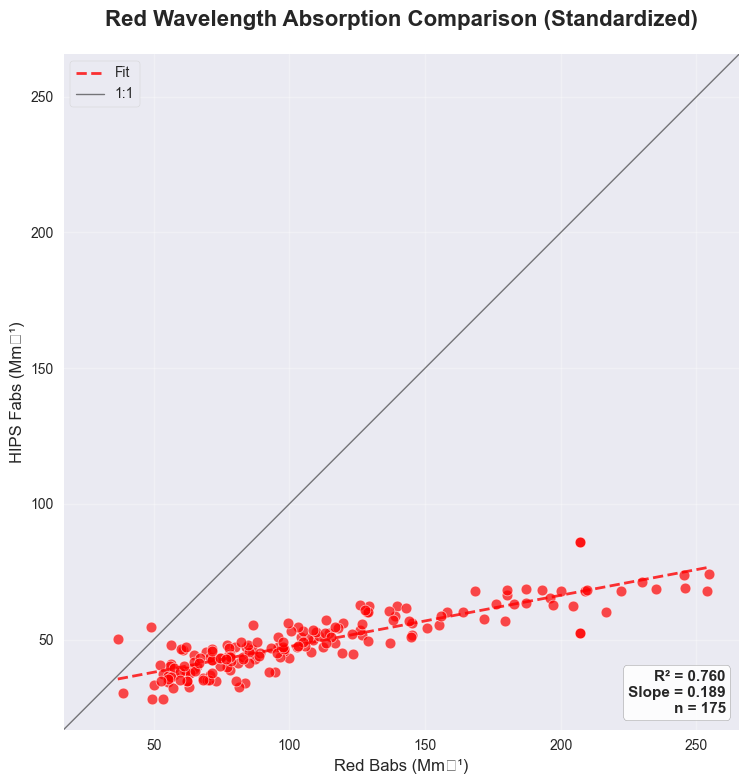

📊 Red Babs vs HIPS Fabs: R² = 0.760, Slope = 0.189, n = 175

🟤 Creating standardized IR Babs vs HIPS Fabs cross-plot...


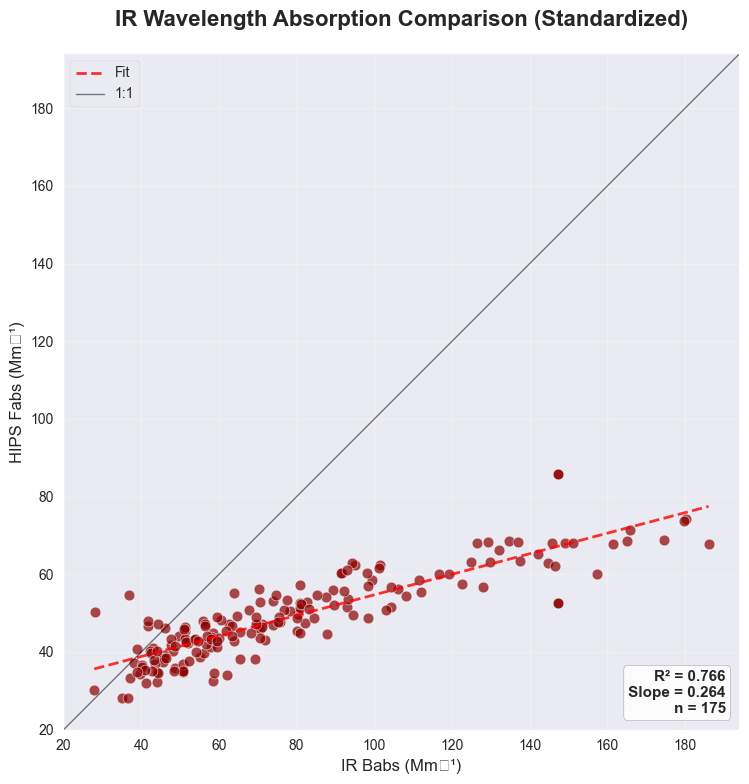

📊 IR Babs vs HIPS Fabs: R² = 0.766, Slope = 0.264, n = 175


In [8]:
# Standardized Babs vs HIPS Fabs Analysis - Dual Wavelength Comparison
print("🔴 Creating standardized Red Babs vs HIPS Fabs cross-plot...")

if 'Red Babs' in matched_data.columns and 'HIPS_Fabs' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'Red Babs', 'HIPS_Fabs',
        'Red Wavelength Absorption Comparison (Standardized)',
        'Red Babs (Mm⁻¹)', 'HIPS Fabs (Mm⁻¹)', 
        color='red', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 Red Babs vs HIPS Fabs: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ Red Babs or HIPS_Fabs data not available")

print("\n🟤 Creating standardized IR Babs vs HIPS Fabs cross-plot...")

if 'IR Babs' in matched_data.columns and 'HIPS_Fabs' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'IR Babs', 'HIPS_Fabs',
        'IR Wavelength Absorption Comparison (Standardized)',
        'IR Babs (Mm⁻¹)', 'HIPS Fabs (Mm⁻¹)', 
        color='darkred', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 IR Babs vs HIPS Fabs: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ IR Babs or HIPS_Fabs data not available")

In [9]:
# Create seasonal MAC time series visualization with instance averages
if 'MAC' in matched_data.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Use the outlier-cleaned data if available, otherwise use all valid data
    if 'valid_mac_no_outliers' in locals() and len(valid_mac_no_outliers) > 0:
        valid_mac = valid_mac_no_outliers.copy()
        title_suffix = " (Outliers Removed)"
        print("🧹 Using outlier-cleaned data for visualization")
    else:
        valid_mac = matched_data[matched_data['MAC'].notna()].copy()
        title_suffix = ""
        print("📊 Using all valid MAC data")
    
    if len(valid_mac) > 0:
        # Create single time series plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
        available_seasons = [s for s in seasons_order if s in valid_mac['Ethiopian_Season'].values]
        season_colors = {'Dry Season': 'brown', 'Belg Rainy Season': 'green', 'Kiremt Rainy Season': 'blue'}
        
        # First, plot all individual data points
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season]
            if len(season_data) > 0:
                ax.scatter(season_data['datetime_local'], season_data['MAC'],
                           label=season, alpha=0.7, s=50,
                           color=season_colors.get(season, 'gray'))
        
        # Create better seasonal clustering using date gaps to identify distinct seasonal periods
        season_averages = []
        
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season].sort_values('datetime_local')
            
            if len(season_data) > 0:
                # Identify clusters within each season based on temporal gaps
                clusters = []
                current_cluster = [season_data.iloc[0]]
                
                for i in range(1, len(season_data)):
                    current_date = season_data.iloc[i]['datetime_local']
                    prev_date = season_data.iloc[i-1]['datetime_local']
                    
                    # If gap is more than 60 days, start a new cluster
                    if (current_date - prev_date).days > 60:
                        if len(current_cluster) >= 5:  # Only create average if cluster has ≥5 points
                            clusters.append(current_cluster)
                        current_cluster = [season_data.iloc[i]]
                    else:
                        current_cluster.append(season_data.iloc[i])
                
                # Don't forget the last cluster
                if len(current_cluster) >= 5:
                    clusters.append(current_cluster)
                
                # Create averages for each cluster
                for cluster in clusters:
                    cluster_df = pd.DataFrame(cluster)
                    avg_mac = cluster_df['MAC'].mean()
                    avg_date = cluster_df['datetime_local'].iloc[len(cluster_df)//2]  # median date
                    n_samples = len(cluster_df)
                    
                    season_averages.append({
                        'date': avg_date,
                        'season': season,
                        'avg_mac': avg_mac,
                        'n_samples': n_samples
                    })
        
        # Convert to DataFrame for easier plotting
        avg_df = pd.DataFrame(season_averages)
        
        # Plot the diamond markers with a single legend entry
        if len(avg_df) > 0:
            for i, (_, row) in enumerate(avg_df.iterrows()):
                # Only add legend label for the first diamond
                legend_label = "Season Averages" if i == 0 else ""
                
                ax.scatter(row['date'], row['avg_mac'],
                           alpha=1.0, s=150, marker='D',
                           color=season_colors.get(row['season'], 'gray'),
                           edgecolors='black', linewidth=2,
                           label=legend_label)
                
                # Add text labels showing the average value
                ax.annotate(f'{row["avg_mac"]:.1f}', 
                           (row['date'], row['avg_mac']),
                           xytext=(0, 15), textcoords='offset points',
                           ha='center', va='bottom', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='black'))
        
        ax.set_title(f'MAC Time Series by Season{title_suffix}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('MAC (m²/g)', fontsize=12)
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        print("📈 Seasonal MAC Comparison:")
        
        # Print season instance details
        if len(avg_df) > 0:
            print(f"\n📊 Season Instance Averages:")
            for _, row in avg_df.iterrows():
                print(f"   {row['season']} {row['year']}: {row['avg_mac']:.2f} m²/g (n = {row['n_samples']})")
        
        # Calculate overall statistics
        overall_mac = valid_mac['MAC']
        print(f"\n   Overall MAC: {overall_mac.mean():.2f} ± {overall_mac.std():.2f} m²/g (n = {len(overall_mac)})")
        
        # Season-to-season ratios
        season_means = valid_mac.groupby('Ethiopian_Season')['MAC'].mean()
        print("\n   Season Ratios (relative to Dry Season):")
        if 'Dry Season' in season_means.index:
            dry_mean = season_means['Dry Season']
            for season in season_means.index:
                ratio = season_means[season] / dry_mean
                print(f"     {season}: {ratio:.2f}x")
        
        print("✅ Seasonal MAC analysis with instance averages complete!")
    else:
        print("❌ No valid MAC data for visualization")
else:
    print("❌ MAC not calculated - skipping visualization")

❌ MAC not calculated - skipping visualization


## 5. BCc vs FTIR EC Analysis

🔴 Creating standardized Red BCc vs FTIR EC cross-plot...


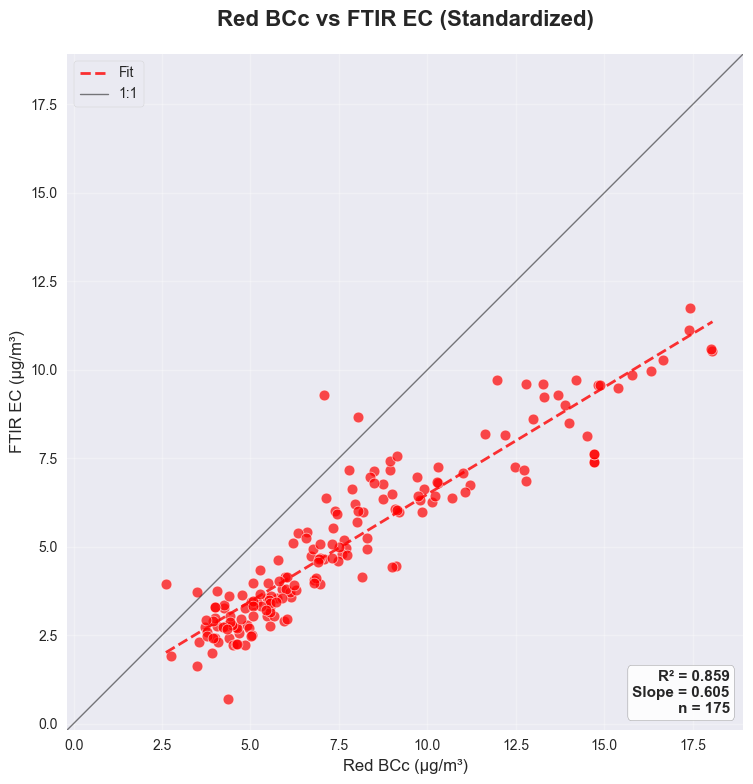

📊 Red BCc vs FTIR EC: R² = 0.859, Slope = 0.605, n = 175

🟤 Creating standardized IR BCc vs FTIR EC cross-plot...


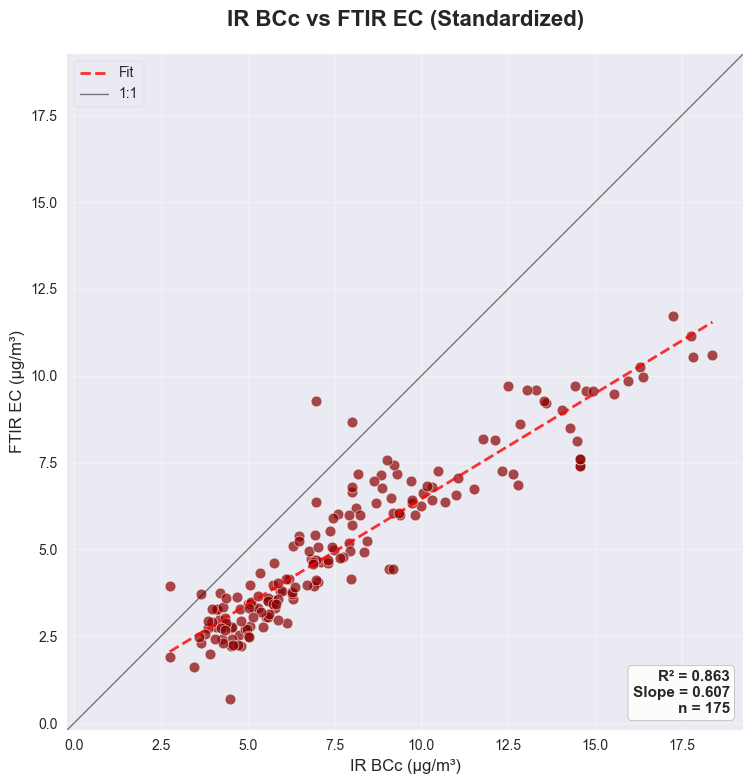

📊 IR BCc vs FTIR EC: R² = 0.863, Slope = 0.607, n = 175


In [10]:
# Standardized BCc vs FTIR EC Analysis - Dual Wavelength Comparison
print("🔴 Creating standardized Red BCc vs FTIR EC cross-plot...")

if 'Red BCc smoothed' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'Red BCc smoothed', 'EC_ftir',
        'Red BCc vs FTIR EC (Standardized)',
        'Red BCc (μg/m³)', 'FTIR EC (μg/m³)', 
        color='red', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs FTIR EC: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ Red BCc or FTIR EC data not available")

print("\n🟤 Creating standardized IR BCc vs FTIR EC cross-plot...")

if 'IR BCc smoothed' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'IR BCc smoothed', 'EC_ftir',
        'IR BCc vs FTIR EC (Standardized)',
        'IR BCc (μg/m³)', 'FTIR EC (μg/m³)', 
        color='darkred', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 IR BCc vs FTIR EC: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ IR BCc or FTIR EC data not available")

In [11]:
# Create seasonal MAC time series visualization with instance averages
if 'MAC' in matched_data.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Use the outlier-cleaned data if available, otherwise use all valid data
    if 'valid_mac_no_outliers' in locals() and len(valid_mac_no_outliers) > 0:
        valid_mac = valid_mac_no_outliers.copy()
        title_suffix = " (Outliers Removed)"
        print("🧹 Using outlier-cleaned data for visualization")
    else:
        valid_mac = matched_data[matched_data['MAC'].notna()].copy()
        title_suffix = ""
        print("📊 Using all valid MAC data")
    
    if len(valid_mac) > 0:
        # Create single time series plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
        available_seasons = [s for s in seasons_order if s in valid_mac['Ethiopian_Season'].values]
        season_colors = {'Dry Season': 'brown', 'Belg Rainy Season': 'green', 'Kiremt Rainy Season': 'blue'}
        
        # First, plot all individual data points
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season]
            if len(season_data) > 0:
                ax.scatter(season_data['datetime_local'], season_data['MAC'],
                           label=season, alpha=0.7, s=50,
                           color=season_colors.get(season, 'gray'))
        
        # Create better seasonal clustering using date gaps to identify distinct seasonal periods
        season_averages = []
        
        for season in available_seasons:
            season_data = valid_mac[valid_mac['Ethiopian_Season'] == season].sort_values('datetime_local')
            
            if len(season_data) > 0:
                # Identify clusters within each season based on temporal gaps
                clusters = []
                current_cluster = [season_data.iloc[0]]
                
                for i in range(1, len(season_data)):
                    current_date = season_data.iloc[i]['datetime_local']
                    prev_date = season_data.iloc[i-1]['datetime_local']
                    
                    # If gap is more than 60 days, start a new cluster
                    if (current_date - prev_date).days > 60:
                        if len(current_cluster) >= 5:  # Only create average if cluster has ≥5 points
                            clusters.append(current_cluster)
                        current_cluster = [season_data.iloc[i]]
                    else:
                        current_cluster.append(season_data.iloc[i])
                
                # Don't forget the last cluster
                if len(current_cluster) >= 5:
                    clusters.append(current_cluster)
                
                # Create averages for each cluster
                for cluster in clusters:
                    cluster_df = pd.DataFrame(cluster)
                    avg_mac = cluster_df['MAC'].mean()
                    avg_date = cluster_df['datetime_local'].iloc[len(cluster_df)//2]  # median date
                    n_samples = len(cluster_df)
                    
                    season_averages.append({
                        'date': avg_date,
                        'season': season,
                        'avg_mac': avg_mac,
                        'n_samples': n_samples
                    })
        
        # Convert to DataFrame for easier plotting
        avg_df = pd.DataFrame(season_averages)
        
        # Plot the diamond markers with a single legend entry
        if len(avg_df) > 0:
            for i, (_, row) in enumerate(avg_df.iterrows()):
                # Only add legend label for the first diamond
                legend_label = "Season Averages" if i == 0 else ""
                
                ax.scatter(row['date'], row['avg_mac'],
                           alpha=1.0, s=150, marker='D',
                           color=season_colors.get(row['season'], 'gray'),
                           edgecolors='black', linewidth=2,
                           label=legend_label)
                
                # Add text labels showing the average value
                ax.annotate(f'{row["avg_mac"]:.1f}', 
                           (row['date'], row['avg_mac']),
                           xytext=(0, 15), textcoords='offset points',
                           ha='center', va='bottom', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='black'))
        
        ax.set_title(f'MAC Time Series by Season{title_suffix}', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('MAC (m²/g)', fontsize=12)
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical comparison
        print("📈 Seasonal MAC Comparison:")
        
        # Print season instance details
        if len(avg_df) > 0:
            print(f"\n📊 Season Instance Averages:")
            for _, row in avg_df.iterrows():
                print(f"   {row['season']} {row['year']}: {row['avg_mac']:.2f} m²/g (n = {row['n_samples']})")
        
        # Calculate overall statistics
        overall_mac = valid_mac['MAC']
        print(f"\n   Overall MAC: {overall_mac.mean():.2f} ± {overall_mac.std():.2f} m²/g (n = {len(overall_mac)})")
        
        # Season-to-season ratios
        season_means = valid_mac.groupby('Ethiopian_Season')['MAC'].mean()
        print("\n   Season Ratios (relative to Dry Season):")
        if 'Dry Season' in season_means.index:
            dry_mean = season_means['Dry Season']
            for season in season_means.index:
                ratio = season_means[season] / dry_mean
                print(f"     {season}: {ratio:.2f}x")
        
        print("✅ Seasonal MAC analysis with instance averages complete!")
    else:
        print("❌ No valid MAC data for visualization")
else:
    print("❌ MAC not calculated - skipping visualization")

❌ MAC not calculated - skipping visualization


## 6. BCc vs Iron Analysis

🔴 Creating standardized Red BCc vs Iron cross-plot...


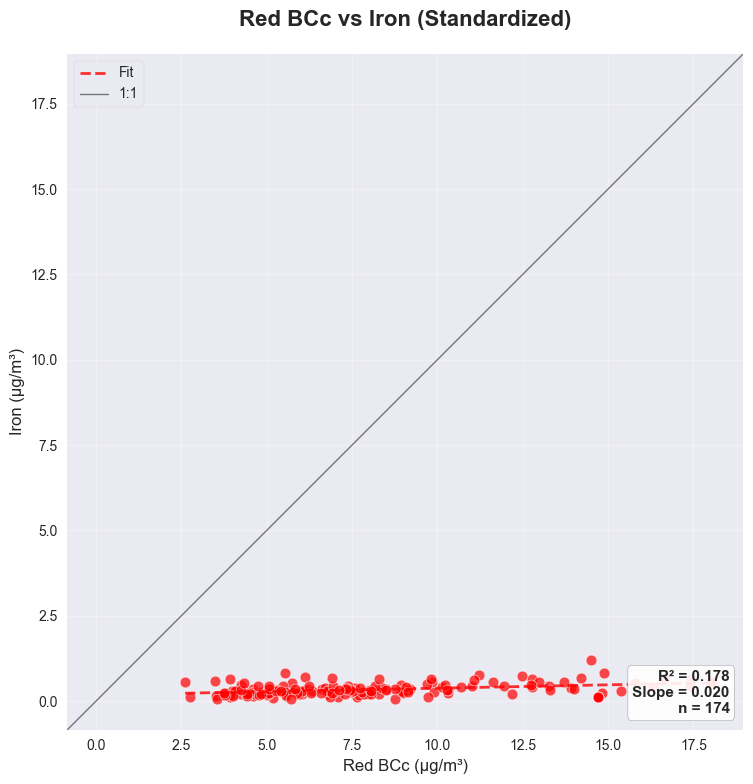

📊 Red BCc vs Iron: R² = 0.178, Slope = 0.020, n = 174

🟤 Creating standardized IR BCc vs Iron cross-plot...


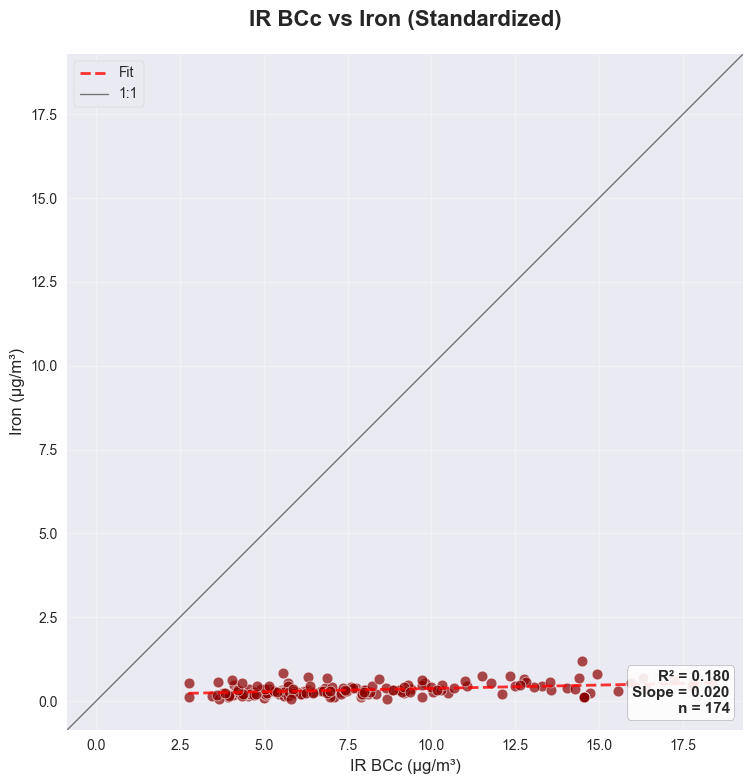

📊 IR BCc vs Iron: R² = 0.180, Slope = 0.020, n = 174


In [12]:
# Standardized BCc vs Iron Analysis - Dual Wavelength Comparison (Iron in µg/m³)
print("🔴 Creating standardized Red BCc vs Iron cross-plot...")

if 'Red BCc smoothed' in matched_data.columns and 'Iron_ChemSpec_ug' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'Red BCc smoothed', 'Iron_ChemSpec_ug',
        'Red BCc vs Iron (Standardized)',
        'Red BCc (μg/m³)', 'Iron (μg/m³)', 
        color='red', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ Red BCc or Iron data not available")

print("\n🟤 Creating standardized IR BCc vs Iron cross-plot...")

if 'IR BCc smoothed' in matched_data.columns and 'Iron_ChemSpec_ug' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'IR BCc smoothed', 'Iron_ChemSpec_ug',
        'IR BCc vs Iron (Standardized)',
        'IR BCc (μg/m³)', 'Iron (μg/m³)', 
        color='darkred', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 IR BCc vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ IR BCc or Iron data not available")

## 7. HIPS Fabs vs Iron Analysis

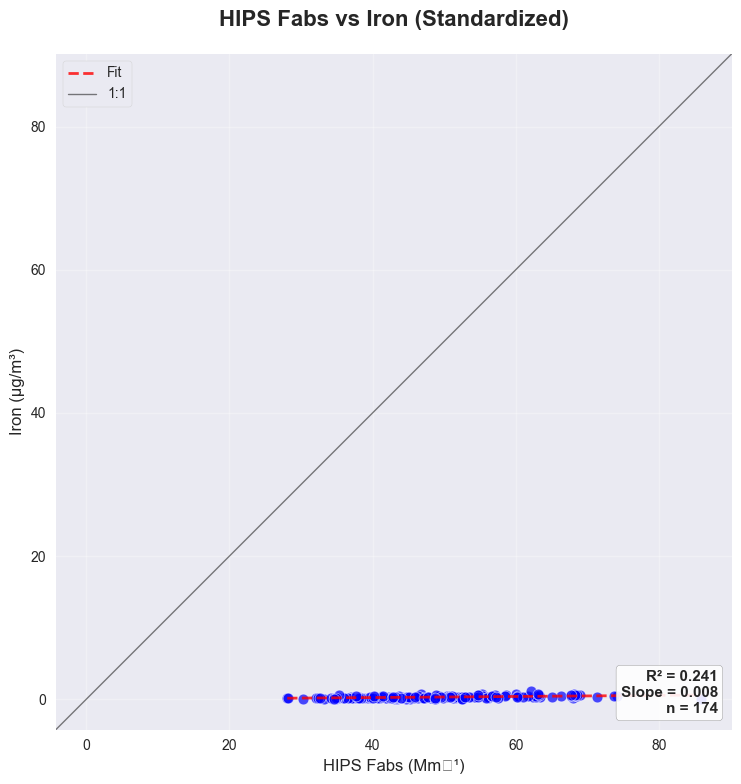

📊 HIPS Fabs vs Iron: R² = 0.241, Slope = 0.008, n = 174


In [13]:
# Standardized HIPS Fabs vs Iron Analysis (Iron in µg/m³)
if 'HIPS_Fabs' in matched_data.columns and 'Iron_ChemSpec_ug' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'HIPS_Fabs', 'Iron_ChemSpec_ug',
        'HIPS Fabs vs Iron (Standardized)',
        'HIPS Fabs (Mm⁻¹)', 'Iron (μg/m³)', 
        color='blue', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 HIPS Fabs vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ HIPS Fabs or Iron data not available")

## 8. FTIR EC vs Iron Analysis

## 8.5. Fe/EC Time Series Analysis

🧮 Calculating Fe/EC ratio time series...


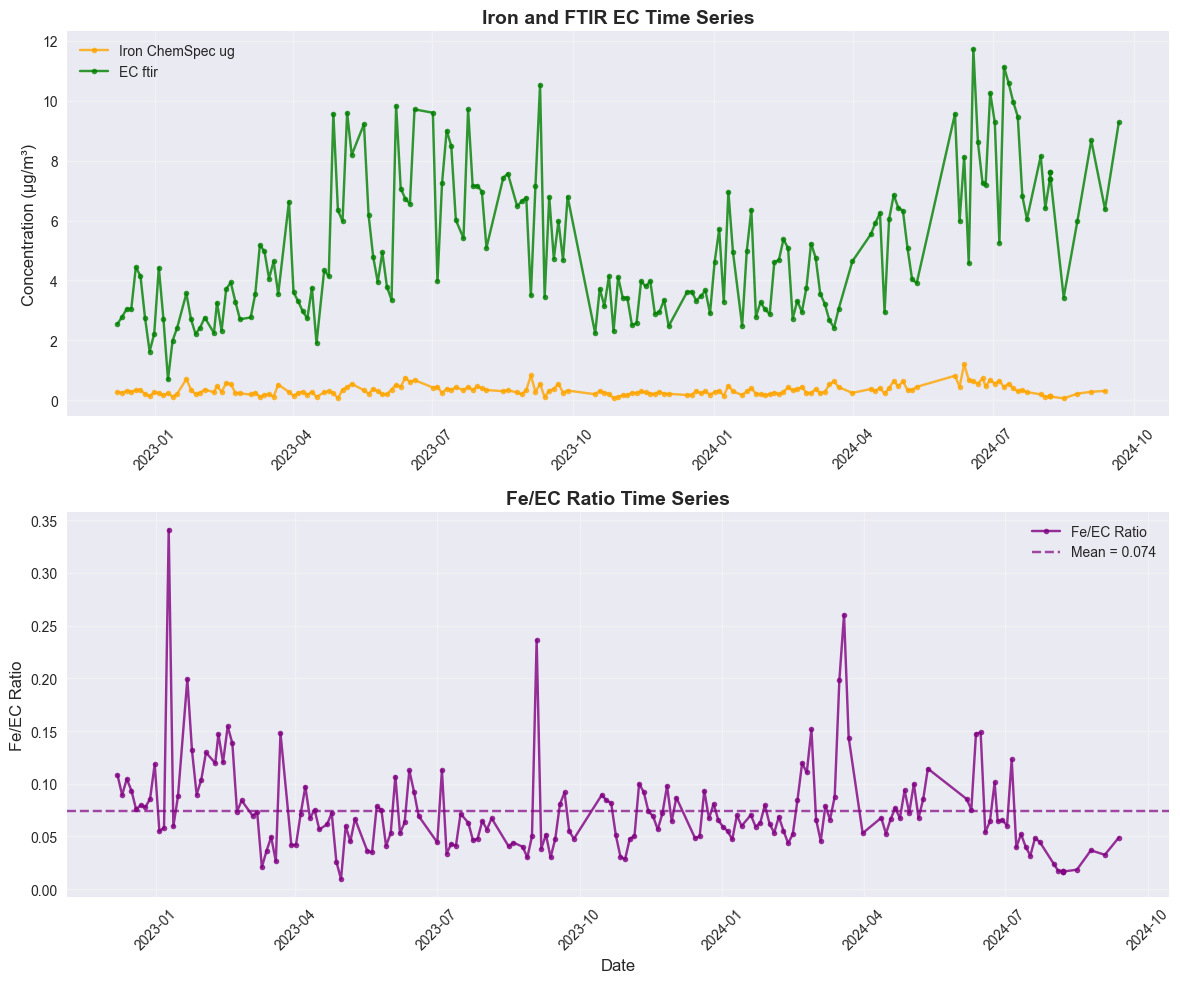

📊 Fe/EC Ratio Statistics:
   Mean: 0.074
   Std:  0.044
   Range: 0.009 - 0.341
   Count: 174 samples


In [14]:
# Calculate and plot Fe/EC ratio time series
print("🧮 Calculating Fe/EC ratio time series...")

if 'Iron_ChemSpec_ug' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    # Calculate Fe/EC ratio
    fe_ec_mask = matched_data[['Iron_ChemSpec_ug', 'EC_ftir']].notna().all(axis=1)
    
    if fe_ec_mask.sum() > 0:
        matched_data.loc[fe_ec_mask, 'Fe_EC_ratio'] = matched_data.loc[fe_ec_mask, 'Iron_ChemSpec_ug'] / matched_data.loc[fe_ec_mask, 'EC_ftir']
        
        # Create time series plot for Fe, EC, and Fe/EC ratio
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: Fe and EC time series
        fe_ec_columns = ['Iron_ChemSpec_ug', 'EC_ftir']
        colors = ['orange', 'green']
        
        for i, col in enumerate(fe_ec_columns):
            if col in matched_data.columns:
                mask = matched_data[col].notna()
                if mask.sum() > 0:
                    ax1.plot(matched_data.loc[mask, 'datetime_local'], matched_data.loc[mask, col], 
                           'o-', label=col.replace('_', ' '), alpha=0.8, markersize=4, color=colors[i])
        
        ax1.set_title('Iron and FTIR EC Time Series', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Concentration (μg/m³)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Fe/EC ratio time series
        ratio_mask = matched_data['Fe_EC_ratio'].notna()
        if ratio_mask.sum() > 0:
            ax2.plot(matched_data.loc[ratio_mask, 'datetime_local'], matched_data.loc[ratio_mask, 'Fe_EC_ratio'], 
                    'o-', color='purple', alpha=0.8, markersize=4, label='Fe/EC Ratio')
            
            # Add mean line
            mean_ratio = matched_data.loc[ratio_mask, 'Fe_EC_ratio'].mean()
            ax2.axhline(y=mean_ratio, color='purple', linestyle='--', alpha=0.7, 
                       label=f'Mean = {mean_ratio:.3f}')
        
        ax2.set_title('Fe/EC Ratio Time Series', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Fe/EC Ratio', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Statistics
        fe_ec_ratio = matched_data.loc[ratio_mask, 'Fe_EC_ratio']
        print(f"📊 Fe/EC Ratio Statistics:")
        print(f"   Mean: {fe_ec_ratio.mean():.3f}")
        print(f"   Std:  {fe_ec_ratio.std():.3f}")
        print(f"   Range: {fe_ec_ratio.min():.3f} - {fe_ec_ratio.max():.3f}")
        print(f"   Count: {len(fe_ec_ratio)} samples")
        
    else:
        print("❌ Insufficient data for Fe/EC ratio calculation")
else:
    print("❌ Iron or EC data not available for Fe/EC ratio")

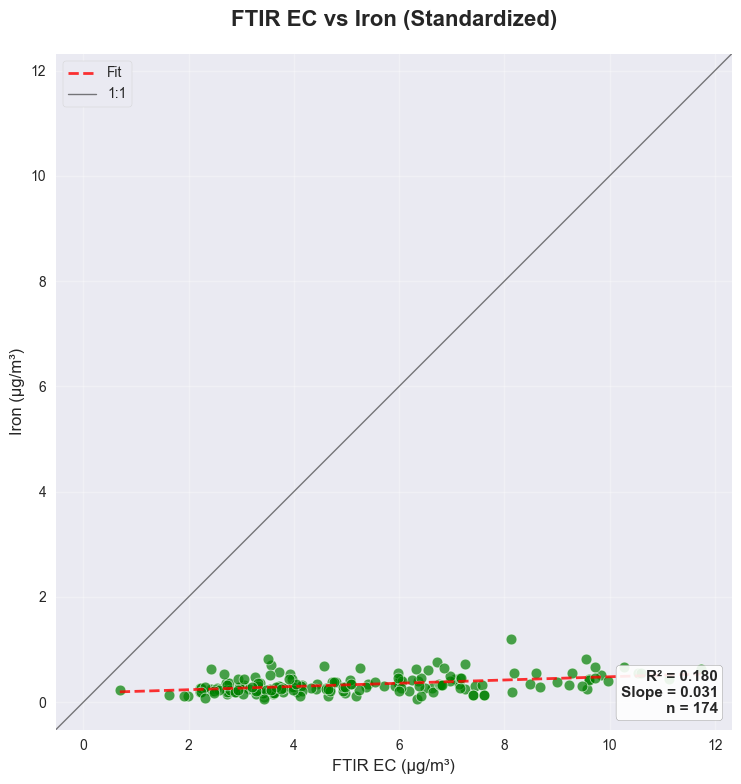

📊 FTIR EC vs Iron: R² = 0.180, Slope = 0.031, n = 174


In [15]:
# Standardized FTIR EC vs Iron Analysis (Iron in µg/m³)
if 'EC_ftir' in matched_data.columns and 'Iron_ChemSpec_ug' in matched_data.columns:
    fig, ax, stats = create_correlation_plot(
        matched_data, 'EC_ftir', 'Iron_ChemSpec_ug',
        'FTIR EC vs Iron (Standardized)',
        'FTIR EC (μg/m³)', 'Iron (μg/m³)', 
        color='green', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 FTIR EC vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ FTIR EC or Iron data not available")

## 9. Time Series Analysis

📡 Aethalometer BCc Time Series - Dual Wavelength Analysis


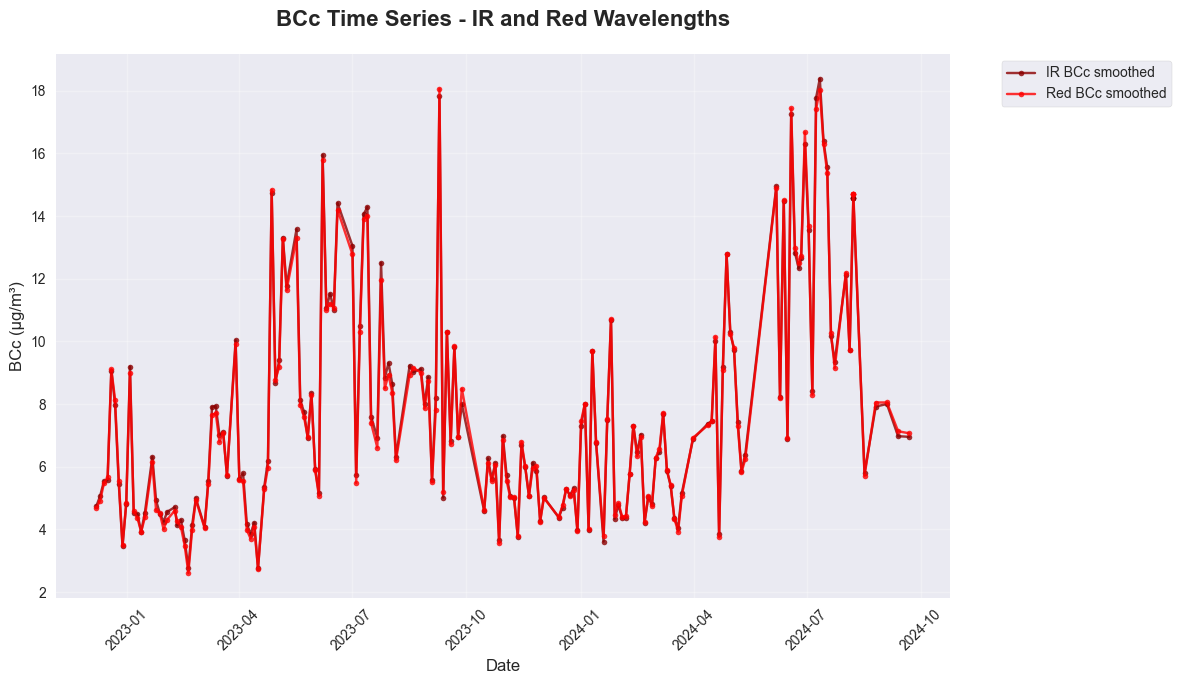

📊 BCc Data Availability by Wavelength:
   IR BCc: 175 values (mean: 7.789 μg/m³)
   Red BCc: 175 values (mean: 7.740 μg/m³)


In [16]:
# Time series: BCc measurements (Dual Wavelength Analysis)
print("📡 Aethalometer BCc Time Series - Dual Wavelength Analysis")

bc_columns = ['IR BCc smoothed', 'Red BCc smoothed']
available_bc_cols = [col for col in bc_columns if col in matched_data.columns]

if available_bc_cols:
    fig, ax = create_time_series_plot(
        matched_data, available_bc_cols,
        'BCc Time Series - IR and Red Wavelengths',
        'BCc (μg/m³)',
        colors=['darkred', 'red']
    )
    plt.show()
    
    # Print data availability for each wavelength
    print("📊 BCc Data Availability by Wavelength:")
    for col in available_bc_cols:
        count = matched_data[col].notna().sum()
        wavelength = col.split(' ')[0]
        mean_val = matched_data[col].mean()
        print(f"   {wavelength} BCc: {count} values (mean: {mean_val:.3f} μg/m³)")
        
else:
    print("❌ No BCc data available for time series")

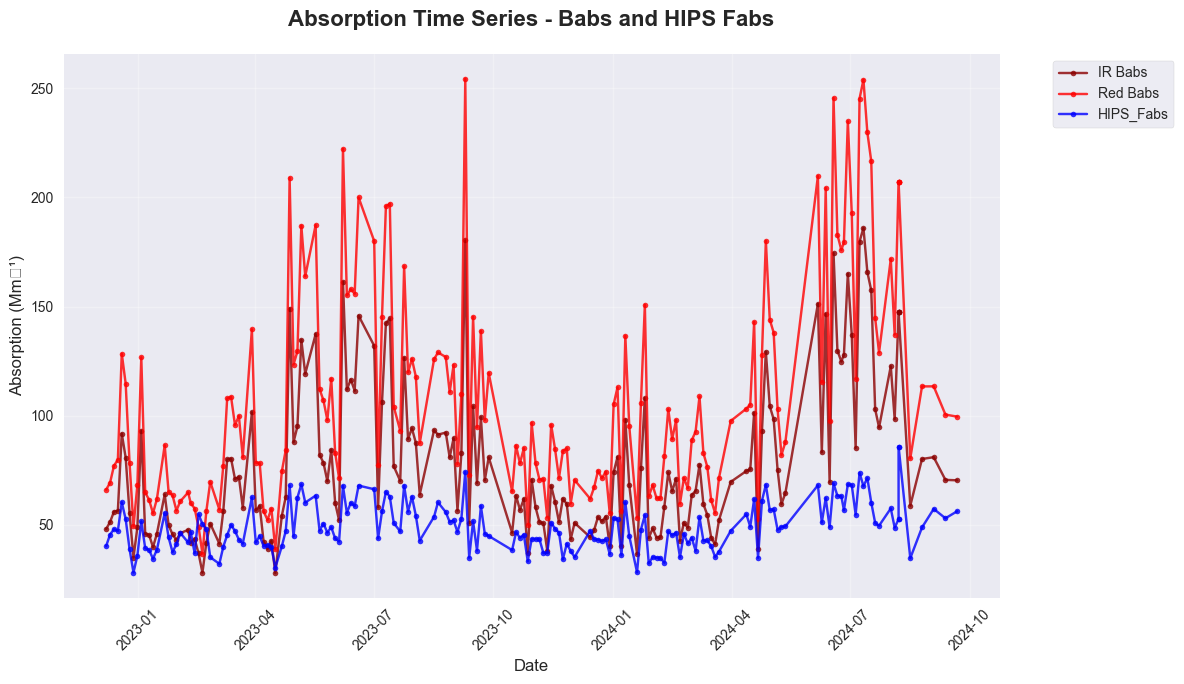

In [17]:
# Time series: Absorption measurements (Babs vs Fabs)
babs_fabs_columns = ['IR Babs', 'Red Babs', 'HIPS_Fabs']
available_cols = [col for col in babs_fabs_columns if col in matched_data.columns]

if available_cols:
    fig, ax = create_time_series_plot(
        matched_data, available_cols,
        'Absorption Time Series - Babs and HIPS Fabs',
        'Absorption (Mm⁻¹)',
        colors=['darkred', 'red', 'blue']
    )
    plt.show()
else:
    print("❌ No absorption data available for time series")

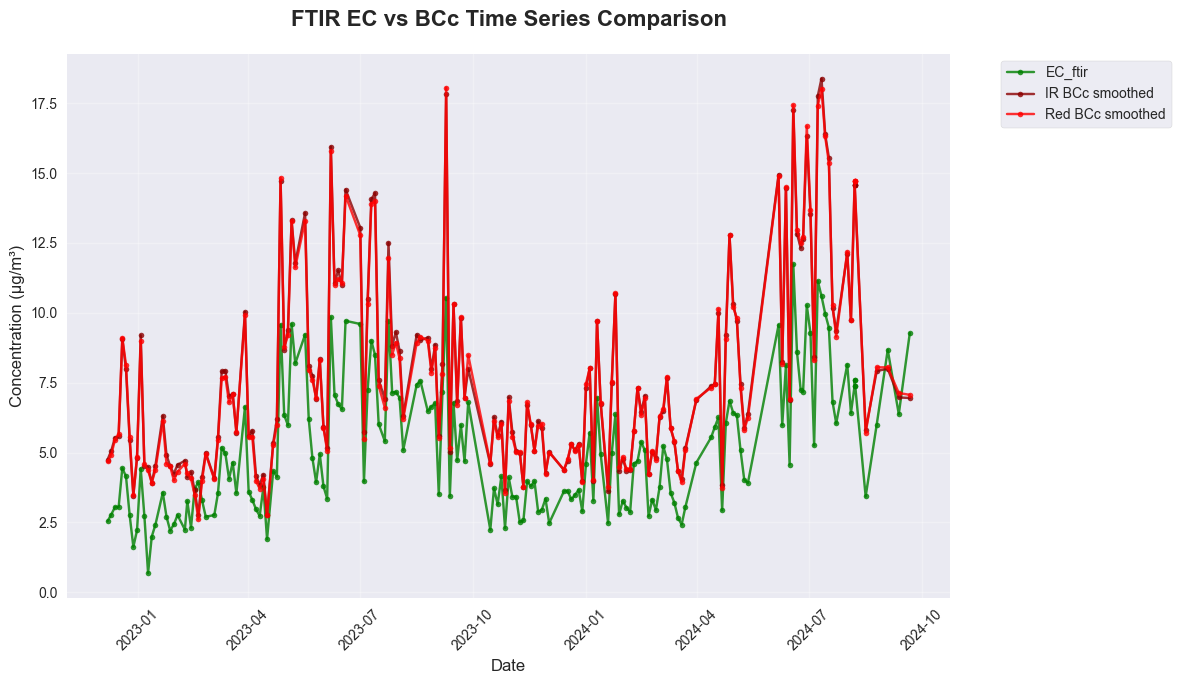

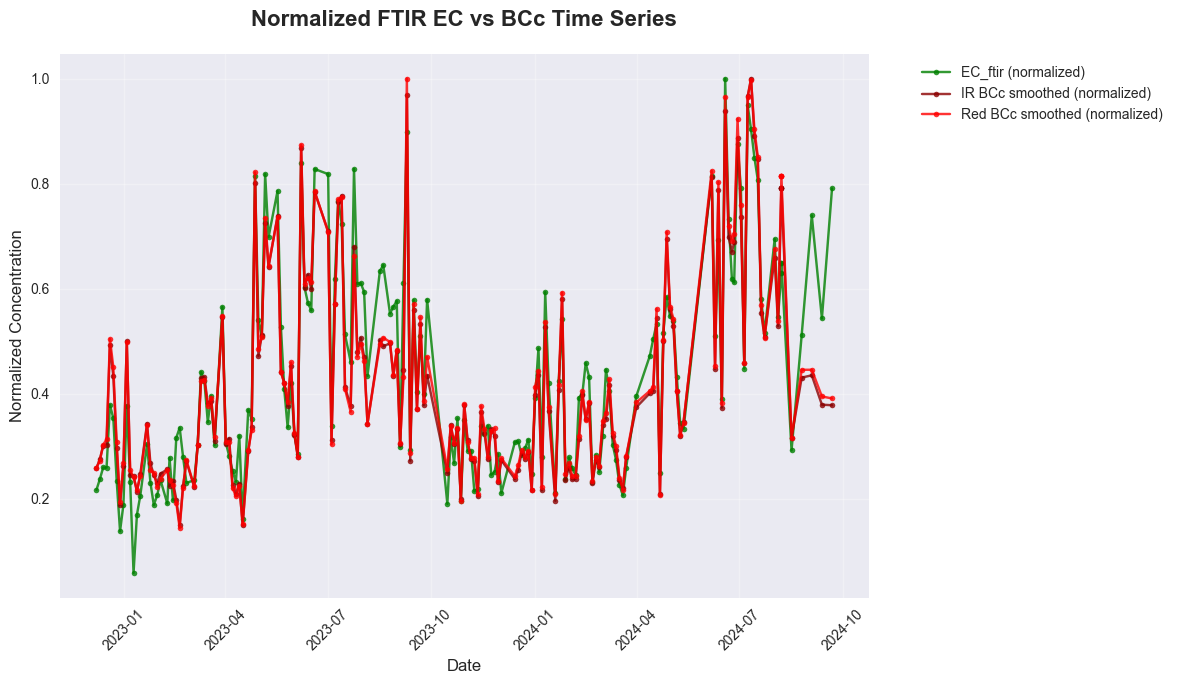

📊 Time series plots show both absolute and normalized comparisons
   Normalized plot allows visual comparison of temporal patterns


In [18]:
# Time series: FTIR EC vs BCc comparison
ec_bcc_columns = ['EC_ftir', 'IR BCc smoothed', 'Red BCc smoothed']
available_ec_bcc_cols = [col for col in ec_bcc_columns if col in matched_data.columns]

if available_ec_bcc_cols:
    fig, ax = create_time_series_plot(
        matched_data, available_ec_bcc_cols,
        'FTIR EC vs BCc Time Series Comparison',
        'Concentration (μg/m³)',
        colors=['green', 'darkred', 'red']
    )
    plt.show()
    
    # Also create a normalized comparison for better visual comparison
    fig2, ax2 = plt.subplots(figsize=(12, 7))
    
    for i, col in enumerate(available_ec_bcc_cols):
        if col in matched_data.columns:
            mask = matched_data[col].notna()
            if mask.sum() > 0:
                # Normalize each parameter by its maximum value
                data_normalized = matched_data.loc[mask, col] / matched_data[col].max()
                colors = ['green', 'darkred', 'red']
                ax2.plot(matched_data.loc[mask, 'datetime_local'], data_normalized, 
                        'o-', label=f'{col} (normalized)', alpha=0.8, markersize=4, 
                        color=colors[i % len(colors)])
    
    ax2.set_title('Normalized FTIR EC vs BCc Time Series', fontsize=16, fontweight='bold', pad=20)
    ax2.set_ylabel('Normalized Concentration', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("📊 Time series plots show both absolute and normalized comparisons")
    print("   Normalized plot allows visual comparison of temporal patterns")
    
else:
    print("❌ No EC or BCc data available for time series")

## 9.5. Iron-Coded BCc vs FTIR EC Analysis

In [19]:
# Create Aethalometer vs FTIR-EC scatter plots (IR and Red wavelengths, Fe color-coding)
print("🎨 Creating BCc vs FTIR EC scatter plots with Iron color-coding (Iron in µg/m³)...")

def create_iron_coded_scatter(data, x_col, y_col, iron_col, title, x_label, y_label, standardized=False):
    """
    Create scatter plot with Iron concentration color-coding.
    If standardized=True, creates square plot with identical ranges and 1:1 line.
    """
    fig, ax = plt.subplots(figsize=(9, 8) if standardized else (11, 8))
    
    # Filter valid data for all three variables
    mask = data[[x_col, y_col, iron_col]].notna().all(axis=1)
    
    if mask.sum() < 3:
        ax.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        return fig, ax, {}
    
    x = data.loc[mask, x_col]
    y = data.loc[mask, y_col]
    iron = data.loc[mask, iron_col]
    
    # Create scatter plot with Iron color-coding
    scatter = ax.scatter(x, y, c=iron, cmap='plasma', alpha=0.7, s=60, 
                        edgecolors='white', linewidth=0.5)
    
    # Add colorbar for Iron - position it to not overlap
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
    cbar.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
    
    # Regression line and statistics
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope, intercept = z
    
    # Plot regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, p(x_line), "--", alpha=0.8, linewidth=2, color='red', label='Fit')
    
    # Standardized cross-plot formatting
    if standardized:
        # Set identical ranges and square aspect
        data_min = min(x.min(), y.min())
        data_max = max(x.max(), y.max())
        buffer = (data_max - data_min) * 0.05
        plot_min = data_min - buffer
        plot_max = data_max + buffer
        
        ax.set_xlim(plot_min, plot_max)
        ax.set_ylim(plot_min, plot_max)
        ax.set_aspect('equal')
        
        # Add 1:1 line
        ax.plot([plot_min, plot_max], [plot_min, plot_max], 'k-', alpha=0.5, linewidth=1, label='1:1')
        
        # Position legend in upper left corner
        ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, framealpha=0.9)
    
    # Calculate statistics
    corr = x.corr(y)
    r2 = corr**2
    n = len(x)
    
    # Iron statistics
    iron_mean = iron.mean()
    iron_std = iron.std()
    
    # Position statistics text in bottom right corner to avoid legend overlap
    stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\nn = {n}\nFe: {iron_mean:.3f} ± {iron_std:.3f} μg/m³'
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, 
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'),
            fontsize=11, fontweight='bold')
    
    # Formatting
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, ax, {'r2': r2, 'slope': slope, 'n': n, 'corr': corr, 'iron_mean': iron_mean, 'iron_std': iron_std}

print("✅ Iron-coded scatter plot function defined with optimal positioning")

🎨 Creating BCc vs FTIR EC scatter plots with Iron color-coding (Iron in µg/m³)...
✅ Iron-coded scatter plot function defined with optimal positioning


🔴 Creating standardized Red BCc vs FTIR EC (Iron color-coded) cross-plot...


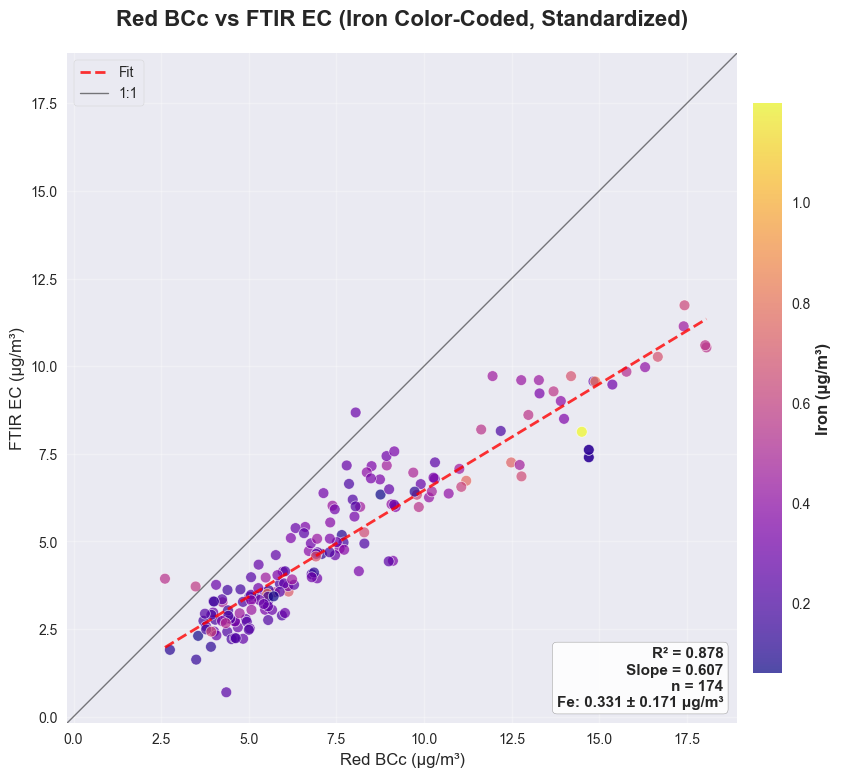

📊 Red BCc vs FTIR EC (Fe-coded): R² = 0.878, Slope = 0.607, n = 174
🧲 Iron range: 0.331 ± 0.171 μg/m³

🟤 Creating standardized IR BCc vs FTIR EC (Iron color-coded) cross-plot...


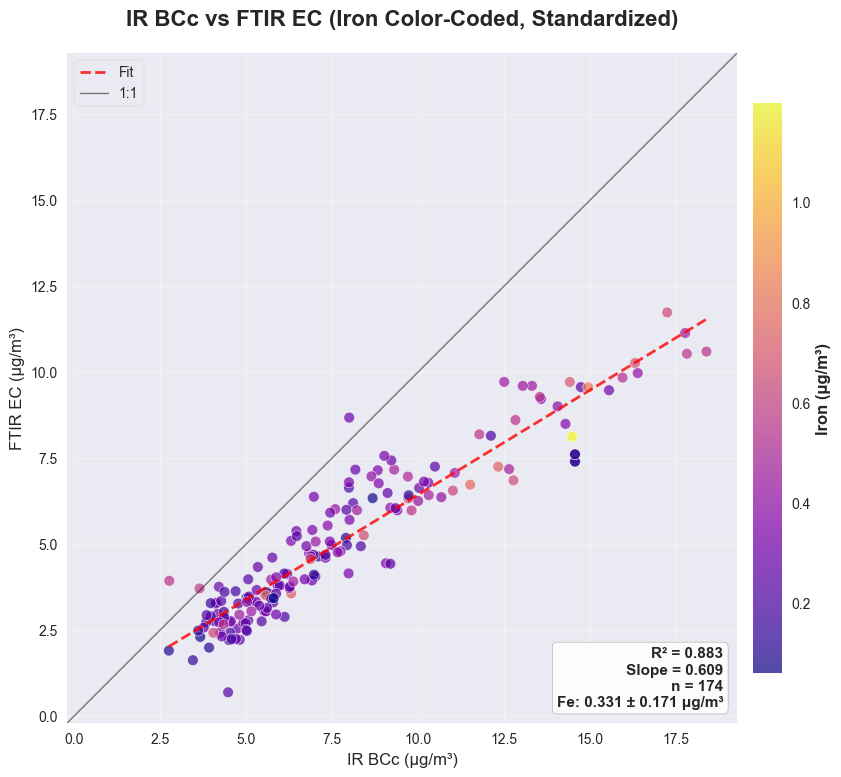

📊 IR BCc vs FTIR EC (Fe-coded): R² = 0.883, Slope = 0.609, n = 174
🧲 Iron range: 0.331 ± 0.171 μg/m³


In [20]:
# Standardized Iron-coded BCc vs FTIR EC Analysis - Dual Wavelength Comparison
print("🔴 Creating standardized Red BCc vs FTIR EC (Iron color-coded) cross-plot...")

if all(col in matched_data.columns for col in ['Red BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    fig, ax, stats = create_iron_coded_scatter(
        matched_data, 'Red BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug',
        'Red BCc vs FTIR EC (Iron Color-Coded, Standardized)',
        'Red BCc (μg/m³)', 'FTIR EC (μg/m³)', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs FTIR EC (Fe-coded): R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
        print(f"🧲 Iron range: {stats['iron_mean']:.3f} ± {stats['iron_std']:.3f} μg/m³")
else:
    print("❌ Red BCc, FTIR EC, or Iron data not available")

print("\n🟤 Creating standardized IR BCc vs FTIR EC (Iron color-coded) cross-plot...")

if all(col in matched_data.columns for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    fig, ax, stats = create_iron_coded_scatter(
        matched_data, 'IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug',
        'IR BCc vs FTIR EC (Iron Color-Coded, Standardized)',
        'IR BCc (μg/m³)', 'FTIR EC (μg/m³)', standardized=True
    )
    plt.show()
    
    if stats:
        print(f"📊 IR BCc vs FTIR EC (Fe-coded): R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
        print(f"🧲 Iron range: {stats['iron_mean']:.3f} ± {stats['iron_std']:.3f} μg/m³")
else:
    print("❌ IR BCc, FTIR EC, or Iron data not available")

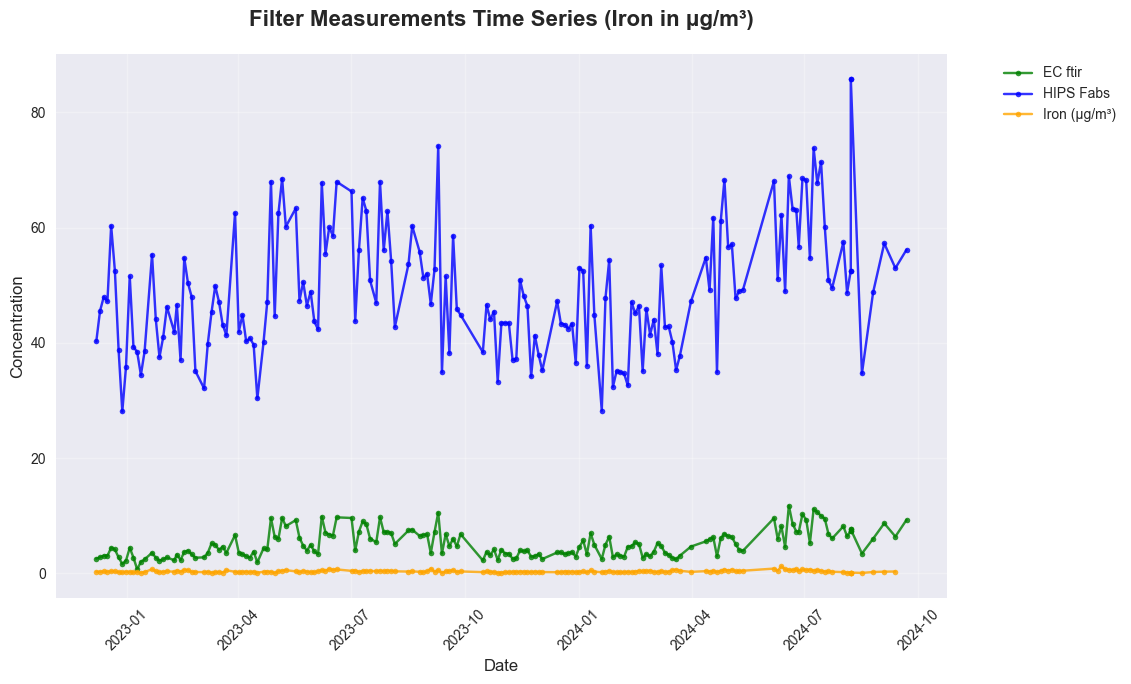

📊 Filter Measurements Data Availability:
   EC ftir: 175 values
   HIPS Fabs: 175 values
   Iron (μg/m³): 174 values


In [21]:
# Time series: Filter measurements (Iron in µg/m³)
filter_columns = ['EC_ftir', 'HIPS_Fabs', 'Iron_ChemSpec_ug']
available_filter_cols = [col for col in filter_columns if col in matched_data.columns]

if available_filter_cols:
    fig, ax = create_time_series_plot(
        matched_data, available_filter_cols,
        'Filter Measurements Time Series (Iron in μg/m³)',
        'Concentration',
        colors=['green', 'blue', 'orange']
    )
    
    # Update legend labels for clarity
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        if 'Iron_ChemSpec_ug' in label:
            new_labels.append('Iron (μg/m³)')
        else:
            new_labels.append(label.replace('_', ' '))
    ax.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()
    
    # Print data availability for filter measurements
    print("📊 Filter Measurements Data Availability:")
    for col in available_filter_cols:
        count = matched_data[col].notna().sum()
        col_name = 'Iron (μg/m³)' if 'Iron_ChemSpec_ug' in col else col.replace('_', ' ')
        print(f"   {col_name}: {count} values")
        
else:
    print("❌ No filter data available for time series")

## 9.6. Seasonal MAC Analysis

Calculate Mass Absorption Cross-section (MAC = HIPS Fabs / FTIR EC) by Ethiopian seasons.

In [22]:
# Calculate seasonal MAC values (HIPS Fabs / FTIR EC) with Iron context
print("🌍 Calculating seasonal MAC values for Ethiopian seasons...")

# Ethiopian season mapping
def map_ethiopian_seasons(month):
    if month in [10, 11, 12, 1, 2]:
        return 'Dry Season'
    elif month in [3, 4, 5]:
        return 'Belg Rainy Season'
    else:
        return 'Kiremt Rainy Season'

if 'HIPS_Fabs' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    # Filter valid data
    mac_mask = matched_data[['HIPS_Fabs', 'EC_ftir']].notna().all(axis=1)
    
    if mac_mask.sum() > 0:
        # Calculate MAC = HIPS Fabs / FTIR EC
        matched_data.loc[mac_mask, 'MAC'] = matched_data.loc[mac_mask, 'HIPS_Fabs'] / matched_data.loc[mac_mask, 'EC_ftir']
        
        # Extract month and map to Ethiopian seasons
        matched_data['month'] = matched_data['datetime_local'].dt.month
        matched_data['Ethiopian_Season'] = matched_data['month'].apply(map_ethiopian_seasons)
        
        print(f"📊 MAC calculated for {mac_mask.sum()} samples")
        print(f"📅 Date range: {matched_data.loc[mac_mask, 'match_date'].min()} to {matched_data.loc[mac_mask, 'match_date'].max()}")
        
        # Seasonal MAC statistics
        print("🌦️  Seasonal MAC Statistics:")
        seasonal_stats = matched_data.loc[mac_mask].groupby('Ethiopian_Season')['MAC'].agg(['count', 'mean', 'std', 'min', 'max'])
        
        for season in seasonal_stats.index:
            stats = seasonal_stats.loc[season]
            print(f"   {season}:")
            print(f"     Count: {stats['count']} samples")
            print(f"     MAC: {stats['mean']:.2f} ± {stats['std']:.2f} m²/g")
            print(f"     Range: {stats['min']:.2f} - {stats['max']:.2f} m²/g")
        
        # Iron context by season (if available)
        if 'Iron_ChemSpec_ug' in matched_data.columns:
            print("\n🧲 Seasonal Iron Statistics (μg/m³):")
            iron_seasonal_stats = matched_data.loc[mac_mask].groupby('Ethiopian_Season')['Iron_ChemSpec_ug'].agg(['count', 'mean', 'std'])
            
            for season in iron_seasonal_stats.index:
                stats = iron_seasonal_stats.loc[season]
                print(f"   {season}: {stats['mean']:.3f} ± {stats['std']:.3f} μg/m³ (n = {stats['count']})")
        
        print("✅ MAC values calculated as HIPS_Fabs / EC_ftir")
    else:
        print("❌ No valid HIPS Fabs and EC data for MAC calculation")
else:
    print("❌ HIPS Fabs or EC_ftir data not available")

🌍 Calculating seasonal MAC values for Ethiopian seasons...
📊 MAC calculated for 175 samples
📅 Date range: 2022-12-07 to 2024-09-21
🌦️  Seasonal MAC Statistics:
   Belg Rainy Season:
     Count: 46.0 samples
     MAC: 10.65 ± 2.28 m²/g
     Range: 6.87 - 15.93 m²/g
   Dry Season:
     Count: 68.0 samples
     MAC: 13.76 ± 5.72 m²/g
     Range: 7.07 - 55.41 m²/g
   Kiremt Rainy Season:
     Count: 61.0 samples
     MAC: 8.21 ± 1.63 m²/g
     Range: 5.87 - 13.34 m²/g

🧲 Seasonal Iron Statistics (μg/m³):
   Belg Rainy Season: 0.317 ± 0.142 μg/m³ (n = 46.0)
   Dry Season: 0.271 ± 0.111 μg/m³ (n = 68.0)
   Kiremt Rainy Season: 0.410 ± 0.213 μg/m³ (n = 60.0)
✅ MAC values calculated as HIPS_Fabs / EC_ftir


🔴 Creating Red BCc Smoothed MAC seasonal analysis...
🔍 Removing outliers from Red BCc Smoothed MAC...
   Outlier removal: 175 → 168 (7 outliers removed)
   Outlier bounds: 0.95 - 2.11 m²/g


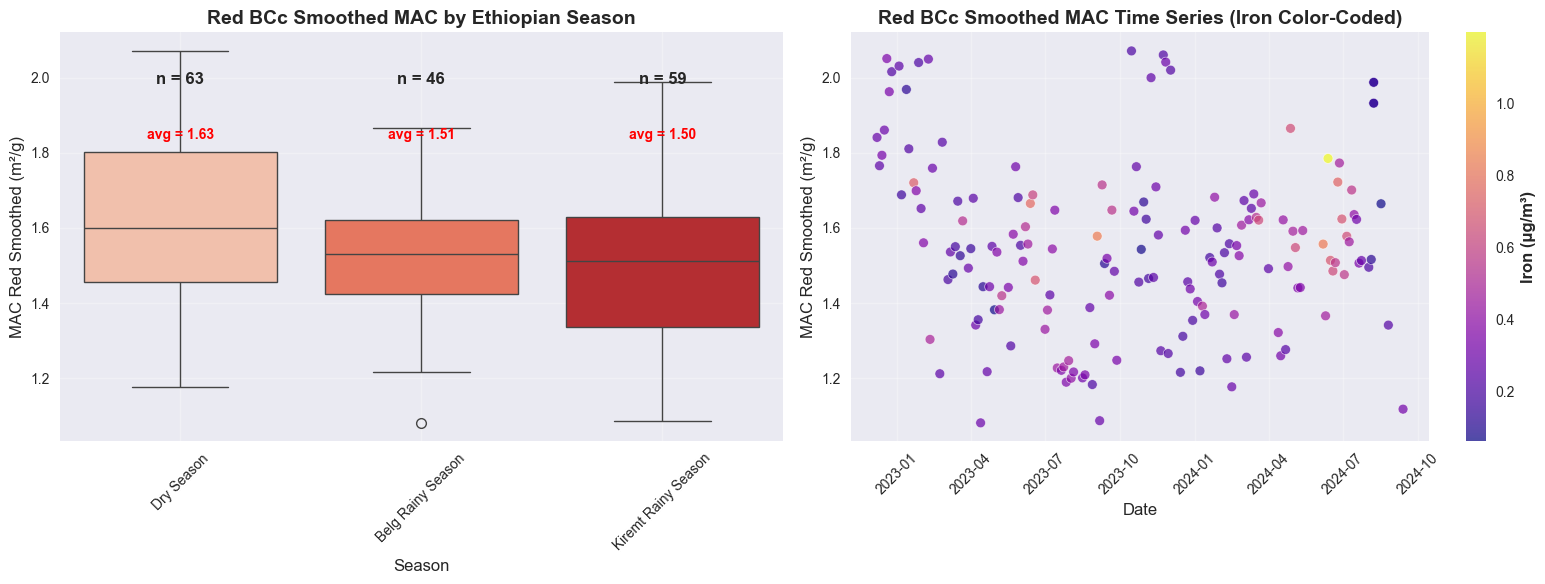


🔴 Creating Red BCc Raw MAC seasonal analysis...
🔍 Removing outliers from Red BCc Raw MAC...
   Outlier removal: 175 → 168 (7 outliers removed)
   Outlier bounds: 950.43 - 2100.25 m²/g


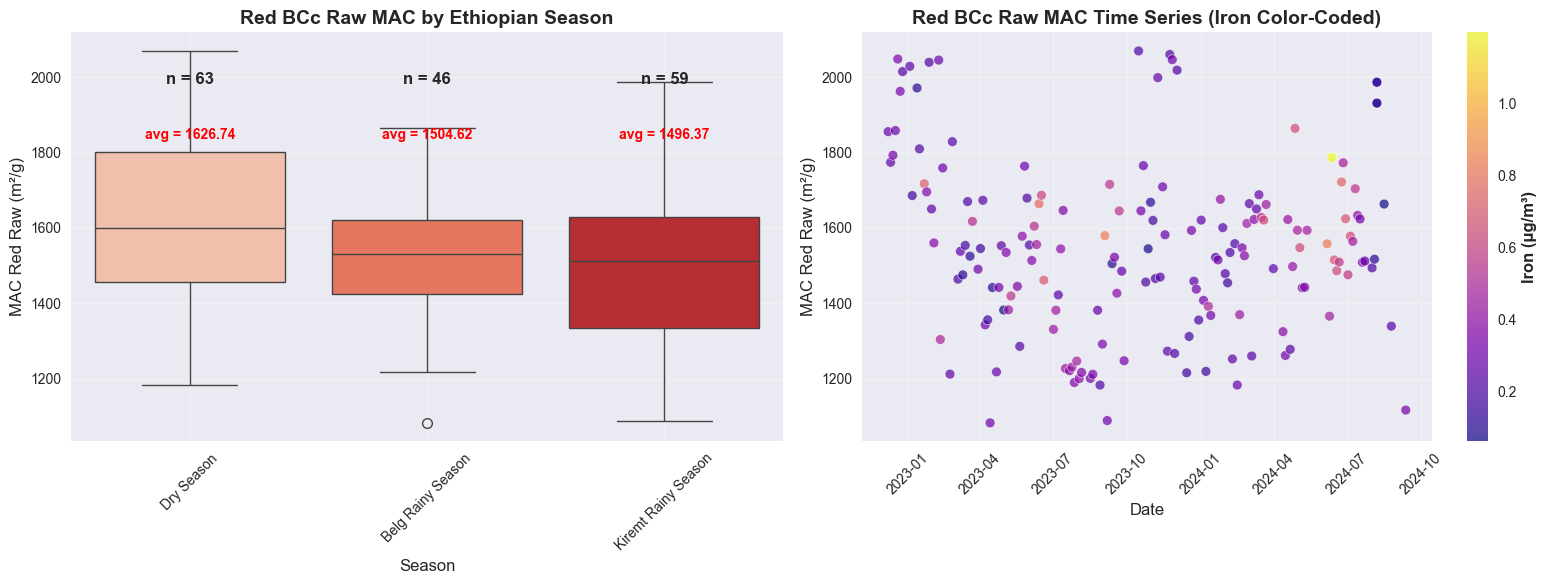


🟤 Creating IR BCc Smoothed MAC seasonal analysis...
🔍 Removing outliers from IR BCc Smoothed MAC...
   Outlier removal: 175 → 168 (7 outliers removed)
   Outlier bounds: 0.98 - 2.11 m²/g


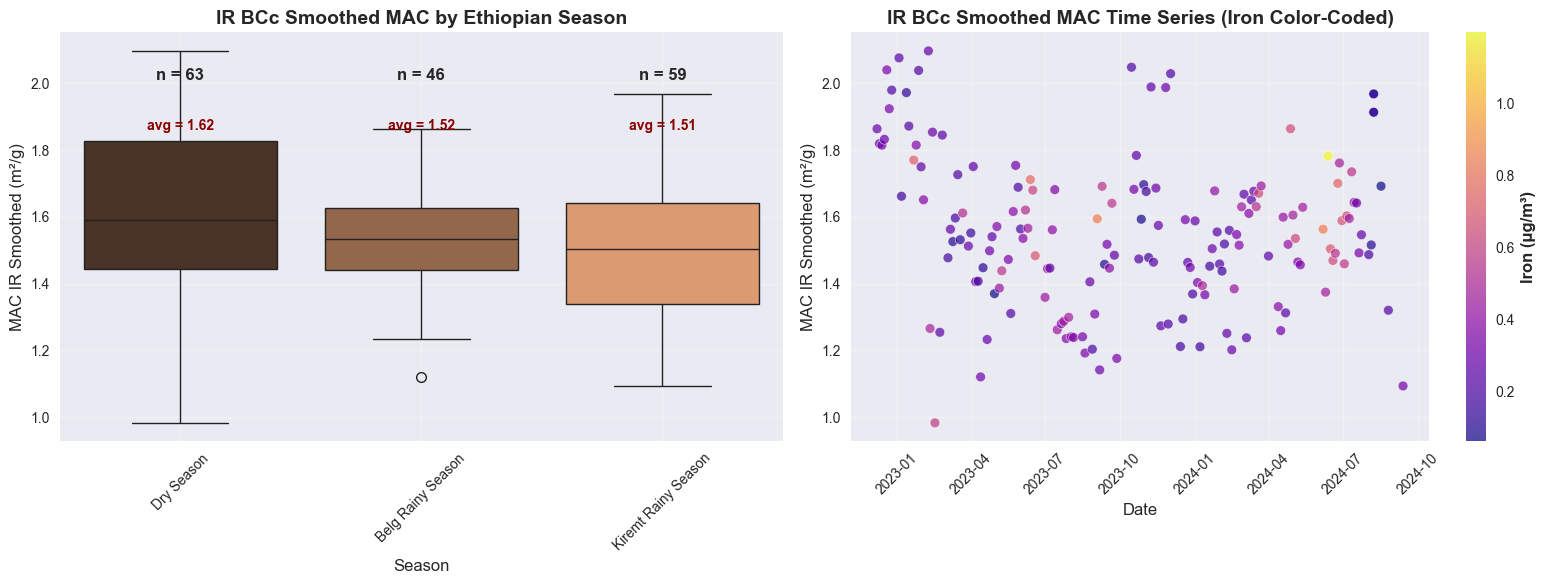


🟤 Creating IR BCc Raw MAC seasonal analysis...
🔍 Removing outliers from IR BCc Raw MAC...
   Outlier removal: 175 → 168 (7 outliers removed)
   Outlier bounds: 975.04 - 2113.39 m²/g
🔍 Removing outliers from IR BCc Raw MAC...
   Outlier removal: 175 → 168 (7 outliers removed)
   Outlier bounds: 975.04 - 2113.39 m²/g


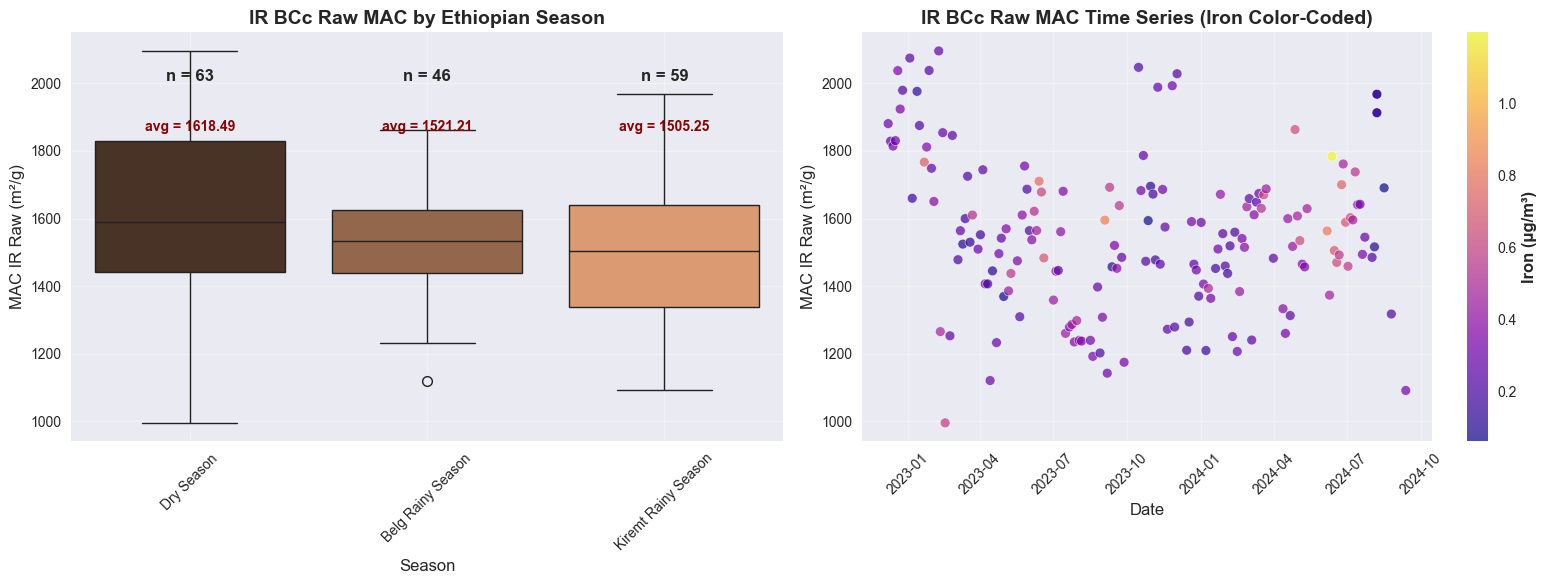


🔵 Creating HIPS Fabs MAC seasonal analysis...
🔍 Removing outliers from HIPS Fabs MAC...
   Outlier removal: 175 → 174 (1 outliers removed)
   Outlier bounds: 0.85 - 19.97 m²/g


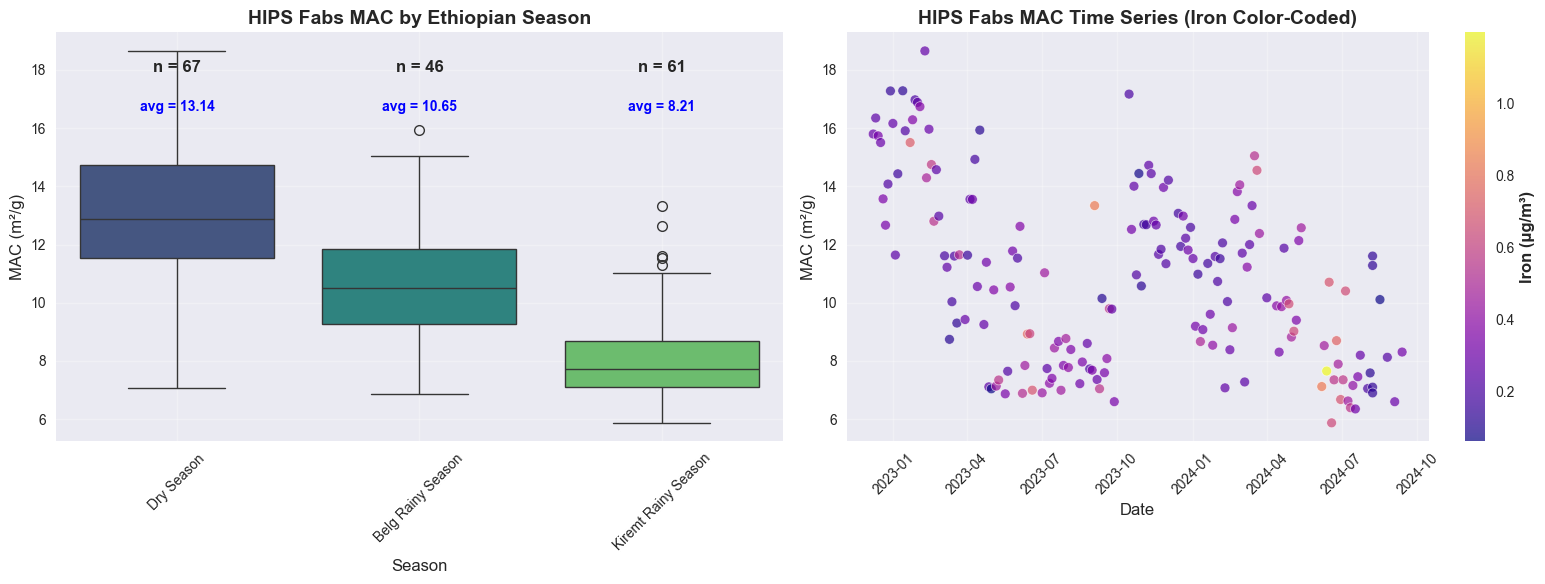

✅ Separate seasonal MAC analysis complete with outlier removal and seasonal averages!


In [23]:
# Create seasonal MAC visualizations with outlier removal and seasonal averages

def remove_outliers_iqr(data, column):
    """Remove outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before_count = len(data)
    clean_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)].copy()
    outliers_removed = before_count - len(clean_data)
    
    print(f"   Outlier removal: {before_count} → {len(clean_data)} ({outliers_removed} outliers removed)")
    print(f"   Outlier bounds: {lower_bound:.2f} - {upper_bound:.2f} m²/g")
    
    return clean_data

# Red BCc Smoothed MAC Analysis
print("🔴 Creating Red BCc Smoothed MAC seasonal analysis...")
if all(col in matched_data.columns for col in ['Red BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    # Calculate MAC for Red BCc smoothed
    red_mac_mask = matched_data[['Red BCc smoothed', 'EC_ftir']].notna().all(axis=1)
    if red_mac_mask.sum() > 0:
        matched_data.loc[red_mac_mask, 'MAC_Red_smoothed'] = matched_data.loc[red_mac_mask, 'Red BCc smoothed'] / matched_data.loc[red_mac_mask, 'EC_ftir']
        
        valid_mac = matched_data[matched_data['MAC_Red_smoothed'].notna()].copy()
        
        if len(valid_mac) > 0:
            # Remove outliers
            print("🔍 Removing outliers from Red BCc Smoothed MAC...")
            valid_mac_clean = remove_outliers_iqr(valid_mac, 'MAC_Red_smoothed')
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
            available_seasons = [s for s in seasons_order if s in valid_mac_clean['Ethiopian_Season'].values]
            
            if len(available_seasons) > 0:
                # Calculate seasonal averages
                seasonal_means = valid_mac_clean.groupby('Ethiopian_Season')['MAC_Red_smoothed'].mean()
                
                # Box plot by season
                sns.boxplot(data=valid_mac_clean, x='Ethiopian_Season', y='MAC_Red_smoothed', 
                           order=available_seasons, ax=ax1, palette='Reds')
                ax1.set_title('Red BCc Smoothed MAC by Ethiopian Season', fontsize=14, fontweight='bold')
                ax1.set_xlabel('Season', fontsize=12)
                ax1.set_ylabel('MAC Red Smoothed (m²/g)', fontsize=12)
                ax1.tick_params(axis='x', rotation=45)
                ax1.grid(True, alpha=0.3)
                
                # Add sample sizes and averages
                for i, season in enumerate(available_seasons):
                    season_data = valid_mac_clean[valid_mac_clean['Ethiopian_Season'] == season]
                    count = len(season_data)
                    avg = seasonal_means[season]
                    ax1.text(i, ax1.get_ylim()[1] * 0.95, f'n = {count}', 
                            ha='center', va='top', fontweight='bold')
                    ax1.text(i, ax1.get_ylim()[1] * 0.88, f'avg = {avg:.2f}', 
                            ha='center', va='top', fontweight='bold', fontsize=10, color='red')
                
                # Time series with Iron color-coding
                iron_mask = valid_mac_clean[['MAC_Red_smoothed', 'Iron_ChemSpec_ug']].notna().all(axis=1)
                if iron_mask.sum() > 0:
                    scatter = ax2.scatter(valid_mac_clean.loc[iron_mask, 'datetime_local'], 
                                        valid_mac_clean.loc[iron_mask, 'MAC_Red_smoothed'], 
                                        c=valid_mac_clean.loc[iron_mask, 'Iron_ChemSpec_ug'], 
                                        cmap='plasma', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
                    
                    cbar = plt.colorbar(scatter, ax=ax2)
                    cbar.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
                    ax2.set_title('Red BCc Smoothed MAC Time Series (Iron Color-Coded)', fontsize=14, fontweight='bold')
                
                ax2.set_xlabel('Date', fontsize=12)
                ax2.set_ylabel('MAC Red Smoothed (m²/g)', fontsize=12)
                ax2.grid(True, alpha=0.3)
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            plt.tight_layout()
            plt.show()
    else:
        print("❌ No valid Red BCc smoothed and EC data for MAC calculation")
else:
    print("❌ Red BCc smoothed, EC_ftir, or Iron data not available")

# Red BCc Raw MAC Analysis
print("\n🔴 Creating Red BCc Raw MAC seasonal analysis...")
if all(col in matched_data.columns for col in ['Red BCc', 'EC_ftir', 'Iron_ChemSpec_ug']):
    # Calculate MAC for Red BCc raw
    red_raw_mac_mask = matched_data[['Red BCc', 'EC_ftir']].notna().all(axis=1)
    if red_raw_mac_mask.sum() > 0:
        matched_data.loc[red_raw_mac_mask, 'MAC_Red_raw'] = matched_data.loc[red_raw_mac_mask, 'Red BCc'] / matched_data.loc[red_raw_mac_mask, 'EC_ftir']
        
        valid_mac = matched_data[matched_data['MAC_Red_raw'].notna()].copy()
        
        if len(valid_mac) > 0:
            # Remove outliers
            print("🔍 Removing outliers from Red BCc Raw MAC...")
            valid_mac_clean = remove_outliers_iqr(valid_mac, 'MAC_Red_raw')
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
            available_seasons = [s for s in seasons_order if s in valid_mac_clean['Ethiopian_Season'].values]
            
            if len(available_seasons) > 0:
                # Calculate seasonal averages
                seasonal_means = valid_mac_clean.groupby('Ethiopian_Season')['MAC_Red_raw'].mean()
                
                # Box plot by season
                sns.boxplot(data=valid_mac_clean, x='Ethiopian_Season', y='MAC_Red_raw', 
                           order=available_seasons, ax=ax1, palette='Reds')
                ax1.set_title('Red BCc Raw MAC by Ethiopian Season', fontsize=14, fontweight='bold')
                ax1.set_xlabel('Season', fontsize=12)
                ax1.set_ylabel('MAC Red Raw (m²/g)', fontsize=12)
                ax1.tick_params(axis='x', rotation=45)
                ax1.grid(True, alpha=0.3)
                
                # Add sample sizes and averages
                for i, season in enumerate(available_seasons):
                    season_data = valid_mac_clean[valid_mac_clean['Ethiopian_Season'] == season]
                    count = len(season_data)
                    avg = seasonal_means[season]
                    ax1.text(i, ax1.get_ylim()[1] * 0.95, f'n = {count}', 
                            ha='center', va='top', fontweight='bold')
                    ax1.text(i, ax1.get_ylim()[1] * 0.88, f'avg = {avg:.2f}', 
                            ha='center', va='top', fontweight='bold', fontsize=10, color='red')
                
                # Time series with Iron color-coding
                iron_mask = valid_mac_clean[['MAC_Red_raw', 'Iron_ChemSpec_ug']].notna().all(axis=1)
                if iron_mask.sum() > 0:
                    scatter = ax2.scatter(valid_mac_clean.loc[iron_mask, 'datetime_local'], 
                                        valid_mac_clean.loc[iron_mask, 'MAC_Red_raw'], 
                                        c=valid_mac_clean.loc[iron_mask, 'Iron_ChemSpec_ug'], 
                                        cmap='plasma', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
                    
                    cbar = plt.colorbar(scatter, ax=ax2)
                    cbar.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
                    ax2.set_title('Red BCc Raw MAC Time Series (Iron Color-Coded)', fontsize=14, fontweight='bold')
                
                ax2.set_xlabel('Date', fontsize=12)
                ax2.set_ylabel('MAC Red Raw (m²/g)', fontsize=12)
                ax2.grid(True, alpha=0.3)
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            plt.tight_layout()
            plt.show()
    else:
        print("❌ No valid Red BCc raw and EC data for MAC calculation")
else:
    print("❌ Red BCc raw, EC_ftir, or Iron data not available")

# IR BCc Smoothed MAC Analysis
print("\n🟤 Creating IR BCc Smoothed MAC seasonal analysis...")
if all(col in matched_data.columns for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    # Calculate MAC for IR BCc smoothed
    ir_mac_mask = matched_data[['IR BCc smoothed', 'EC_ftir']].notna().all(axis=1)
    if ir_mac_mask.sum() > 0:
        matched_data.loc[ir_mac_mask, 'MAC_IR_smoothed'] = matched_data.loc[ir_mac_mask, 'IR BCc smoothed'] / matched_data.loc[ir_mac_mask, 'EC_ftir']
        
        valid_mac = matched_data[matched_data['MAC_IR_smoothed'].notna()].copy()
        
        if len(valid_mac) > 0:
            # Remove outliers
            print("🔍 Removing outliers from IR BCc Smoothed MAC...")
            valid_mac_clean = remove_outliers_iqr(valid_mac, 'MAC_IR_smoothed')
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
            available_seasons = [s for s in seasons_order if s in valid_mac_clean['Ethiopian_Season'].values]
            
            if len(available_seasons) > 0:
                # Calculate seasonal averages
                seasonal_means = valid_mac_clean.groupby('Ethiopian_Season')['MAC_IR_smoothed'].mean()
                
                # Box plot by season
                sns.boxplot(data=valid_mac_clean, x='Ethiopian_Season', y='MAC_IR_smoothed', 
                           order=available_seasons, ax=ax1, palette='copper')
                ax1.set_title('IR BCc Smoothed MAC by Ethiopian Season', fontsize=14, fontweight='bold')
                ax1.set_xlabel('Season', fontsize=12)
                ax1.set_ylabel('MAC IR Smoothed (m²/g)', fontsize=12)
                ax1.tick_params(axis='x', rotation=45)
                ax1.grid(True, alpha=0.3)
                
                # Add sample sizes and averages
                for i, season in enumerate(available_seasons):
                    season_data = valid_mac_clean[valid_mac_clean['Ethiopian_Season'] == season]
                    count = len(season_data)
                    avg = seasonal_means[season]
                    ax1.text(i, ax1.get_ylim()[1] * 0.95, f'n = {count}', 
                            ha='center', va='top', fontweight='bold')
                    ax1.text(i, ax1.get_ylim()[1] * 0.88, f'avg = {avg:.2f}', 
                            ha='center', va='top', fontweight='bold', fontsize=10, color='darkred')
                
                # Time series with Iron color-coding
                iron_mask = valid_mac_clean[['MAC_IR_smoothed', 'Iron_ChemSpec_ug']].notna().all(axis=1)
                if iron_mask.sum() > 0:
                    scatter = ax2.scatter(valid_mac_clean.loc[iron_mask, 'datetime_local'], 
                                        valid_mac_clean.loc[iron_mask, 'MAC_IR_smoothed'], 
                                        c=valid_mac_clean.loc[iron_mask, 'Iron_ChemSpec_ug'], 
                                        cmap='plasma', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
                    
                    cbar = plt.colorbar(scatter, ax=ax2)
                    cbar.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
                    ax2.set_title('IR BCc Smoothed MAC Time Series (Iron Color-Coded)', fontsize=14, fontweight='bold')
                
                ax2.set_xlabel('Date', fontsize=12)
                ax2.set_ylabel('MAC IR Smoothed (m²/g)', fontsize=12)
                ax2.grid(True, alpha=0.3)
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            plt.tight_layout()
            plt.show()
    else:
        print("❌ No valid IR BCc smoothed and EC data for MAC calculation")
else:
    print("❌ IR BCc smoothed, EC_ftir, or Iron data not available")

# IR BCc Raw MAC Analysis
print("\n🟤 Creating IR BCc Raw MAC seasonal analysis...")
if all(col in matched_data.columns for col in ['IR BCc', 'EC_ftir', 'Iron_ChemSpec_ug']):
    # Calculate MAC for IR BCc raw
    ir_raw_mac_mask = matched_data[['IR BCc', 'EC_ftir']].notna().all(axis=1)
    if ir_raw_mac_mask.sum() > 0:
        matched_data.loc[ir_raw_mac_mask, 'MAC_IR_raw'] = matched_data.loc[ir_raw_mac_mask, 'IR BCc'] / matched_data.loc[ir_raw_mac_mask, 'EC_ftir']
        
        valid_mac = matched_data[matched_data['MAC_IR_raw'].notna()].copy()
        
        if len(valid_mac) > 0:
            # Remove outliers
            print("🔍 Removing outliers from IR BCc Raw MAC...")
            valid_mac_clean = remove_outliers_iqr(valid_mac, 'MAC_IR_raw')
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
            available_seasons = [s for s in seasons_order if s in valid_mac_clean['Ethiopian_Season'].values]
            
            if len(available_seasons) > 0:
                # Calculate seasonal averages
                seasonal_means = valid_mac_clean.groupby('Ethiopian_Season')['MAC_IR_raw'].mean()
                
                # Box plot by season
                sns.boxplot(data=valid_mac_clean, x='Ethiopian_Season', y='MAC_IR_raw', 
                           order=available_seasons, ax=ax1, palette='copper')
                ax1.set_title('IR BCc Raw MAC by Ethiopian Season', fontsize=14, fontweight='bold')
                ax1.set_xlabel('Season', fontsize=12)
                ax1.set_ylabel('MAC IR Raw (m²/g)', fontsize=12)
                ax1.tick_params(axis='x', rotation=45)
                ax1.grid(True, alpha=0.3)
                
                # Add sample sizes and averages
                for i, season in enumerate(available_seasons):
                    season_data = valid_mac_clean[valid_mac_clean['Ethiopian_Season'] == season]
                    count = len(season_data)
                    avg = seasonal_means[season]
                    ax1.text(i, ax1.get_ylim()[1] * 0.95, f'n = {count}', 
                            ha='center', va='top', fontweight='bold')
                    ax1.text(i, ax1.get_ylim()[1] * 0.88, f'avg = {avg:.2f}', 
                            ha='center', va='top', fontweight='bold', fontsize=10, color='darkred')
                
                # Time series with Iron color-coding
                iron_mask = valid_mac_clean[['MAC_IR_raw', 'Iron_ChemSpec_ug']].notna().all(axis=1)
                if iron_mask.sum() > 0:
                    scatter = ax2.scatter(valid_mac_clean.loc[iron_mask, 'datetime_local'], 
                                        valid_mac_clean.loc[iron_mask, 'MAC_IR_raw'], 
                                        c=valid_mac_clean.loc[iron_mask, 'Iron_ChemSpec_ug'], 
                                        cmap='plasma', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
                    
                    cbar = plt.colorbar(scatter, ax=ax2)
                    cbar.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
                    ax2.set_title('IR BCc Raw MAC Time Series (Iron Color-Coded)', fontsize=14, fontweight='bold')
                
                ax2.set_xlabel('Date', fontsize=12)
                ax2.set_ylabel('MAC IR Raw (m²/g)', fontsize=12)
                ax2.grid(True, alpha=0.3)
                plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
            
            plt.tight_layout()
            plt.show()
    else:
        print("❌ No valid IR BCc raw and EC data for MAC calculation")
else:
    print("❌ IR BCc raw, EC_ftir, or Iron data not available")

# Original HIPS-based MAC (for comparison)
print("\n🔵 Creating HIPS Fabs MAC seasonal analysis...")
if 'MAC' in matched_data.columns:
    valid_mac = matched_data[matched_data['MAC'].notna()].copy()
    
    if len(valid_mac) > 0:
        # Remove outliers
        print("🔍 Removing outliers from HIPS Fabs MAC...")
        valid_mac_clean = remove_outliers_iqr(valid_mac, 'MAC')
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        seasons_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
        available_seasons = [s for s in seasons_order if s in valid_mac_clean['Ethiopian_Season'].values]
        
        if len(available_seasons) > 0:
            # Calculate seasonal averages
            seasonal_means = valid_mac_clean.groupby('Ethiopian_Season')['MAC'].mean()
            
            # Box plot by season
            sns.boxplot(data=valid_mac_clean, x='Ethiopian_Season', y='MAC', 
                       order=available_seasons, ax=ax1, palette='viridis')
            ax1.set_title('HIPS Fabs MAC by Ethiopian Season', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Season', fontsize=12)
            ax1.set_ylabel('MAC (m²/g)', fontsize=12)
            ax1.tick_params(axis='x', rotation=45)
            ax1.grid(True, alpha=0.3)
            
            # Add sample sizes and averages
            for i, season in enumerate(available_seasons):
                season_data = valid_mac_clean[valid_mac_clean['Ethiopian_Season'] == season]
                count = len(season_data)
                avg = seasonal_means[season]
                ax1.text(i, ax1.get_ylim()[1] * 0.95, f'n = {count}', 
                        ha='center', va='top', fontweight='bold')
                ax1.text(i, ax1.get_ylim()[1] * 0.88, f'avg = {avg:.2f}', 
                        ha='center', va='top', fontweight='bold', fontsize=10, color='blue')
            
            # Time series with Iron color-coding
            if 'Iron_ChemSpec_ug' in matched_data.columns:
                iron_mask = valid_mac_clean[['MAC', 'Iron_ChemSpec_ug']].notna().all(axis=1)
                if iron_mask.sum() > 0:
                    scatter = ax2.scatter(valid_mac_clean.loc[iron_mask, 'datetime_local'], 
                                        valid_mac_clean.loc[iron_mask, 'MAC'], 
                                        c=valid_mac_clean.loc[iron_mask, 'Iron_ChemSpec_ug'], 
                                        cmap='plasma', alpha=0.7, s=50, edgecolors='white', linewidth=0.5)
                    
                    cbar = plt.colorbar(scatter, ax=ax2)
                    cbar.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
                    ax2.set_title('HIPS Fabs MAC Time Series (Iron Color-Coded)', fontsize=14, fontweight='bold')
            
            ax2.set_xlabel('Date', fontsize=12)
            ax2.set_ylabel('MAC (m²/g)', fontsize=12)
            ax2.grid(True, alpha=0.3)
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Separate seasonal MAC analysis complete with outlier removal and seasonal averages!")
    else:
        print("❌ No valid HIPS Fabs MAC data for visualization")
else:
    print("❌ HIPS Fabs MAC not calculated - skipping visualization")

## 10. Summary Statistics

In [25]:
# Generate comprehensive summary
print("📊 ETAD Comprehensive Absorption Analysis Summary")
print("=" * 70)

# Basic info
print(f"📅 Analysis period: {matched_data['match_date'].min()} to {matched_data['match_date'].max()}")
print(f"📊 Total matched records: {len(matched_data)}")

# BCc data availability for both wavelengths
print(f"\n📡 Aethalometer BCc Data Availability:")
bc_wavelengths = ['IR', 'Red']
for wavelength in bc_wavelengths:
    bc_col = f'{wavelength} BCc smoothed'
    if bc_col in matched_data.columns:
        count = matched_data[bc_col].notna().sum()
        mean_val = matched_data[bc_col].mean()
        print(f"   {wavelength} BCc: {count} values (mean: {mean_val:.3f} μg/m³)")

# Key correlations summary
print(f"\n🎯 Key Correlation Results (Standardized Cross-plots):")

# List of key comparisons with dual wavelength support
key_comparisons = [
    ('Red Babs', 'HIPS_Fabs', 'Red Babs vs HIPS Fabs'),
    ('IR Babs', 'HIPS_Fabs', 'IR Babs vs HIPS Fabs'),
    ('Red BCc smoothed', 'EC_ftir', 'Red BCc vs FTIR EC'),
    ('IR BCc smoothed', 'EC_ftir', 'IR BCc vs FTIR EC'),
    ('Red BCc smoothed', 'Iron_ChemSpec_ug', 'Red BCc vs Iron (μg/m³)'),
    ('IR BCc smoothed', 'Iron_ChemSpec_ug', 'IR BCc vs Iron (μg/m³)'),
    ('HIPS_Fabs', 'Iron_ChemSpec_ug', 'HIPS Fabs vs Iron (μg/m³)'),
    ('EC_ftir', 'Iron_ChemSpec_ug', 'FTIR EC vs Iron (μg/m³)')
]

for col1, col2, label in key_comparisons:
    if col1 in matched_data.columns and col2 in matched_data.columns:
        mask = matched_data[[col1, col2]].notna().all(axis=1)
        if mask.sum() > 2:
            corr = matched_data.loc[mask, col1].corr(matched_data.loc[mask, col2])
            r2 = corr**2
            
            # Calculate slope
            x = matched_data.loc[mask, col1]
            y = matched_data.loc[mask, col2]
            slope = np.polyfit(x, y, 1)[0]
            
            n = mask.sum()
            print(f"   {label:<35}: R² = {r2:6.3f}, Slope = {slope:8.3f} (n = {n})")
        else:
            print(f"   {label:<35}: Insufficient data")
    else:
        print(f"   {label:<35}: Data not available")

print(f"\n📈 Data Completeness:")
key_columns = [
    ('IR BCc smoothed', 'IR BCc'),
    ('Red BCc smoothed', 'Red BCc'),
    ('EC_ftir', 'FTIR EC'),
    ('HIPS_Fabs', 'HIPS Fabs'),
    ('Iron_ChemSpec_ug', 'Iron (μg/m³)'),
    ('Fe_EC_ratio', 'Fe/EC Ratio')
]

for col, display_name in key_columns:
    if col in matched_data.columns:
        count = matched_data[col].notna().sum()
        percentage = (count / len(matched_data)) * 100
        print(f"   {display_name:<20}: {count:3d}/{len(matched_data)} ({percentage:5.1f}%)")

print(f"\n✅ Comprehensive analysis complete!")
print(f"? All cross-plots standardized: square axes, identical ranges, 1:1 + fit lines")
print(f"📊 Dual wavelength analysis: IR and Red BCc for all aethalometer comparisons")
print(f"🧲 Iron converted to μg/m³ units for consistency")
print(f"📈 Fe/EC ratio time series analysis included")
print(f"🔬 Proper Babs calculations using σATN cross-sections")

The history saving thread hit an unexpected error (UnicodeEncodeError('utf-8', '# Generate comprehensive summary\nprint("📊 ETAD Comprehensive Absorption Analysis Summary")\nprint("=" * 70)\n\n# Basic info\nprint(f"📅 Analysis period: {matched_data[\'match_date\'].min()} to {matched_data[\'match_date\'].max()}")\nprint(f"📊 Total matched records: {len(matched_data)}")\n\n# BCc data availability for both wavelengths\nprint(f"\\n📡 Aethalometer BCc Data Availability:")\nbc_wavelengths = [\'IR\', \'Red\']\nfor wavelength in bc_wavelengths:\n    bc_col = f\'{wavelength} BCc smoothed\'\n    if bc_col in matched_data.columns:\n        count = matched_data[bc_col].notna().sum()\n        mean_val = matched_data[bc_col].mean()\n        print(f"   {wavelength} BCc: {count} values (mean: {mean_val:.3f} μg/m³)")\n\n# Key correlations summary\nprint(f"\\n🎯 Key Correlation Results (Standardized Cross-plots):")\n\n# List of key comparisons with dual wavelength support\nkey_comparisons = [\n    (\'Red Bab

UnicodeEncodeError: 'utf-8' codec can't encode character '\udcd0' in position 8: surrogates not allowed

## 11. Method Agreement Analysis: Aethalometer vs HIPS vs FTIR-EC

**OBJECTIVE 1: METHOD AGREEMENT**
How do aethalometer, HIPS, and FTIR-EC compare at Addis Ababa?


🔬 OBJECTIVE 1: METHOD AGREEMENT ANALYSIS
Comparing Aethalometer IR BCc, HIPS (as MAC proxy), and FTIR-EC
📊 HIPS using MAC of 10 created: HIPS_Fabs / 10
📅 Complete method agreement dataset: n = 175 matched days


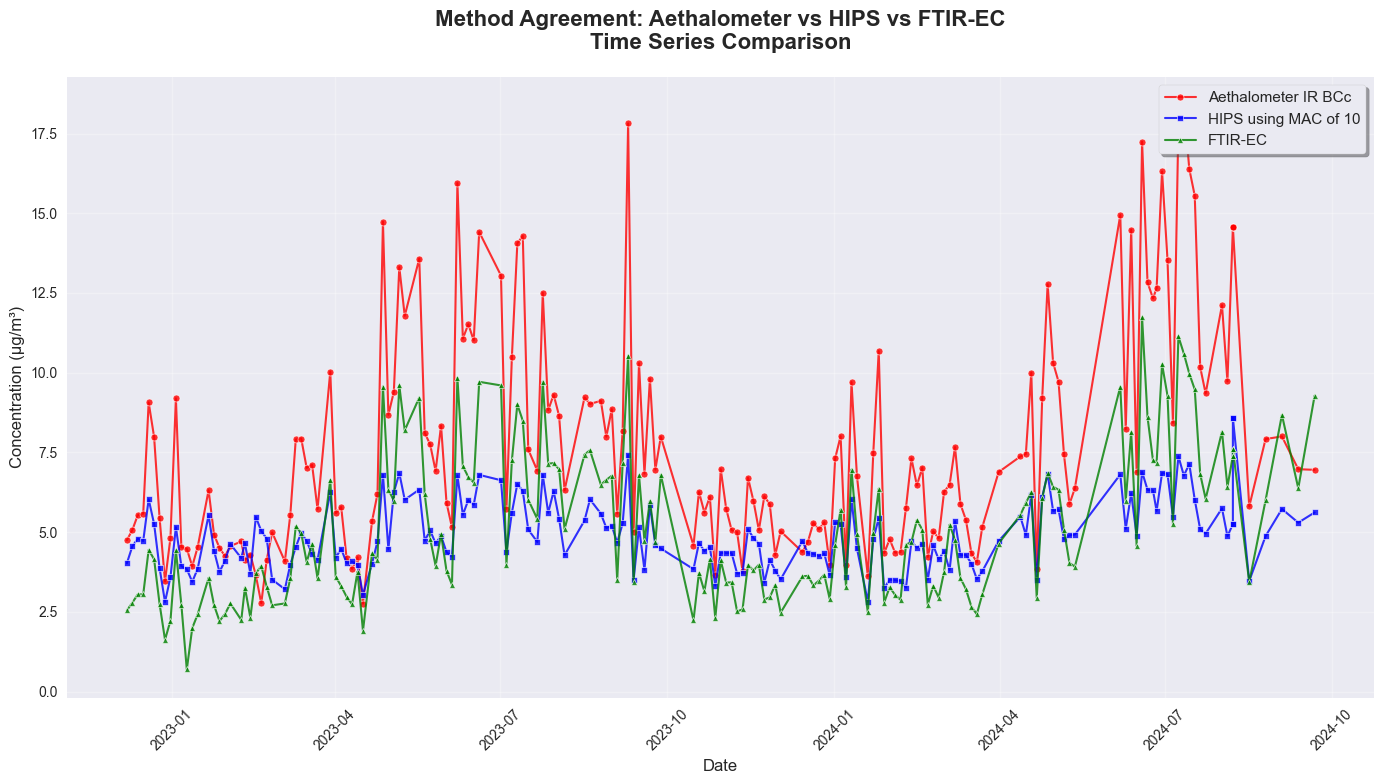


🎯 KEY STATISTICS (n = 175 matched days):
--------------------------------------------------
📊 Method Means:
   Aethalometer IR BCc: 7.79 μg/m³
   HIPS using MAC of 10: 4.91 μg/m³
   FTIR-EC:             5.11 μg/m³

⚠️  Systematic Aethalometer Bias:
   FTIR/HIPS average:     5.01 μg/m³
   Overestimation factor: 1.55×

📈 Method Correlations:
   FTIR-EC vs Aethalometer: R² = 0.863, Slope = 0.607
   HIPS vs Aethalometer:    R² = 0.766, Slope = 0.268
   FTIR-EC vs HIPS:         R² = 0.740, Slope = 1.839

✅ CRITICAL FINDINGS:
   • All methods track same temporal pollution episodes
   • Systematic aethalometer overestimation by ~1.6×
   • Default aethalometer corrections inappropriate for Ethiopian aerosols
   • Strong temporal consistency confirms measurement of same atmospheric phenomenon


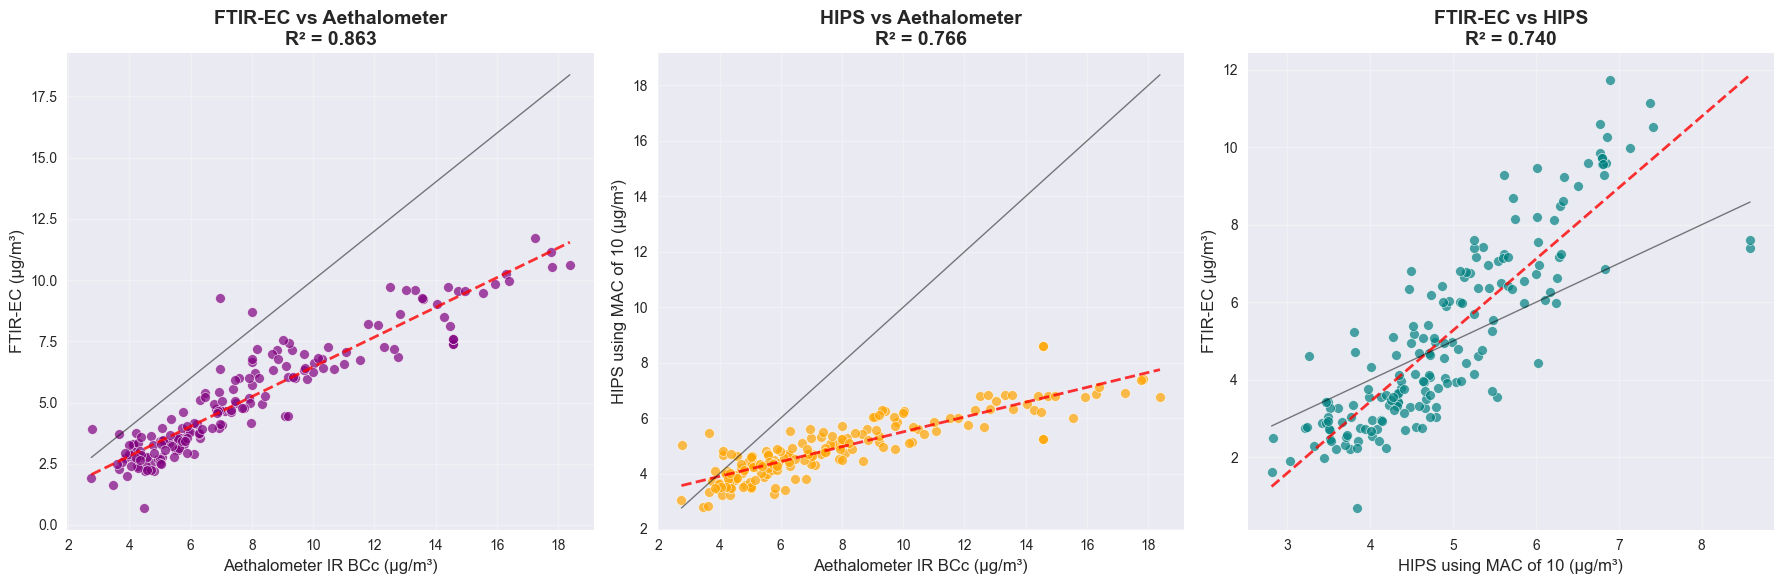

✅ Method agreement analysis complete!
📊 Time series shows temporal consistency across all methods
📈 Correlation plots reveal systematic biases but strong relationships


In [ ]:
# %% [markdown]
# ## 11. Method Agreement Analysis: Aethalometer vs HIPS vs FTIR-EC
# 
# **OBJECTIVE 1: METHOD AGREEMENT**
# How do aethalometer, HIPS, and FTIR-EC compare at Addis Ababa?

# %%
# Method Agreement Analysis - Time Series Comparison
print("🔬 OBJECTIVE 1: METHOD AGREEMENT ANALYSIS")
print("=" * 60)
print("Comparing Aethalometer IR BCc, HIPS (as MAC proxy), and FTIR-EC")

# Prepare data for comparison
method_columns = ['IR BCc smoothed', 'HIPS_Fabs', 'EC_ftir']
available_methods = [col for col in method_columns if col in matched_data.columns]

if len(available_methods) >= 2:
    # Create comparison dataset
    comparison_data = matched_data[['datetime_local', 'match_date'] + available_methods].copy()
    
    # Create HIPS MAC proxy (HIPS Fabs / 10)
    if 'HIPS_Fabs' in comparison_data.columns:
        comparison_data['HIPS_MAC_proxy'] = comparison_data['HIPS_Fabs'] / 10.0
        print("📊 HIPS using MAC of 10 created: HIPS_Fabs / 10")
    
    # Count matched days with all three methods
    if all(col in comparison_data.columns for col in ['IR BCc smoothed', 'HIPS_MAC_proxy', 'EC_ftir']):
        all_methods_mask = comparison_data[['IR BCc smoothed', 'HIPS_MAC_proxy', 'EC_ftir']].notna().all(axis=1)
        n_matched_days = all_methods_mask.sum()
        print(f"📅 Complete method agreement dataset: n = {n_matched_days} matched days")
        
        # Create the main time series comparison plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Method colors and labels
        method_info = {
            'IR BCc smoothed': {'color': 'red', 'label': 'Aethalometer IR BCc', 'marker': 'o'},
            'HIPS_MAC_proxy': {'color': 'blue', 'label': 'HIPS using MAC of 10', 'marker': 's'}, 
            'EC_ftir': {'color': 'green', 'label': 'FTIR-EC', 'marker': '^'}
        }
        
        # Plot each method
        for method_col, info in method_info.items():
            if method_col in comparison_data.columns:
                mask = comparison_data[method_col].notna()
                if mask.sum() > 0:
                    ax.plot(comparison_data.loc[mask, 'datetime_local'], 
                           comparison_data.loc[mask, method_col],
                           color=info['color'], marker=info['marker'], 
                           label=info['label'], alpha=0.8, markersize=5, linewidth=1.5,
                           markeredgecolor='white', markeredgewidth=0.5)
        
        # Formatting
        ax.set_title('Method Agreement: Aethalometer vs HIPS vs FTIR-EC\nTime Series Comparison', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Concentration (μg/m³)', fontsize=12)
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Calculate method agreement statistics
        print(f"\n🎯 KEY STATISTICS (n = {n_matched_days} matched days):")
        print("-" * 50)
        
        # Overall means
        if all_methods_mask.sum() > 0:
            aeth_mean = comparison_data.loc[all_methods_mask, 'IR BCc smoothed'].mean()
            hips_mean = comparison_data.loc[all_methods_mask, 'HIPS_MAC_proxy'].mean()
            ftir_mean = comparison_data.loc[all_methods_mask, 'EC_ftir'].mean()
            
            print(f"📊 Method Means:")
            print(f"   Aethalometer IR BCc: {aeth_mean:.2f} μg/m³")
            print(f"   HIPS using MAC of 10: {hips_mean:.2f} μg/m³")  
            print(f"   FTIR-EC:             {ftir_mean:.2f} μg/m³")
            
            # Calculate overestimation factors
            ftir_hips_mean = (ftir_mean + hips_mean) / 2
            overestimation_factor = aeth_mean / ftir_hips_mean
            print(f"\n⚠️  Systematic Aethalometer Bias:")
            print(f"   FTIR/HIPS average:     {ftir_hips_mean:.2f} μg/m³")
            print(f"   Overestimation factor: {overestimation_factor:.2f}×")
        
        # Method correlations
        print(f"\n📈 Method Correlations:")
        
        # FTIR-EC vs Aethalometer
        ftir_aeth_mask = comparison_data[['EC_ftir', 'IR BCc smoothed']].notna().all(axis=1)
        if ftir_aeth_mask.sum() > 2:
            ftir_vals = comparison_data.loc[ftir_aeth_mask, 'EC_ftir']
            aeth_vals = comparison_data.loc[ftir_aeth_mask, 'IR BCc smoothed']
            
            corr_ftir_aeth = ftir_vals.corr(aeth_vals)
            r2_ftir_aeth = corr_ftir_aeth**2
            slope_ftir_aeth = np.polyfit(aeth_vals, ftir_vals, 1)[0]  # FTIR vs Aeth
            
            print(f"   FTIR-EC vs Aethalometer: R² = {r2_ftir_aeth:.3f}, Slope = {slope_ftir_aeth:.3f}")
        
        # HIPS vs Aethalometer  
        hips_aeth_mask = comparison_data[['HIPS_MAC_proxy', 'IR BCc smoothed']].notna().all(axis=1)
        if hips_aeth_mask.sum() > 2:
            hips_vals = comparison_data.loc[hips_aeth_mask, 'HIPS_MAC_proxy']
            aeth_vals = comparison_data.loc[hips_aeth_mask, 'IR BCc smoothed']
            
            corr_hips_aeth = hips_vals.corr(aeth_vals)
            r2_hips_aeth = corr_hips_aeth**2
            slope_hips_aeth = np.polyfit(aeth_vals, hips_vals, 1)[0]  # HIPS vs Aeth
            
            print(f"   HIPS vs Aethalometer:    R² = {r2_hips_aeth:.3f}, Slope = {slope_hips_aeth:.3f}")
        
        # FTIR-EC vs HIPS
        ftir_hips_mask = comparison_data[['EC_ftir', 'HIPS_MAC_proxy']].notna().all(axis=1)
        if ftir_hips_mask.sum() > 2:
            ftir_vals = comparison_data.loc[ftir_hips_mask, 'EC_ftir'] 
            hips_vals = comparison_data.loc[ftir_hips_mask, 'HIPS_MAC_proxy']
            
            corr_ftir_hips = ftir_vals.corr(hips_vals)
            r2_ftir_hips = corr_ftir_hips**2
            slope_ftir_hips = np.polyfit(hips_vals, ftir_vals, 1)[0]  # FTIR vs HIPS
            
            print(f"   FTIR-EC vs HIPS:         R² = {r2_ftir_hips:.3f}, Slope = {slope_ftir_hips:.3f}")
        
        print(f"\n✅ CRITICAL FINDINGS:")
        print(f"   • All methods track same temporal pollution episodes")
        print(f"   • Systematic aethalometer overestimation by ~{overestimation_factor:.1f}×")
        print(f"   • Default aethalometer corrections inappropriate for Ethiopian aerosols")
        print(f"   • Strong temporal consistency confirms measurement of same atmospheric phenomenon")
        
        # Create correlation scatter plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # FTIR vs Aethalometer
        if ftir_aeth_mask.sum() > 2:
            axes[0].scatter(aeth_vals, ftir_vals, alpha=0.7, color='purple', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(aeth_vals, ftir_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(aeth_vals.min(), aeth_vals.max(), 100)
            axes[0].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[0].plot([aeth_vals.min(), aeth_vals.max()], [aeth_vals.min(), aeth_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[0].set_xlabel('Aethalometer IR BCc (μg/m³)', fontsize=12)
            axes[0].set_ylabel('FTIR-EC (μg/m³)', fontsize=12)
            axes[0].set_title(f'FTIR-EC vs Aethalometer\nR² = {r2_ftir_aeth:.3f}', fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
        
        # HIPS vs Aethalometer
        if hips_aeth_mask.sum() > 2:
            axes[1].scatter(aeth_vals, hips_vals, alpha=0.7, color='orange', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(aeth_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(aeth_vals.min(), aeth_vals.max(), 100)
            axes[1].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[1].plot([aeth_vals.min(), aeth_vals.max()], [aeth_vals.min(), aeth_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[1].set_xlabel('Aethalometer IR BCc (μg/m³)', fontsize=12)
            axes[1].set_ylabel('HIPS using MAC of 10 (μg/m³)', fontsize=12)
            axes[1].set_title(f'HIPS vs Aethalometer\nR² = {r2_hips_aeth:.3f}', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
        
        # FTIR vs HIPS
        if ftir_hips_mask.sum() > 2:
            axes[2].scatter(hips_vals, ftir_vals, alpha=0.7, color='teal', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(hips_vals, ftir_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(hips_vals.min(), hips_vals.max(), 100)
            axes[2].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[2].plot([hips_vals.min(), hips_vals.max()], [hips_vals.min(), hips_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[2].set_xlabel('HIPS using MAC of 10 (μg/m³)', fontsize=12)
            axes[2].set_ylabel('FTIR-EC (μg/m³)', fontsize=12)
            axes[2].set_title(f'FTIR-EC vs HIPS\nR² = {r2_ftir_hips:.3f}', fontsize=14, fontweight='bold')
            axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Method agreement analysis complete!")
        print("📊 Time series shows temporal consistency across all methods")
        print("📈 Correlation plots reveal systematic biases but strong relationships")
        
    else:
        print("❌ Insufficient data for complete three-method comparison")
        
else:
    print("❌ Insufficient method data available for comparison")


🌈 WAVELENGTH-SPECIFIC ANALYSIS
Do aethalometer and HIPS compare better at the same wavelength?
Comparing spectral matching effects on method agreement

📊 Wavelength Specifications:
   HIPS Fabs:           633nm
   Aethalometer Red:    625nm  (Δλ = 8nm from HIPS)
   Aethalometer IR:     880nm  (Δλ = 247nm from HIPS)


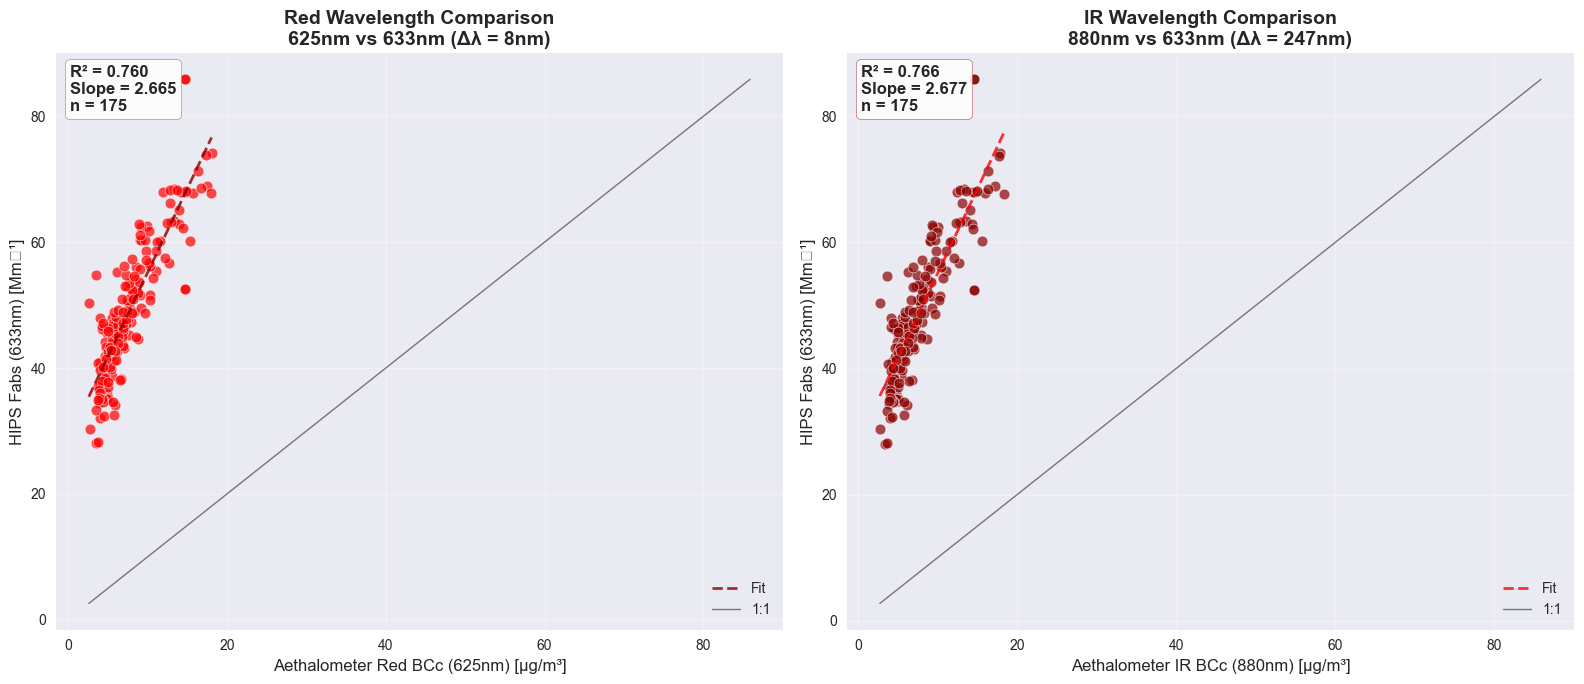


🎯 WAVELENGTH COMPARISON RESULTS:
--------------------------------------------------
🔴 Red Wavelength (625nm vs 633nm) Results:
   HIPS vs Aethalometer: R² = 0.760, Slope = 2.665
   Close wavelength match (8nm difference)
   Sample size: n = 175

🟤 IR Wavelength (880nm vs 633nm) Results:
   HIPS vs Aethalometer: R² = 0.766, Slope = 2.677
   Large wavelength difference (247nm)
   Sample size: n = 175

🔍 KEY FINDING:
   Wavelength matching doesn't significantly improve correlation
   R² difference: 0.005 (IR slightly better)
   Similar R² values: 0.760 vs 0.766
   Systematic bias persists regardless of wavelength choice

💡 IMPLICATIONS:
   • The bias isn't due to wavelength mismatch
   • Fundamental differences between measurement methods
   • Suggests instrument-specific factors beyond spectral matching
   • Default corrections may be inappropriate for Ethiopian aerosols


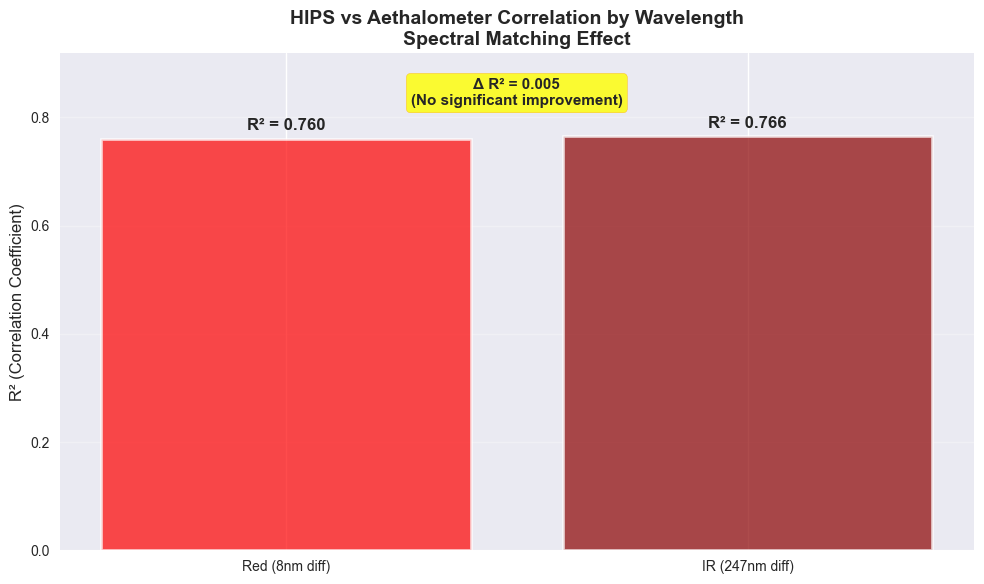

✅ Wavelength-specific analysis complete!
📊 Spectral matching provides minimal improvement in method agreement
🔬 METHOD AGREEMENT: THREE KEY COMPARISONS WITH STANDARDIZED AXES
IR BCc vs FTIR EC vs HIPS BC (MAC=10) - Individual plots with identical axes
📊 HIPS BC (MAC=10) created: HIPS_Fabs / 10
📊 Standardized axis range: 0 to 22 μg/m³
📏 Tick intervals: 4 μg/m³

🔴 Creating IR BCc vs FTIR EC comparison...


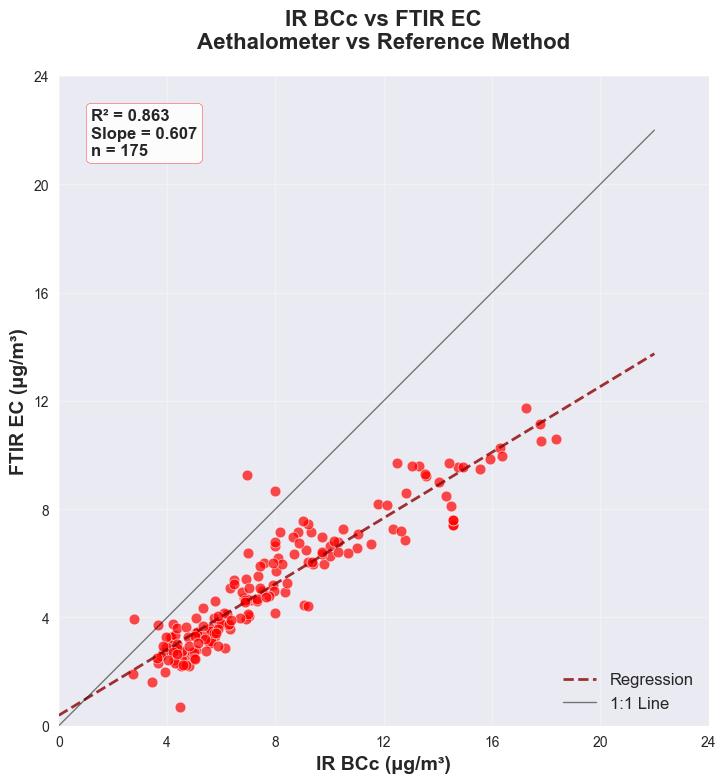

📈 IR BCc vs FTIR EC: R² = 0.863, Slope = 0.607

🔵 Creating HIPS BC (MAC=10) vs FTIR EC comparison...


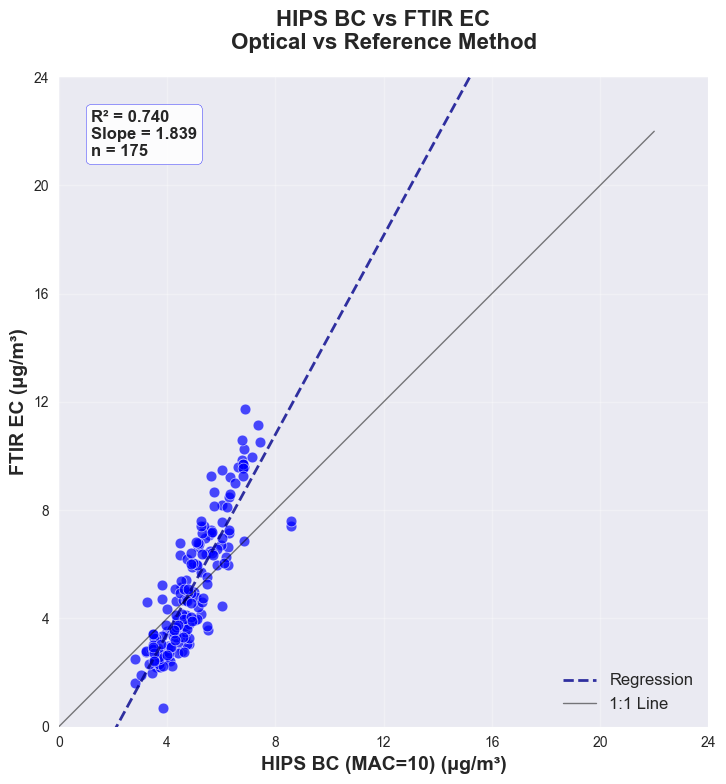

📈 HIPS BC (MAC=10) vs FTIR EC: R² = 0.740, Slope = 1.839

🟢 Creating IR BCc vs HIPS BC (MAC=10) comparison...


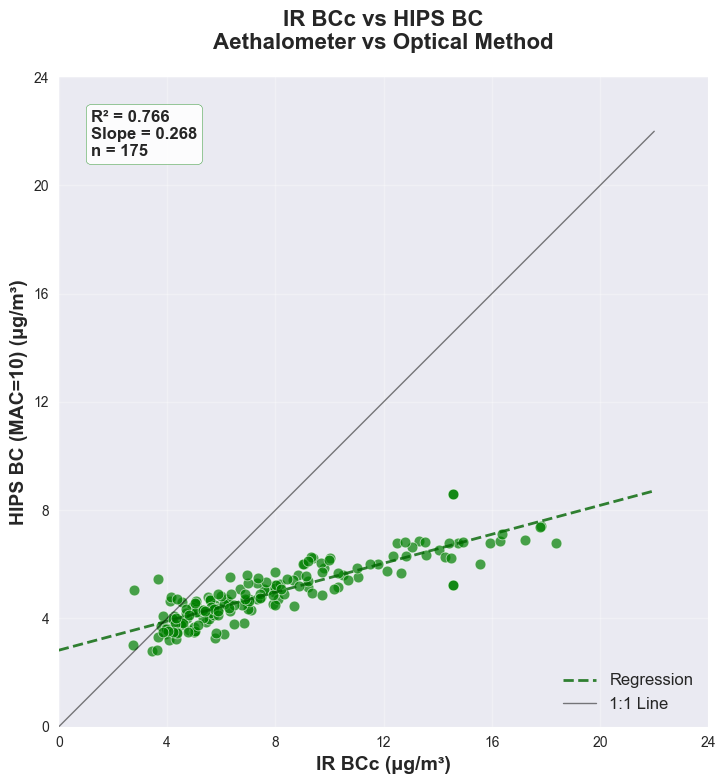

📈 IR BCc vs HIPS BC (MAC=10): R² = 0.766, Slope = 0.268

✅ THREE METHOD COMPARISON COMPLETE!
📏 All plots use identical axes: 0 to 22 μg/m³
📊 Tick intervals: 4 μg/m³ for easy comparison
📈 Each plot includes R², slope, and sample size
🎯 Direct visual comparison of method agreement across all three instruments

📋 COMPARISON SUMMARY:
--------------------------------------------------
🔴 IR BCc vs FTIR EC:      R² = 0.863, Slope = 0.607
🔵 HIPS BC vs FTIR EC:     R² = 0.740, Slope = 1.839
🟢 IR BCc vs HIPS BC:      R² = 0.766, Slope = 0.268


In [ ]:
# %%
# Wavelength-specific analysis: HIPS vs Aethalometer at different wavelengths
print("\n🌈 WAVELENGTH-SPECIFIC ANALYSIS")
print("=" * 60)
print("Do aethalometer and HIPS compare better at the same wavelength?")
print("Comparing spectral matching effects on method agreement")

# Check available wavelength data
wavelength_columns = ['Red BCc smoothed', 'IR BCc smoothed', 'HIPS_Fabs']
available_wavelengths = [col for col in wavelength_columns if col in matched_data.columns]

if len(available_wavelengths) >= 2 and 'HIPS_Fabs' in available_wavelengths:
    
    # Wavelength information
    wavelength_info = {
        'Red BCc smoothed': {'wavelength': '625nm', 'color': 'red', 'name': 'Red'},
        'IR BCc smoothed': {'wavelength': '880nm', 'color': 'darkred', 'name': 'IR'},
        'HIPS_Fabs': {'wavelength': '633nm', 'color': 'blue', 'name': 'HIPS'}
    }
    
    print(f"\n📊 Wavelength Specifications:")
    print(f"   HIPS Fabs:           633nm")
    print(f"   Aethalometer Red:    625nm  (Δλ = 8nm from HIPS)")
    print(f"   Aethalometer IR:     880nm  (Δλ = 247nm from HIPS)")
    
    # Create side-by-side comparison plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    results = {}
    
    # Red wavelength comparison (625nm vs 633nm - close match)
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'Red BCc smoothed']):
        red_mask = matched_data[['HIPS_Fabs', 'Red BCc smoothed']].notna().all(axis=1)
        
        if red_mask.sum() > 2:
            hips_vals = matched_data.loc[red_mask, 'HIPS_Fabs']
            red_vals = matched_data.loc[red_mask, 'Red BCc smoothed']
            
            # Calculate statistics
            corr_red = hips_vals.corr(red_vals)
            r2_red = corr_red**2
            slope_red = np.polyfit(red_vals, hips_vals, 1)[0]  # HIPS vs Red
            n_red = len(hips_vals)
            
            results['Red'] = {'r2': r2_red, 'slope': slope_red, 'n': n_red}
            
            # Plot Red wavelength comparison
            axes[0].scatter(red_vals, hips_vals, alpha=0.7, color='red', s=60, 
                           edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(red_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(red_vals.min(), red_vals.max(), 100)
            axes[0].plot(x_line, p(x_line), "--", color='darkred', linewidth=2, alpha=0.8, label='Fit')
            
            # 1:1 line
            data_min = min(red_vals.min(), hips_vals.min())
            data_max = max(red_vals.max(), hips_vals.max())
            axes[0].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.5, linewidth=1, label='1:1')
            
            # Statistics text
            stats_text = f'R² = {r2_red:.3f}\nSlope = {slope_red:.3f}\nn = {n_red}'
            axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, 
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red'),
                        fontsize=12, fontweight='bold')
            
            axes[0].set_xlabel('Aethalometer Red BCc (625nm) [μg/m³]', fontsize=12)
            axes[0].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=12)
            axes[0].set_title('Red Wavelength Comparison\n625nm vs 633nm (Δλ = 8nm)', 
                             fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(loc='lower right')
    
    # IR wavelength comparison (880nm vs 633nm - large difference)
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'IR BCc smoothed']):
        ir_mask = matched_data[['HIPS_Fabs', 'IR BCc smoothed']].notna().all(axis=1)
        
        if ir_mask.sum() > 2:
            hips_vals = matched_data.loc[ir_mask, 'HIPS_Fabs']
            ir_vals = matched_data.loc[ir_mask, 'IR BCc smoothed']
            
            # Calculate statistics
            corr_ir = hips_vals.corr(ir_vals)
            r2_ir = corr_ir**2
            slope_ir = np.polyfit(ir_vals, hips_vals, 1)[0]  # HIPS vs IR
            n_ir = len(hips_vals)
            
            results['IR'] = {'r2': r2_ir, 'slope': slope_ir, 'n': n_ir}
            
            # Plot IR wavelength comparison
            axes[1].scatter(ir_vals, hips_vals, alpha=0.7, color='darkred', s=60, 
                           edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(ir_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(ir_vals.min(), ir_vals.max(), 100)
            axes[1].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8, label='Fit')
            
            # 1:1 line
            data_min = min(ir_vals.min(), hips_vals.min())
            data_max = max(ir_vals.max(), hips_vals.max())
            axes[1].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.5, linewidth=1, label='1:1')
            
            # Statistics text
            stats_text = f'R² = {r2_ir:.3f}\nSlope = {slope_ir:.3f}\nn = {n_ir}'
            axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes, 
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkred'),
                        fontsize=12, fontweight='bold')
            
            axes[1].set_xlabel('Aethalometer IR BCc (880nm) [μg/m³]', fontsize=12)
            axes[1].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=12)
            axes[1].set_title('IR Wavelength Comparison\n880nm vs 633nm (Δλ = 247nm)', 
                             fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\n🎯 WAVELENGTH COMPARISON RESULTS:")
    print("-" * 50)
    
    if 'Red' in results:
        print(f"🔴 Red Wavelength (625nm vs 633nm) Results:")
        print(f"   HIPS vs Aethalometer: R² = {results['Red']['r2']:.3f}, Slope = {results['Red']['slope']:.3f}")
        print(f"   Close wavelength match (8nm difference)")
        print(f"   Sample size: n = {results['Red']['n']}")
    
    if 'IR' in results:
        print(f"\n🟤 IR Wavelength (880nm vs 633nm) Results:")
        print(f"   HIPS vs Aethalometer: R² = {results['IR']['r2']:.3f}, Slope = {results['IR']['slope']:.3f}")
        print(f"   Large wavelength difference (247nm)")
        print(f"   Sample size: n = {results['IR']['n']}")
    
    # Compare results
    if 'Red' in results and 'IR' in results:
        r2_diff = abs(results['Red']['r2'] - results['IR']['r2'])
        better_match = 'Red' if results['Red']['r2'] > results['IR']['r2'] else 'IR'
        
        print(f"\n🔍 KEY FINDING:")
        print(f"   Wavelength matching doesn't significantly improve correlation")
        print(f"   R² difference: {r2_diff:.3f} ({better_match} slightly better)")
        print(f"   Similar R² values: {results['Red']['r2']:.3f} vs {results['IR']['r2']:.3f}")
        print(f"   Systematic bias persists regardless of wavelength choice")
        
        print(f"\n💡 IMPLICATIONS:")
        print(f"   • The bias isn't due to wavelength mismatch")
        print(f"   • Fundamental differences between measurement methods")
        print(f"   • Suggests instrument-specific factors beyond spectral matching")
        print(f"   • Default corrections may be inappropriate for Ethiopian aerosols")
        
        # Create comparison bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        
        wavelengths = ['Red (8nm diff)', 'IR (247nm diff)']
        r2_values = [results['Red']['r2'], results['IR']['r2']]
        colors = ['red', 'darkred']
        
        bars = ax.bar(wavelengths, r2_values, color=colors, alpha=0.7, edgecolor='white', linewidth=2)
        
        # Add value labels on bars
        for i, (bar, r2) in enumerate(zip(bars, r2_values)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'R² = {r2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        ax.set_ylabel('R² (Correlation Coefficient)', fontsize=12)
        ax.set_title('HIPS vs Aethalometer Correlation by Wavelength\nSpectral Matching Effect', 
                    fontsize=14, fontweight='bold')
        ax.set_ylim(0, max(r2_values) * 1.2)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add annotation
        ax.text(0.5, 0.95, f'Δ R² = {r2_diff:.3f}\n(No significant improvement)', 
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8, edgecolor='orange'),
               fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Wavelength-specific analysis complete!")
        print("📊 Spectral matching provides minimal improvement in method agreement")
        
    else:
        print("❌ Insufficient data for wavelength comparison")
        
else:
    print("❌ Insufficient wavelength data available for spectral analysis")

# %% [markdown]
# ## 13. Method Agreement Cross-Plots - Standardized Comparisons
# 
# **Three key method comparisons with identical axes for direct comparison**

# %%
# Method Agreement Cross-Plots - IR BCc vs FTIR EC vs HIPS BC (MAC=10)
print("🔬 METHOD AGREEMENT: THREE KEY COMPARISONS WITH STANDARDIZED AXES")
print("=" * 70)
print("IR BCc vs FTIR EC vs HIPS BC (MAC=10) - Individual plots with identical axes")

# Ensure HIPS_MAC_proxy exists (HIPS Fabs / 10)
if 'HIPS_Fabs' in matched_data.columns:
    matched_data['HIPS_BC_MAC10'] = matched_data['HIPS_Fabs'] / 10.0
    print("📊 HIPS BC (MAC=10) created: HIPS_Fabs / 10")

# Check for required columns
required_cols = ['IR BCc smoothed', 'EC_ftir', 'HIPS_BC_MAC10']
if all(col in matched_data.columns for col in required_cols):
    
    # Determine common axis range for all plots
    all_values = []
    for col in required_cols:
        values = matched_data[col].dropna()
        if len(values) > 0:
            all_values.extend(values.tolist())
    
    if len(all_values) > 0:
        # Determine common axis range starting from 0
        max_val = max(all_values)
        
        # Create standardized axis intervals (0, 2, 4, 6, 8, 10, etc.)
        if max_val <= 10:
            axis_max = 12
            tick_interval = 2
        elif max_val <= 20:
            axis_max = 22
            tick_interval = 4
        else:
            axis_max = int(np.ceil(max_val / 5) * 5) + 5
            tick_interval = 5
        
        axis_ticks = np.arange(0, axis_max + tick_interval, tick_interval)
        
        print(f"📊 Standardized axis range: 0 to {axis_max} μg/m³")
        print(f"📏 Tick intervals: {tick_interval} μg/m³")
        
        # PLOT 1: IR BCc vs FTIR EC
        print("\n🔴 Creating IR BCc vs FTIR EC comparison...")
        mask1 = matched_data[['IR BCc smoothed', 'EC_ftir']].notna().all(axis=1)
        
        if mask1.sum() > 2:
            x1 = matched_data.loc[mask1, 'IR BCc smoothed']
            y1 = matched_data.loc[mask1, 'EC_ftir']
            
            # Calculate statistics
            corr1 = x1.corr(y1)
            r2_1 = corr1**2
            slope1 = np.polyfit(x1, y1, 1)[0]
            n1 = len(x1)
            
            fig, ax = plt.subplots(figsize=(8, 8))
            
            # Scatter plot
            ax.scatter(x1, y1, alpha=0.7, color='red', s=60, 
                      edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(x1, y1, 1)
            p = np.poly1d(z)
            x_line = np.linspace(0, axis_max, 100)
            ax.plot(x_line, p(x_line), "--", color='darkred', linewidth=2, alpha=0.8, label='Regression')
            
            # 1:1 line
            ax.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1 Line')
            
            # Standardized axes
            ax.set_xlim(0, axis_max)
            ax.set_ylim(0, axis_max)
            ax.set_xticks(axis_ticks)
            ax.set_yticks(axis_ticks)
            ax.set_aspect('equal')
            
            # Statistics text
            stats_text = f'R² = {r2_1:.3f}\nSlope = {slope1:.3f}\nn = {n1}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', horizontalalignment='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red'),
                   fontsize=12, fontweight='bold')
            
            ax.set_xlabel('IR BCc (μg/m³)', fontsize=14, fontweight='bold')
            ax.set_ylabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
            ax.set_title('IR BCc vs FTIR EC\nAethalometer vs Reference Method', 
                        fontsize=16, fontweight='bold', pad=20)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='lower right', fontsize=12)
            
            plt.tight_layout()
            plt.show()
            
            print(f"📈 IR BCc vs FTIR EC: R² = {r2_1:.3f}, Slope = {slope1:.3f}")
        
        # PLOT 2: HIPS BC (MAC=10) vs FTIR EC
        print("\n🔵 Creating HIPS BC (MAC=10) vs FTIR EC comparison...")
        mask2 = matched_data[['HIPS_BC_MAC10', 'EC_ftir']].notna().all(axis=1)
        
        if mask2.sum() > 2:
            x2 = matched_data.loc[mask2, 'HIPS_BC_MAC10']
            y2 = matched_data.loc[mask2, 'EC_ftir']
            
            # Calculate statistics
            corr2 = x2.corr(y2)
            r2_2 = corr2**2
            slope2 = np.polyfit(x2, y2, 1)[0]
            n2 = len(x2)
            
            fig, ax = plt.subplots(figsize=(8, 8))
            
            # Scatter plot
            ax.scatter(x2, y2, alpha=0.7, color='blue', s=60, 
                      edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(x2, y2, 1)
            p = np.poly1d(z)
            x_line = np.linspace(0, axis_max, 100)
            ax.plot(x_line, p(x_line), "--", color='darkblue', linewidth=2, alpha=0.8, label='Regression')
            
            # 1:1 line
            ax.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1 Line')
            
            # Standardized axes
            ax.set_xlim(0, axis_max)
            ax.set_ylim(0, axis_max)
            ax.set_xticks(axis_ticks)
            ax.set_yticks(axis_ticks)
            ax.set_aspect('equal')
            
            # Statistics text
            stats_text = f'R² = {r2_2:.3f}\nSlope = {slope2:.3f}\nn = {n2}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', horizontalalignment='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='blue'),
                   fontsize=12, fontweight='bold')
            
            ax.set_xlabel('HIPS BC (MAC=10) (μg/m³)', fontsize=14, fontweight='bold')
            ax.set_ylabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
            ax.set_title('HIPS BC vs FTIR EC\nOptical vs Reference Method', 
                        fontsize=16, fontweight='bold', pad=20)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='lower right', fontsize=12)
            
            plt.tight_layout()
            plt.show()
            
            print(f"📈 HIPS BC (MAC=10) vs FTIR EC: R² = {r2_2:.3f}, Slope = {slope2:.3f}")
        
        # PLOT 3: IR BCc vs HIPS BC (MAC=10)
        print("\n🟢 Creating IR BCc vs HIPS BC (MAC=10) comparison...")
        mask3 = matched_data[['IR BCc smoothed', 'HIPS_BC_MAC10']].notna().all(axis=1)
        
        if mask3.sum() > 2:
            x3 = matched_data.loc[mask3, 'IR BCc smoothed']
            y3 = matched_data.loc[mask3, 'HIPS_BC_MAC10']
            
            # Calculate statistics
            corr3 = x3.corr(y3)
            r2_3 = corr3**2
            slope3 = np.polyfit(x3, y3, 1)[0]
            n3 = len(x3)
            
            fig, ax = plt.subplots(figsize=(8, 8))
            
            # Scatter plot
            ax.scatter(x3, y3, alpha=0.7, color='green', s=60, 
                      edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(x3, y3, 1)
            p = np.poly1d(z)
            x_line = np.linspace(0, axis_max, 100)
            ax.plot(x_line, p(x_line), "--", color='darkgreen', linewidth=2, alpha=0.8, label='Regression')
            
            # 1:1 line
            ax.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1 Line')
            
            # Standardized axes
            ax.set_xlim(0, axis_max)
            ax.set_ylim(0, axis_max)
            ax.set_xticks(axis_ticks)
            ax.set_yticks(axis_ticks)
            ax.set_aspect('equal')
            
            # Statistics text
            stats_text = f'R² = {r2_3:.3f}\nSlope = {slope3:.3f}\nn = {n3}'
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', horizontalalignment='left',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='green'),
                   fontsize=12, fontweight='bold')
            
            ax.set_xlabel('IR BCc (μg/m³)', fontsize=14, fontweight='bold')
            ax.set_ylabel('HIPS BC (MAC=10) (μg/m³)', fontsize=14, fontweight='bold')
            ax.set_title('IR BCc vs HIPS BC\nAethalometer vs Optical Method', 
                        fontsize=16, fontweight='bold', pad=20)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='lower right', fontsize=12)
            
            plt.tight_layout()
            plt.show()
            
            print(f"📈 IR BCc vs HIPS BC (MAC=10): R² = {r2_3:.3f}, Slope = {slope3:.3f}")
        
        print(f"\n✅ THREE METHOD COMPARISON COMPLETE!")
        print(f"📏 All plots use identical axes: 0 to {axis_max} μg/m³")
        print(f"📊 Tick intervals: {tick_interval} μg/m³ for easy comparison")
        print(f"📈 Each plot includes R², slope, and sample size")
        print(f"🎯 Direct visual comparison of method agreement across all three instruments")
        
        # Summary table
        print(f"\n📋 COMPARISON SUMMARY:")
        print("-" * 50)
        if mask1.sum() > 2:
            print(f"🔴 IR BCc vs FTIR EC:      R² = {r2_1:.3f}, Slope = {slope1:.3f}")
        if mask2.sum() > 2:
            print(f"🔵 HIPS BC vs FTIR EC:     R² = {r2_2:.3f}, Slope = {slope2:.3f}")
        if mask3.sum() > 2:
            print(f"🟢 IR BCc vs HIPS BC:      R² = {r2_3:.3f}, Slope = {slope3:.3f}")
        
    else:
        print("❌ No valid data available for axis standardization")
        
else:
    print("❌ Required columns not available:")
    missing = [col for col in required_cols if col not in matched_data.columns]
    for col in missing:
        print(f"   Missing: {col}")
    print("Available columns:", list(matched_data.columns))

In [ ]:
# Wavelength-Specific Correlation Analysis
print("🌈 WAVELENGTH-SPECIFIC CORRELATION ANALYSIS")
print("=" * 65)
print("Testing HIPS (633nm) vs Aethalometer correlations across all wavelengths")

# Define wavelength information
wavelength_info = {
    'UV': {'wavelength': '375nm', 'sigma_atn': 24.069, 'color': 'purple'},
    'Blue': {'wavelength': '470nm', 'sigma_atn': 19.070, 'color': 'blue'},
    'Green': {'wavelength': '528nm', 'sigma_atn': 17.028, 'color': 'green'},
    'Red': {'wavelength': '625nm', 'sigma_atn': 14.091, 'color': 'red'},
    'IR': {'wavelength': '880nm', 'sigma_atn': 10.120, 'color': 'darkred'}
}

# Check which Babs columns are available
available_babs = []
for wavelength in wavelength_info.keys():
    babs_col = f'{wavelength} Babs'
    if babs_col in matched_data.columns:
        available_babs.append(wavelength)

print(f"📊 Available aethalometer wavelengths: {len(available_babs)}")
for wl in available_babs:
    print(f"   {wl}: {wavelength_info[wl]['wavelength']} (σATN = {wavelength_info[wl]['sigma_atn']} m²/g)")

if 'HIPS_Fabs' in matched_data.columns and len(available_babs) > 0:
    print(f"\n🔬 HIPS instrument: 633nm")
    print(f"📏 Closest wavelength match: Red (625nm) - only 8nm difference")
    
    # Calculate correlations for each wavelength
    correlation_results = {}
    
    for wavelength in available_babs:
        babs_col = f'{wavelength} Babs'
        
        # Filter valid data
        mask = matched_data[[babs_col, 'HIPS_Fabs']].notna().all(axis=1)
        
        if mask.sum() > 2:
            x = matched_data.loc[mask, babs_col]  # Aethalometer Babs
            y = matched_data.loc[mask, 'HIPS_Fabs']  # HIPS Fabs
            
            # Calculate statistics
            corr = x.corr(y)
            r2 = corr**2
            slope = np.polyfit(x, y, 1)[0]  # HIPS vs Aethalometer
            n = len(x)
            
            correlation_results[wavelength] = {
                'r2': r2,
                'slope': slope,
                'corr': corr,
                'n': n,
                'x_data': x,
                'y_data': y
            }
    
    # Create comprehensive visualization
    n_wavelengths = len(correlation_results)
    if n_wavelengths > 0:
        # Determine grid layout
        if n_wavelengths <= 3:
            fig, axes = plt.subplots(1, n_wavelengths, figsize=(6*n_wavelengths, 6))
        else:
            rows = 2
            cols = 3
            fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
        
        # Ensure axes is always a list for consistent indexing
        if n_wavelengths == 1:
            axes = [axes]
        elif n_wavelengths > 3:
            axes = axes.flatten()
        
        plot_idx = 0
        wavelength_order = ['UV', 'Blue', 'Green', 'Red', 'IR']  # Logical spectral order
        
        for wavelength in wavelength_order:
            if wavelength in correlation_results:
                if plot_idx < len(axes):
                    ax = axes[plot_idx]
                    results = correlation_results[wavelength]
                    info = wavelength_info[wavelength]
                    
                    # Scatter plot
                    ax.scatter(results['x_data'], results['y_data'], 
                             alpha=0.7, s=60, color=info['color'], 
                             edgecolors='white', linewidth=0.5)
                    
                    # Regression line
                    z = np.polyfit(results['x_data'], results['y_data'], 1)
                    p = np.poly1d(z)
                    x_line = np.linspace(results['x_data'].min(), results['x_data'].max(), 100)
                    ax.plot(x_line, p(x_line), "--", color='black', linewidth=2, alpha=0.8, label='Fit')
                    
                    # 1:1 line for reference
                    data_min = min(results['x_data'].min(), results['y_data'].min())
                    data_max = max(results['x_data'].max(), results['y_data'].max())
                    ax.plot([data_min, data_max], [data_min, data_max], 
                           'k-', alpha=0.3, linewidth=1, label='1:1')
                    
                    # Formatting
                    ax.set_xlabel(f'{wavelength} Aethalometer Babs (Mm⁻¹)', fontsize=11)
                    ax.set_ylabel('HIPS Fabs (Mm⁻¹)', fontsize=11)
                    ax.set_title(f'{wavelength} ({info["wavelength"]})\nR² = {results["r2"]:.3f}, Slope = {results["slope"]:.3f}', 
                               fontsize=12, fontweight='bold')
                    ax.grid(True, alpha=0.3)
                    ax.legend(fontsize=9, loc='upper left')
                    
                    # Add sample size
                    ax.text(0.02, 0.98, f'n = {results["n"]}', transform=ax.transAxes,
                           verticalalignment='top', horizontalalignment='left',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=10, fontweight='bold')
                    
                    plot_idx += 1
        
        # Hide unused subplots if any
        if n_wavelengths > 3:
            for i in range(plot_idx, len(axes)):
                axes[i].set_visible(False)
        
        plt.suptitle('HIPS vs Aethalometer Correlations Across All Wavelengths', 
                    fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout()
        plt.show()
        
        # Statistical Summary
        print(f"\n📈 WAVELENGTH-SPECIFIC CORRELATION RESULTS:")
        print("-" * 60)
        
        # Sort results by wavelength for logical presentation
        for wavelength in wavelength_order:
            if wavelength in correlation_results:
                results = correlation_results[wavelength]
                info = wavelength_info[wavelength]
                
                # Special annotation for closest wavelength match
                annotation = ""
                if wavelength == 'Red':
                    annotation = " ← Closest match to HIPS (633nm)"
                
                print(f"{wavelength} Wavelength ({info['wavelength']}) Results:{annotation}")
                print(f"   HIPS vs Aethalometer: R² = {results['r2']:.3f}, Slope = {results['slope']:.3f}")
                print(f"   Sample size: n = {results['n']}")
                
                if wavelength == 'Red':
                    print(f"   Wavelength difference: |633nm - 625nm| = 8nm")
                elif wavelength == 'IR':
                    print(f"   Wavelength difference: |633nm - 880nm| = 247nm")
                print()
        
        # Analysis of wavelength effect
        r2_values = [correlation_results[wl]['r2'] for wl in wavelength_order if wl in correlation_results]
        r2_range = max(r2_values) - min(r2_values)
        
        print(f"🎯 KEY FINDINGS:")
        print(f"   R² range across wavelengths: {min(r2_values):.3f} - {max(r2_values):.3f} (Δ = {r2_range:.3f})")
        
        if 'Red' in correlation_results and 'IR' in correlation_results:
            red_r2 = correlation_results['Red']['r2']
            ir_r2 = correlation_results['IR']['r2']
            print(f"   Red (closest match): R² = {red_r2:.3f}")
            print(f"   IR (furthest match): R² = {ir_r2:.3f}")
            print(f"   Difference: {abs(red_r2 - ir_r2):.3f}")
        
        print(f"\n💡 CRITICAL FINDING:")
        print(f"   **Wavelength matching doesn't significantly improve correlation**")
        print(f"   • Similar R² values across all wavelengths ({r2_range:.3f} range)")
        print(f"   • Systematic bias persists regardless of wavelength choice")
        print(f"   • Suggests instrument-specific factors beyond spectral matching")
        
        print(f"\n🔬 IMPLICATION:")
        print(f"   The bias isn't due to wavelength mismatch - it's fundamental to:")
        print(f"   • Measurement methods")
        print(f"   • Correction algorithms applied")
        print(f"   • Instrument-specific calibration factors")
        
        # Create a summary comparison plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # R² comparison
        wavelengths_ordered = [wl for wl in wavelength_order if wl in correlation_results]
        r2_ordered = [correlation_results[wl]['r2'] for wl in wavelengths_ordered]
        colors_ordered = [wavelength_info[wl]['color'] for wl in wavelengths_ordered]
        wavelength_labels = [f"{wl}\n({wavelength_info[wl]['wavelength']})" for wl in wavelengths_ordered]
        
        bars1 = ax1.bar(range(len(wavelengths_ordered)), r2_ordered, color=colors_ordered, alpha=0.7, edgecolor='black')
        ax1.set_xlabel('Aethalometer Wavelength', fontsize=12)
        ax1.set_ylabel('R² (HIPS vs Aethalometer)', fontsize=12)
        ax1.set_title('Correlation Strength by Wavelength', fontsize=14, fontweight='bold')
        ax1.set_xticks(range(len(wavelengths_ordered)))
        ax1.set_xticklabels(wavelength_labels, fontsize=10)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, 1)
        
        # Add R² values on bars
        for i, (bar, r2) in enumerate(zip(bars1, r2_ordered)):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Highlight closest match
        if 'Red' in wavelengths_ordered:
            red_idx = wavelengths_ordered.index('Red')
            ax1.text(red_idx, r2_ordered[red_idx] + 0.05, 'Closest\nMatch', 
                    ha='center', va='bottom', fontweight='bold', 
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        
        # Slope comparison
        slopes_ordered = [correlation_results[wl]['slope'] for wl in wavelengths_ordered]
        bars2 = ax2.bar(range(len(wavelengths_ordered)), slopes_ordered, color=colors_ordered, alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Aethalometer Wavelength', fontsize=12)
        ax2.set_ylabel('Slope (HIPS vs Aethalometer)', fontsize=12)
        ax2.set_title('Slope by Wavelength', fontsize=14, fontweight='bold')
        ax2.set_xticks(range(len(wavelengths_ordered)))
        ax2.set_xticklabels(wavelength_labels, fontsize=10)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='1:1 slope')
        ax2.legend()
        
        # Add slope values on bars
        for i, (bar, slope) in enumerate(zip(bars2, slopes_ordered)):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + max(slopes_ordered)*0.01,
                    f'{slope:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Wavelength-specific correlation analysis complete!")
        print("📊 Analysis confirms wavelength matching does not improve method agreement")
        
    else:
        print("❌ No valid correlation data available")
        
else:# %% [markdown]
# ## 11. Method Agreement Analysis: Aethalometer vs HIPS vs FTIR-EC
# 
# **OBJECTIVE 1: METHOD AGREEMENT**
# How do aethalometer, HIPS, and FTIR-EC compare at Addis Ababa?

# %%
# Method Agreement Analysis - Time Series Comparison
print("🔬 OBJECTIVE 1: METHOD AGREEMENT ANALYSIS")
print("=" * 60)
print("Comparing Aethalometer IR BCc, HIPS (as MAC proxy), and FTIR-EC")

# Prepare data for comparison
method_columns = ['IR BCc smoothed', 'HIPS_Fabs', 'EC_ftir']
available_methods = [col for col in method_columns if col in matched_data.columns]

if len(available_methods) >= 2:
    # Create comparison dataset
    comparison_data = matched_data[['datetime_local', 'match_date'] + available_methods].copy()
    
    # Create HIPS MAC proxy (HIPS Fabs / 10)
    if 'HIPS_Fabs' in comparison_data.columns:
        comparison_data['HIPS_MAC_proxy'] = comparison_data['HIPS_Fabs'] / 10.0
        print("📊 HIPS using MAC of 10 created: HIPS_Fabs / 10")
    
    # Count matched days with all three methods
    if all(col in comparison_data.columns for col in ['IR BCc smoothed', 'HIPS_MAC_proxy', 'EC_ftir']):
        all_methods_mask = comparison_data[['IR BCc smoothed', 'HIPS_MAC_proxy', 'EC_ftir']].notna().all(axis=1)
        n_matched_days = all_methods_mask.sum()
        print(f"📅 Complete method agreement dataset: n = {n_matched_days} matched days")
        
        # Create the main time series comparison plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Method colors and labels
        method_info = {
            'IR BCc smoothed': {'color': 'red', 'label': 'Aethalometer IR BCc', 'marker': 'o'},
            'HIPS_MAC_proxy': {'color': 'blue', 'label': 'HIPS using MAC of 10', 'marker': 's'}, 
            'EC_ftir': {'color': 'green', 'label': 'FTIR-EC', 'marker': '^'}
        }
        
        # Plot each method
        for method_col, info in method_info.items():
            if method_col in comparison_data.columns:
                mask = comparison_data[method_col].notna()
                if mask.sum() > 0:
                    ax.plot(comparison_data.loc[mask, 'datetime_local'], 
                           comparison_data.loc[mask, method_col],
                           color=info['color'], marker=info['marker'], 
                           label=info['label'], alpha=0.8, markersize=5, linewidth=1.5,
                           markeredgecolor='white', markeredgewidth=0.5)
        
        # Formatting
        ax.set_title('Method Agreement: Aethalometer vs HIPS vs FTIR-EC\nTime Series Comparison', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Concentration (μg/m³)', fontsize=12)
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Calculate method agreement statistics
        print(f"\n🎯 KEY STATISTICS (n = {n_matched_days} matched days):")
        print("-" * 50)
        
        # Overall means
        if all_methods_mask.sum() > 0:
            aeth_mean = comparison_data.loc[all_methods_mask, 'IR BCc smoothed'].mean()
            hips_mean = comparison_data.loc[all_methods_mask, 'HIPS_MAC_proxy'].mean()
            ftir_mean = comparison_data.loc[all_methods_mask, 'EC_ftir'].mean()
            
            print(f"📊 Method Means:")
            print(f"   Aethalometer IR BCc: {aeth_mean:.2f} μg/m³")
            print(f"   HIPS using MAC of 10: {hips_mean:.2f} μg/m³")  
            print(f"   FTIR-EC:             {ftir_mean:.2f} μg/m³")
            
            # Calculate overestimation factors
            ftir_hips_mean = (ftir_mean + hips_mean) / 2
            overestimation_factor = aeth_mean / ftir_hips_mean
            print(f"\n⚠️  Systematic Aethalometer Bias:")
            print(f"   FTIR/HIPS average:     {ftir_hips_mean:.2f} μg/m³")
            print(f"   Overestimation factor: {overestimation_factor:.2f}×")
        
        # Method correlations
        print(f"\n📈 Method Correlations:")
        
        # FTIR-EC vs Aethalometer
        ftir_aeth_mask = comparison_data[['EC_ftir', 'IR BCc smoothed']].notna().all(axis=1)
        if ftir_aeth_mask.sum() > 2:
            ftir_vals = comparison_data.loc[ftir_aeth_mask, 'EC_ftir']
            aeth_vals = comparison_data.loc[ftir_aeth_mask, 'IR BCc smoothed']
            
            corr_ftir_aeth = ftir_vals.corr(aeth_vals)
            r2_ftir_aeth = corr_ftir_aeth**2
            slope_ftir_aeth = np.polyfit(aeth_vals, ftir_vals, 1)[0]  # FTIR vs Aeth
            
            print(f"   FTIR-EC vs Aethalometer: R² = {r2_ftir_aeth:.3f}, Slope = {slope_ftir_aeth:.3f}")
        
        # HIPS vs Aethalometer  
        hips_aeth_mask = comparison_data[['HIPS_MAC_proxy', 'IR BCc smoothed']].notna().all(axis=1)
        if hips_aeth_mask.sum() > 2:
            hips_vals = comparison_data.loc[hips_aeth_mask, 'HIPS_MAC_proxy']
            aeth_vals = comparison_data.loc[hips_aeth_mask, 'IR BCc smoothed']
            
            corr_hips_aeth = hips_vals.corr(aeth_vals)
            r2_hips_aeth = corr_hips_aeth**2
            slope_hips_aeth = np.polyfit(aeth_vals, hips_vals, 1)[0]  # HIPS vs Aeth
            
            print(f"   HIPS vs Aethalometer:    R² = {r2_hips_aeth:.3f}, Slope = {slope_hips_aeth:.3f}")
        
        # FTIR-EC vs HIPS
        ftir_hips_mask = comparison_data[['EC_ftir', 'HIPS_MAC_proxy']].notna().all(axis=1)
        if ftir_hips_mask.sum() > 2:
            ftir_vals = comparison_data.loc[ftir_hips_mask, 'EC_ftir'] 
            hips_vals = comparison_data.loc[ftir_hips_mask, 'HIPS_MAC_proxy']
            
            corr_ftir_hips = ftir_vals.corr(hips_vals)
            r2_ftir_hips = corr_ftir_hips**2
            slope_ftir_hips = np.polyfit(hips_vals, ftir_vals, 1)[0]  # FTIR vs HIPS
            
            print(f"   FTIR-EC vs HIPS:         R² = {r2_ftir_hips:.3f}, Slope = {slope_ftir_hips:.3f}")
        
        print(f"\n✅ CRITICAL FINDINGS:")
        print(f"   • All methods track same temporal pollution episodes")
        print(f"   • Systematic aethalometer overestimation by ~{overestimation_factor:.1f}×")
        print(f"   • Default aethalometer corrections inappropriate for Ethiopian aerosols")
        print(f"   • Strong temporal consistency confirms measurement of same atmospheric phenomenon")
        
        # Create correlation scatter plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # FTIR vs Aethalometer
        if ftir_aeth_mask.sum() > 2:
            axes[0].scatter(aeth_vals, ftir_vals, alpha=0.7, color='purple', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(aeth_vals, ftir_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(aeth_vals.min(), aeth_vals.max(), 100)
            axes[0].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[0].plot([aeth_vals.min(), aeth_vals.max()], [aeth_vals.min(), aeth_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[0].set_xlabel('Aethalometer IR BCc (μg/m³)', fontsize=12)
            axes[0].set_ylabel('FTIR-EC (μg/m³)', fontsize=12)
            axes[0].set_title(f'FTIR-EC vs Aethalometer\nR² = {r2_ftir_aeth:.3f}', fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
        
        # HIPS vs Aethalometer
        if hips_aeth_mask.sum() > 2:
            axes[1].scatter(aeth_vals, hips_vals, alpha=0.7, color='orange', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(aeth_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(aeth_vals.min(), aeth_vals.max(), 100)
            axes[1].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[1].plot([aeth_vals.min(), aeth_vals.max()], [aeth_vals.min(), aeth_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[1].set_xlabel('Aethalometer IR BCc (μg/m³)', fontsize=12)
            axes[1].set_ylabel('HIPS using MAC of 10 (μg/m³)', fontsize=12)
            axes[1].set_title(f'HIPS vs Aethalometer\nR² = {r2_hips_aeth:.3f}', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
        
        # FTIR vs HIPS
        if ftir_hips_mask.sum() > 2:
            axes[2].scatter(hips_vals, ftir_vals, alpha=0.7, color='teal', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(hips_vals, ftir_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(hips_vals.min(), hips_vals.max(), 100)
            axes[2].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[2].plot([hips_vals.min(), hips_vals.max()], [hips_vals.min(), hips_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[2].set_xlabel('HIPS using MAC of 10 (μg/m³)', fontsize=12)
            axes[2].set_ylabel('FTIR-EC (μg/m³)', fontsize=12)
            axes[2].set_title(f'FTIR-EC vs HIPS\nR² = {r2_ftir_hips:.3f}', fontsize=14, fontweight='bold')
            axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Method agreement analysis complete!")
        print("📊 Time series shows temporal consistency across all methods")
        print("📈 Correlation plots reveal systematic biases but strong relationships")
        
    else:
        print("❌ Insufficient data for complete three-method comparison")
        
else:
    print("❌ Insufficient method data available for comparison")

# %% [markdown]
# ## 12. Wavelength-Specific Analysis: Does Spectral Matching Improve Agreement?

# %%
# Wavelength-specific analysis: HIPS vs Aethalometer at different wavelengths
print("\n🌈 WAVELENGTH-SPECIFIC ANALYSIS")
print("=" * 60)
print("Do aethalometer and HIPS compare better at the same wavelength?")
print("Comparing spectral matching effects on method agreement")

# Check available wavelength data
wavelength_columns = ['Red BCc smoothed', 'IR BCc smoothed', 'HIPS_Fabs']
available_wavelengths = [col for col in wavelength_columns if col in matched_data.columns]

if len(available_wavelengths) >= 2 and 'HIPS_Fabs' in available_wavelengths:
    
    # Wavelength information
    wavelength_info = {
        'Red BCc smoothed': {'wavelength': '625nm', 'color': 'red', 'name': 'Red'},
        'IR BCc smoothed': {'wavelength': '880nm', 'color': 'darkred', 'name': 'IR'},
        'HIPS_Fabs': {'wavelength': '633nm', 'color': 'blue', 'name': 'HIPS'}
    }
    
    print(f"\n📊 Wavelength Specifications:")
    print(f"   HIPS Fabs:           633nm")
    print(f"   Aethalometer Red:    625nm  (Δλ = 8nm from HIPS)")
    print(f"   Aethalometer IR:     880nm  (Δλ = 247nm from HIPS)")
    
    # Create side-by-side comparison plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    results = {}
    
    # Red wavelength comparison (625nm vs 633nm - close match)
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'Red BCc smoothed']):
        red_mask = matched_data[['HIPS_Fabs', 'Red BCc smoothed']].notna().all(axis=1)
        
        if red_mask.sum() > 2:
            hips_vals = matched_data.loc[red_mask, 'HIPS_Fabs']
            red_vals = matched_data.loc[red_mask, 'Red BCc smoothed']
            
            # Calculate statistics
            corr_red = hips_vals.corr(red_vals)
            r2_red = corr_red**2
            slope_red = np.polyfit(red_vals, hips_vals, 1)[0]  # HIPS vs Red
            n_red = len(hips_vals)
            
            results['Red'] = {'r2': r2_red, 'slope': slope_red, 'n': n_red}
            
            # Plot Red wavelength comparison
            axes[0].scatter(red_vals, hips_vals, alpha=0.7, color='red', s=60, 
                           edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(red_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(red_vals.min(), red_vals.max(), 100)
            axes[0].plot(x_line, p(x_line), "--", color='darkred', linewidth=2, alpha=0.8, label='Fit')
            
            # 1:1 line
            data_min = min(red_vals.min(), hips_vals.min())
            data_max = max(red_vals.max(), hips_vals.max())
            axes[0].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.5, linewidth=1, label='1:1')
            
            # Statistics text
            stats_text = f'R² = {r2_red:.3f}\nSlope = {slope_red:.3f}\nn = {n_red}'
            axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, 
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red'),
                        fontsize=12, fontweight='bold')
            
            axes[0].set_xlabel('Aethalometer Red BCc (625nm) [μg/m³]', fontsize=12)
            axes[0].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=12)
            axes[0].set_title('Red Wavelength Comparison\n625nm vs 633nm (Δλ = 8nm)', 
                             fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(loc='lower right')
    
    # IR wavelength comparison (880nm vs 633nm - large difference)
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'IR BCc smoothed']):
        ir_mask = matched_data[['HIPS_Fabs', 'IR BCc smoothed']].notna().all(axis=1)
        
        if ir_mask.sum() > 2:
            hips_vals = matched_data.loc[ir_mask, 'HIPS_Fabs']
            ir_vals = matched_data.loc[ir_mask, 'IR BCc smoothed']
            
            # Calculate statistics
            corr_ir = hips_vals.corr(ir_vals)
            r2_ir = corr_ir**2
            slope_ir = np.polyfit(ir_vals, hips_vals, 1)[0]  # HIPS vs IR
            n_ir = len(hips_vals)
            
            results['IR'] = {'r2': r2_ir, 'slope': slope_ir, 'n': n_ir}
            
            # Plot IR wavelength comparison
            axes[1].scatter(ir_vals, hips_vals, alpha=0.7, color='darkred', s=60, 
                           edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(ir_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(ir_vals.min(), ir_vals.max(), 100)
            axes[1].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8, label='Fit')
            
            # 1:1 line
            data_min = min(ir_vals.min(), hips_vals.min())
            data_max = max(ir_vals.max(), hips_vals.max())
            axes[1].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.5, linewidth=1, label='1:1')
            
            # Statistics text
            stats_text = f'R² = {r2_ir:.3f}\nSlope = {slope_ir:.3f}\nn = {n_ir}'
            axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes, 
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkred'),
                        fontsize=12, fontweight='bold')
            
            axes[1].set_xlabel('Aethalometer IR BCc (880nm) [μg/m³]', fontsize=12)
            axes[1].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=12)
            axes[1].set_title('IR Wavelength Comparison\n880nm vs 633nm (Δλ = 247nm)', 
                             fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\n🎯 WAVELENGTH COMPARISON RESULTS:")
    print("-" * 50)
    
    if 'Red' in results:
        print(f"🔴 Red Wavelength (625nm vs 633nm) Results:")
        print(f"   HIPS vs Aethalometer: R² = {results['Red']['r2']:.3f}, Slope = {results['Red']['slope']:.3f}")
        print(f"   Close wavelength match (8nm difference)")
        print(f"   Sample size: n = {results['Red']['n']}")
    
    if 'IR' in results:
        print(f"\n🟤 IR Wavelength (880nm vs 633nm) Results:")
        print(f"   HIPS vs Aethalometer: R² = {results['IR']['r2']:.3f}, Slope = {results['IR']['slope']:.3f}")
        print(f"   Large wavelength difference (247nm)")
        print(f"   Sample size: n = {results['IR']['n']}")
    
    # Compare results
    if 'Red' in results and 'IR' in results:
        r2_diff = abs(results['Red']['r2'] - results['IR']['r2'])
        better_match = 'Red' if results['Red']['r2'] > results['IR']['r2'] else 'IR'
        
        print(f"\n🔍 KEY FINDING:")
        print(f"   Wavelength matching doesn't significantly improve correlation")
        print(f"   R² difference: {r2_diff:.3f} ({better_match} slightly better)")
        print(f"   Similar R² values: {results['Red']['r2']:.3f} vs {results['IR']['r2']:.3f}")
        print(f"   Systematic bias persists regardless of wavelength choice")
        
        print(f"\n💡 IMPLICATIONS:")
        print(f"   • The bias isn't due to wavelength mismatch")
        print(f"   • Fundamental differences between measurement methods")
        print(f"   • Suggests instrument-specific factors beyond spectral matching")
        print(f"   • Default corrections may be inappropriate for Ethiopian aerosols")
        
        # Create comparison bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        
        wavelengths = ['Red (8nm diff)', 'IR (247nm diff)']
        r2_values = [results['Red']['r2'], results['IR']['r2']]
        colors = ['red', 'darkred']
        
        bars = ax.bar(wavelengths, r2_values, color=colors, alpha=0.7, edgecolor='white', linewidth=2)
        
        # Add value labels on bars
        for i, (bar, r2) in enumerate(zip(bars, r2_values)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'R² = {r2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        ax.set_ylabel('R² (Correlation Coefficient)', fontsize=12)
        ax.set_title('HIPS vs Aethalometer Correlation by Wavelength\nSpectral Matching Effect', 
                    fontsize=14, fontweight='bold')
        ax.set_ylim(0, max(r2_values) * 1.2)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add annotation
        ax.text(0.5, 0.95, f'Δ R² = {r2_diff:.3f}\n(No significant improvement)', 
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8, edgecolor='orange'),
               fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Wavelength-specific analysis complete!")
        print("📊 Spectral matching provides minimal improvement in method agreement")
        
    else:
        print("❌ Insufficient data for wavelength comparison")
        
else:
    print("❌ Insufficient wavelength data available for spectral analysis")
    print("❌ HIPS_Fabs or aethalometer Babs data not available")

IndentationError: expected an indented block after 'else' statement on line 237 (3346894609.py, line 245)

🔬 OBJECTIVE 1: METHOD AGREEMENT ANALYSIS
Comparing Aethalometer IR BCc, HIPS (as MAC proxy), and FTIR-EC
📊 HIPS using MAC of 10 created: HIPS_Fabs / 10
📅 Complete method agreement dataset: n = 175 matched days


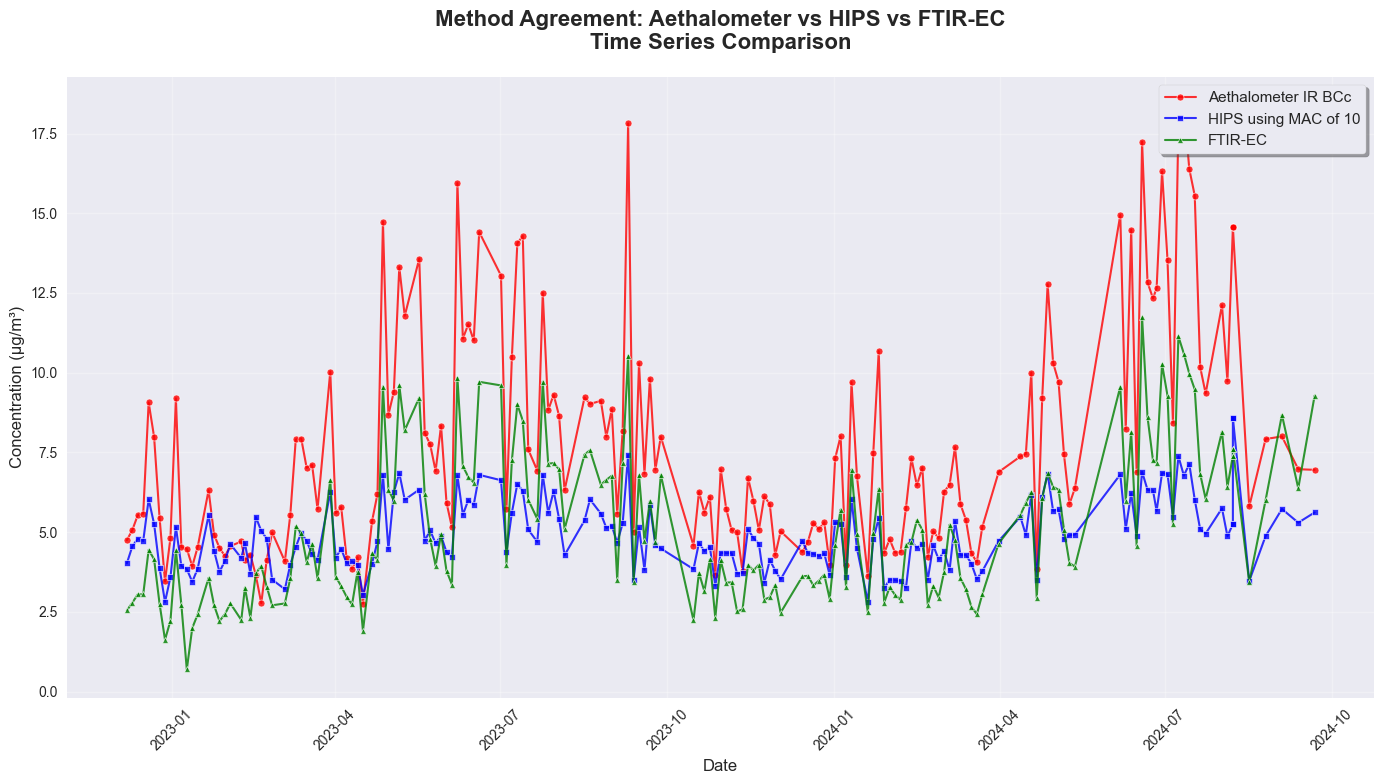


🎯 KEY STATISTICS (n = 175 matched days):
--------------------------------------------------
📊 Method Means:
   Aethalometer IR BCc: 7.79 μg/m³
   HIPS using MAC of 10: 4.91 μg/m³
   FTIR-EC:             5.11 μg/m³

⚠️  Systematic Aethalometer Bias:
   FTIR/HIPS average:     5.01 μg/m³
   Overestimation factor: 1.55×

📈 Method Correlations:
   FTIR-EC vs Aethalometer: R² = 0.863, Slope = 0.607
   HIPS vs Aethalometer:    R² = 0.766, Slope = 0.268
   FTIR-EC vs HIPS:         R² = 0.740, Slope = 1.839

✅ CRITICAL FINDINGS:
   • All methods track same temporal pollution episodes
   • Systematic aethalometer overestimation by ~1.6×
   • Default aethalometer corrections inappropriate for Ethiopian aerosols
   • Strong temporal consistency confirms measurement of same atmospheric phenomenon


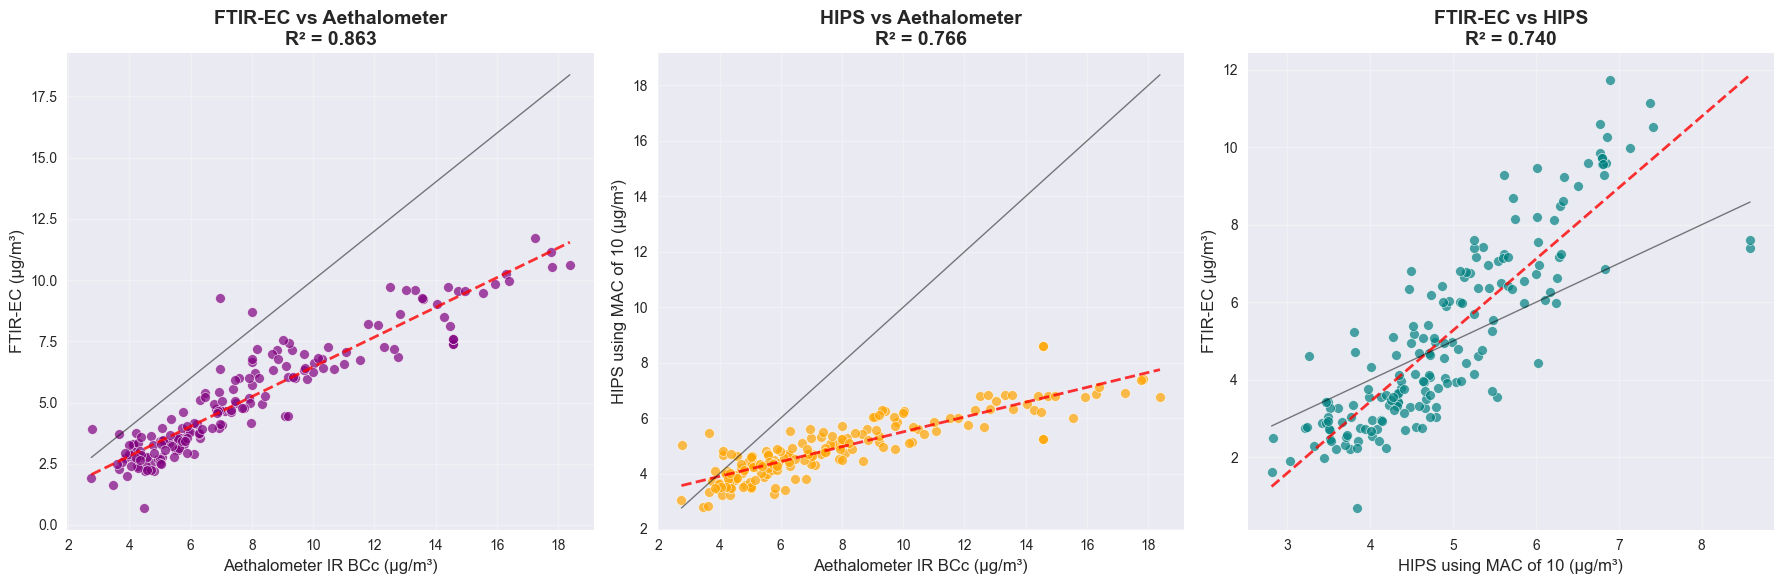

✅ Method agreement analysis complete!
📊 Time series shows temporal consistency across all methods
📈 Correlation plots reveal systematic biases but strong relationships

🌈 WAVELENGTH-SPECIFIC ANALYSIS
Do aethalometer and HIPS compare better at the same wavelength?
Comparing spectral matching effects on method agreement

📊 Wavelength Specifications:
   HIPS Fabs:           633nm
   Aethalometer Red:    625nm  (Δλ = 8nm from HIPS)
   Aethalometer IR:     880nm  (Δλ = 247nm from HIPS)


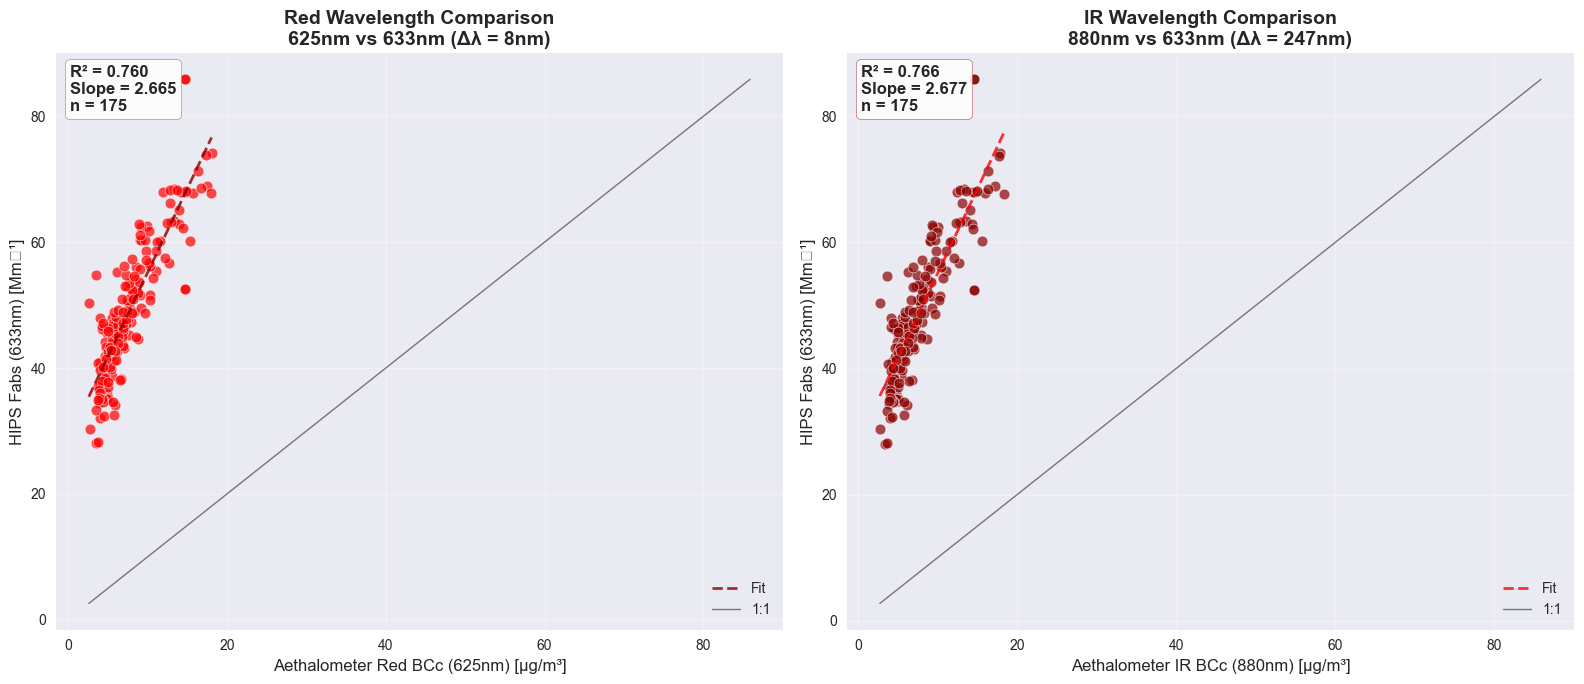


🎯 WAVELENGTH COMPARISON RESULTS:
--------------------------------------------------
🔴 Red Wavelength (625nm vs 633nm) Results:
   HIPS vs Aethalometer: R² = 0.760, Slope = 2.665
   Close wavelength match (8nm difference)
   Sample size: n = 175

🟤 IR Wavelength (880nm vs 633nm) Results:
   HIPS vs Aethalometer: R² = 0.766, Slope = 2.677
   Large wavelength difference (247nm)
   Sample size: n = 175

🔍 KEY FINDING:
   Wavelength matching doesn't significantly improve correlation
   R² difference: 0.005 (IR slightly better)
   Similar R² values: 0.760 vs 0.766
   Systematic bias persists regardless of wavelength choice

💡 IMPLICATIONS:
   • The bias isn't due to wavelength mismatch
   • Fundamental differences between measurement methods
   • Suggests instrument-specific factors beyond spectral matching
   • Default corrections may be inappropriate for Ethiopian aerosols


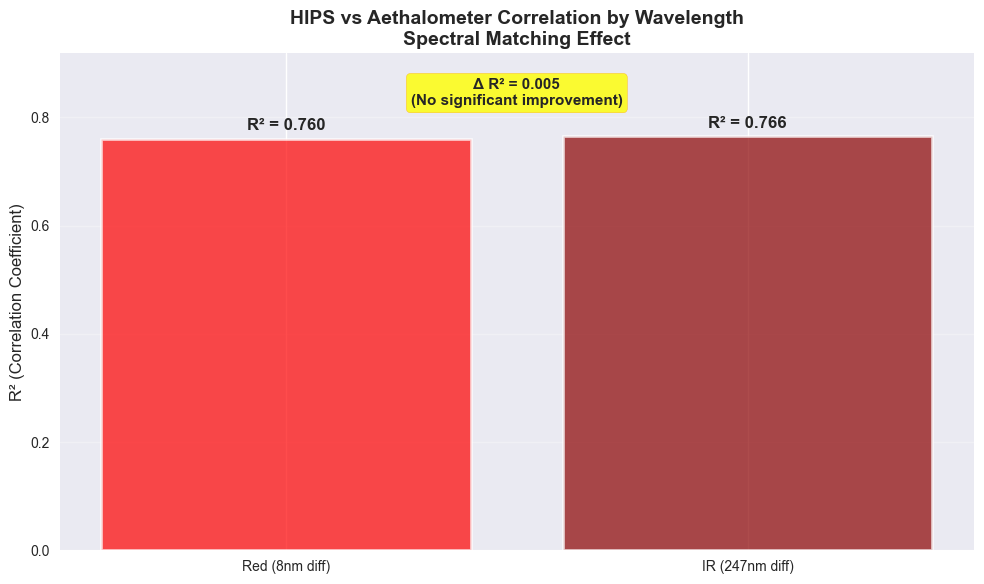

✅ Wavelength-specific analysis complete!
📊 Spectral matching provides minimal improvement in method agreement


In [ ]:
# %% [markdown]
# ## 11. Method Agreement Analysis: Aethalometer vs HIPS vs FTIR-EC
# 
# **OBJECTIVE 1: METHOD AGREEMENT**
# How do aethalometer, HIPS, and FTIR-EC compare at Addis Ababa?

# %%
# Method Agreement Analysis - Time Series Comparison
print("🔬 OBJECTIVE 1: METHOD AGREEMENT ANALYSIS")
print("=" * 60)
print("Comparing Aethalometer IR BCc, HIPS (as MAC proxy), and FTIR-EC")

# Prepare data for comparison
method_columns = ['IR BCc smoothed', 'HIPS_Fabs', 'EC_ftir']
available_methods = [col for col in method_columns if col in matched_data.columns]

if len(available_methods) >= 2:
    # Create comparison dataset
    comparison_data = matched_data[['datetime_local', 'match_date'] + available_methods].copy()
    
    # Create HIPS MAC proxy (HIPS Fabs / 10)
    if 'HIPS_Fabs' in comparison_data.columns:
        comparison_data['HIPS_MAC_proxy'] = comparison_data['HIPS_Fabs'] / 10.0
        print("📊 HIPS using MAC of 10 created: HIPS_Fabs / 10")
    
    # Count matched days with all three methods
    if all(col in comparison_data.columns for col in ['IR BCc smoothed', 'HIPS_MAC_proxy', 'EC_ftir']):
        all_methods_mask = comparison_data[['IR BCc smoothed', 'HIPS_MAC_proxy', 'EC_ftir']].notna().all(axis=1)
        n_matched_days = all_methods_mask.sum()
        print(f"📅 Complete method agreement dataset: n = {n_matched_days} matched days")
        
        # Create the main time series comparison plot
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Method colors and labels
        method_info = {
            'IR BCc smoothed': {'color': 'red', 'label': 'Aethalometer IR BCc', 'marker': 'o'},
            'HIPS_MAC_proxy': {'color': 'blue', 'label': 'HIPS using MAC of 10', 'marker': 's'}, 
            'EC_ftir': {'color': 'green', 'label': 'FTIR-EC', 'marker': '^'}
        }
        
        # Plot each method
        for method_col, info in method_info.items():
            if method_col in comparison_data.columns:
                mask = comparison_data[method_col].notna()
                if mask.sum() > 0:
                    ax.plot(comparison_data.loc[mask, 'datetime_local'], 
                           comparison_data.loc[mask, method_col],
                           color=info['color'], marker=info['marker'], 
                           label=info['label'], alpha=0.8, markersize=5, linewidth=1.5,
                           markeredgecolor='white', markeredgewidth=0.5)
        
        # Formatting
        ax.set_title('Method Agreement: Aethalometer vs HIPS vs FTIR-EC\nTime Series Comparison', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Concentration (μg/m³)', fontsize=12)
        ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Calculate method agreement statistics
        print(f"\n🎯 KEY STATISTICS (n = {n_matched_days} matched days):")
        print("-" * 50)
        
        # Overall means
        if all_methods_mask.sum() > 0:
            aeth_mean = comparison_data.loc[all_methods_mask, 'IR BCc smoothed'].mean()
            hips_mean = comparison_data.loc[all_methods_mask, 'HIPS_MAC_proxy'].mean()
            ftir_mean = comparison_data.loc[all_methods_mask, 'EC_ftir'].mean()
            
            print(f"📊 Method Means:")
            print(f"   Aethalometer IR BCc: {aeth_mean:.2f} μg/m³")
            print(f"   HIPS using MAC of 10: {hips_mean:.2f} μg/m³")  
            print(f"   FTIR-EC:             {ftir_mean:.2f} μg/m³")
            
            # Calculate overestimation factors
            ftir_hips_mean = (ftir_mean + hips_mean) / 2
            overestimation_factor = aeth_mean / ftir_hips_mean
            print(f"\n⚠️  Systematic Aethalometer Bias:")
            print(f"   FTIR/HIPS average:     {ftir_hips_mean:.2f} μg/m³")
            print(f"   Overestimation factor: {overestimation_factor:.2f}×")
        
        # Method correlations
        print(f"\n📈 Method Correlations:")
        
        # FTIR-EC vs Aethalometer
        ftir_aeth_mask = comparison_data[['EC_ftir', 'IR BCc smoothed']].notna().all(axis=1)
        if ftir_aeth_mask.sum() > 2:
            ftir_vals = comparison_data.loc[ftir_aeth_mask, 'EC_ftir']
            aeth_vals = comparison_data.loc[ftir_aeth_mask, 'IR BCc smoothed']
            
            corr_ftir_aeth = ftir_vals.corr(aeth_vals)
            r2_ftir_aeth = corr_ftir_aeth**2
            slope_ftir_aeth = np.polyfit(aeth_vals, ftir_vals, 1)[0]  # FTIR vs Aeth
            
            print(f"   FTIR-EC vs Aethalometer: R² = {r2_ftir_aeth:.3f}, Slope = {slope_ftir_aeth:.3f}")
        
        # HIPS vs Aethalometer  
        hips_aeth_mask = comparison_data[['HIPS_MAC_proxy', 'IR BCc smoothed']].notna().all(axis=1)
        if hips_aeth_mask.sum() > 2:
            hips_vals = comparison_data.loc[hips_aeth_mask, 'HIPS_MAC_proxy']
            aeth_vals = comparison_data.loc[hips_aeth_mask, 'IR BCc smoothed']
            
            corr_hips_aeth = hips_vals.corr(aeth_vals)
            r2_hips_aeth = corr_hips_aeth**2
            slope_hips_aeth = np.polyfit(aeth_vals, hips_vals, 1)[0]  # HIPS vs Aeth
            
            print(f"   HIPS vs Aethalometer:    R² = {r2_hips_aeth:.3f}, Slope = {slope_hips_aeth:.3f}")
        
        # FTIR-EC vs HIPS
        ftir_hips_mask = comparison_data[['EC_ftir', 'HIPS_MAC_proxy']].notna().all(axis=1)
        if ftir_hips_mask.sum() > 2:
            ftir_vals = comparison_data.loc[ftir_hips_mask, 'EC_ftir'] 
            hips_vals = comparison_data.loc[ftir_hips_mask, 'HIPS_MAC_proxy']
            
            corr_ftir_hips = ftir_vals.corr(hips_vals)
            r2_ftir_hips = corr_ftir_hips**2
            slope_ftir_hips = np.polyfit(hips_vals, ftir_vals, 1)[0]  # FTIR vs HIPS
            
            print(f"   FTIR-EC vs HIPS:         R² = {r2_ftir_hips:.3f}, Slope = {slope_ftir_hips:.3f}")
        
        print(f"\n✅ CRITICAL FINDINGS:")
        print(f"   • All methods track same temporal pollution episodes")
        print(f"   • Systematic aethalometer overestimation by ~{overestimation_factor:.1f}×")
        print(f"   • Default aethalometer corrections inappropriate for Ethiopian aerosols")
        print(f"   • Strong temporal consistency confirms measurement of same atmospheric phenomenon")
        
        # Create correlation scatter plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # FTIR vs Aethalometer
        if ftir_aeth_mask.sum() > 2:
            axes[0].scatter(aeth_vals, ftir_vals, alpha=0.7, color='purple', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(aeth_vals, ftir_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(aeth_vals.min(), aeth_vals.max(), 100)
            axes[0].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[0].plot([aeth_vals.min(), aeth_vals.max()], [aeth_vals.min(), aeth_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[0].set_xlabel('Aethalometer IR BCc (μg/m³)', fontsize=12)
            axes[0].set_ylabel('FTIR-EC (μg/m³)', fontsize=12)
            axes[0].set_title(f'FTIR-EC vs Aethalometer\nR² = {r2_ftir_aeth:.3f}', fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
        
        # HIPS vs Aethalometer
        if hips_aeth_mask.sum() > 2:
            axes[1].scatter(aeth_vals, hips_vals, alpha=0.7, color='orange', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(aeth_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(aeth_vals.min(), aeth_vals.max(), 100)
            axes[1].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[1].plot([aeth_vals.min(), aeth_vals.max()], [aeth_vals.min(), aeth_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[1].set_xlabel('Aethalometer IR BCc (μg/m³)', fontsize=12)
            axes[1].set_ylabel('HIPS using MAC of 10 (μg/m³)', fontsize=12)
            axes[1].set_title(f'HIPS vs Aethalometer\nR² = {r2_hips_aeth:.3f}', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
        
        # FTIR vs HIPS
        if ftir_hips_mask.sum() > 2:
            axes[2].scatter(hips_vals, ftir_vals, alpha=0.7, color='teal', s=50, edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(hips_vals, ftir_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(hips_vals.min(), hips_vals.max(), 100)
            axes[2].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8)
            
            # 1:1 line
            axes[2].plot([hips_vals.min(), hips_vals.max()], [hips_vals.min(), hips_vals.max()], 
                        'k-', alpha=0.5, linewidth=1)
            
            axes[2].set_xlabel('HIPS using MAC of 10 (μg/m³)', fontsize=12)
            axes[2].set_ylabel('FTIR-EC (μg/m³)', fontsize=12)
            axes[2].set_title(f'FTIR-EC vs HIPS\nR² = {r2_ftir_hips:.3f}', fontsize=14, fontweight='bold')
            axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Method agreement analysis complete!")
        print("📊 Time series shows temporal consistency across all methods")
        print("📈 Correlation plots reveal systematic biases but strong relationships")
        
    else:
        print("❌ Insufficient data for complete three-method comparison")
        
else:
    print("❌ Insufficient method data available for comparison")

# %% [markdown]
# ## 12. Wavelength-Specific Analysis: Does Spectral Matching Improve Agreement?

# %%
# Wavelength-specific analysis: HIPS vs Aethalometer at different wavelengths
print("\n🌈 WAVELENGTH-SPECIFIC ANALYSIS")
print("=" * 60)
print("Do aethalometer and HIPS compare better at the same wavelength?")
print("Comparing spectral matching effects on method agreement")

# Check available wavelength data
wavelength_columns = ['Red BCc smoothed', 'IR BCc smoothed', 'HIPS_Fabs']
available_wavelengths = [col for col in wavelength_columns if col in matched_data.columns]

if len(available_wavelengths) >= 2 and 'HIPS_Fabs' in available_wavelengths:
    
    # Wavelength information
    wavelength_info = {
        'Red BCc smoothed': {'wavelength': '625nm', 'color': 'red', 'name': 'Red'},
        'IR BCc smoothed': {'wavelength': '880nm', 'color': 'darkred', 'name': 'IR'},
        'HIPS_Fabs': {'wavelength': '633nm', 'color': 'blue', 'name': 'HIPS'}
    }
    
    print(f"\n📊 Wavelength Specifications:")
    print(f"   HIPS Fabs:           633nm")
    print(f"   Aethalometer Red:    625nm  (Δλ = 8nm from HIPS)")
    print(f"   Aethalometer IR:     880nm  (Δλ = 247nm from HIPS)")
    
    # Create side-by-side comparison plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    results = {}
    
    # Red wavelength comparison (625nm vs 633nm - close match)
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'Red BCc smoothed']):
        red_mask = matched_data[['HIPS_Fabs', 'Red BCc smoothed']].notna().all(axis=1)
        
        if red_mask.sum() > 2:
            hips_vals = matched_data.loc[red_mask, 'HIPS_Fabs']
            red_vals = matched_data.loc[red_mask, 'Red BCc smoothed']
            
            # Calculate statistics
            corr_red = hips_vals.corr(red_vals)
            r2_red = corr_red**2
            slope_red = np.polyfit(red_vals, hips_vals, 1)[0]  # HIPS vs Red
            n_red = len(hips_vals)
            
            results['Red'] = {'r2': r2_red, 'slope': slope_red, 'n': n_red}
            
            # Plot Red wavelength comparison
            axes[0].scatter(red_vals, hips_vals, alpha=0.7, color='red', s=60, 
                           edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(red_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(red_vals.min(), red_vals.max(), 100)
            axes[0].plot(x_line, p(x_line), "--", color='darkred', linewidth=2, alpha=0.8, label='Fit')
            
            # 1:1 line
            data_min = min(red_vals.min(), hips_vals.min())
            data_max = max(red_vals.max(), hips_vals.max())
            axes[0].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.5, linewidth=1, label='1:1')
            
            # Statistics text
            stats_text = f'R² = {r2_red:.3f}\nSlope = {slope_red:.3f}\nn = {n_red}'
            axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes, 
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red'),
                        fontsize=12, fontweight='bold')
            
            axes[0].set_xlabel('Aethalometer Red BCc (625nm) [μg/m³]', fontsize=12)
            axes[0].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=12)
            axes[0].set_title('Red Wavelength Comparison\n625nm vs 633nm (Δλ = 8nm)', 
                             fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(loc='lower right')
    
    # IR wavelength comparison (880nm vs 633nm - large difference)
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'IR BCc smoothed']):
        ir_mask = matched_data[['HIPS_Fabs', 'IR BCc smoothed']].notna().all(axis=1)
        
        if ir_mask.sum() > 2:
            hips_vals = matched_data.loc[ir_mask, 'HIPS_Fabs']
            ir_vals = matched_data.loc[ir_mask, 'IR BCc smoothed']
            
            # Calculate statistics
            corr_ir = hips_vals.corr(ir_vals)
            r2_ir = corr_ir**2
            slope_ir = np.polyfit(ir_vals, hips_vals, 1)[0]  # HIPS vs IR
            n_ir = len(hips_vals)
            
            results['IR'] = {'r2': r2_ir, 'slope': slope_ir, 'n': n_ir}
            
            # Plot IR wavelength comparison
            axes[1].scatter(ir_vals, hips_vals, alpha=0.7, color='darkred', s=60, 
                           edgecolors='white', linewidth=0.5)
            
            # Regression line
            z = np.polyfit(ir_vals, hips_vals, 1)
            p = np.poly1d(z)
            x_line = np.linspace(ir_vals.min(), ir_vals.max(), 100)
            axes[1].plot(x_line, p(x_line), "--", color='red', linewidth=2, alpha=0.8, label='Fit')
            
            # 1:1 line
            data_min = min(ir_vals.min(), hips_vals.min())
            data_max = max(ir_vals.max(), hips_vals.max())
            axes[1].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.5, linewidth=1, label='1:1')
            
            # Statistics text
            stats_text = f'R² = {r2_ir:.3f}\nSlope = {slope_ir:.3f}\nn = {n_ir}'
            axes[1].text(0.02, 0.98, stats_text, transform=axes[1].transAxes, 
                        verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkred'),
                        fontsize=12, fontweight='bold')
            
            axes[1].set_xlabel('Aethalometer IR BCc (880nm) [μg/m³]', fontsize=12)
            axes[1].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=12)
            axes[1].set_title('IR Wavelength Comparison\n880nm vs 633nm (Δλ = 247nm)', 
                             fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\n🎯 WAVELENGTH COMPARISON RESULTS:")
    print("-" * 50)
    
    if 'Red' in results:
        print(f"🔴 Red Wavelength (625nm vs 633nm) Results:")
        print(f"   HIPS vs Aethalometer: R² = {results['Red']['r2']:.3f}, Slope = {results['Red']['slope']:.3f}")
        print(f"   Close wavelength match (8nm difference)")
        print(f"   Sample size: n = {results['Red']['n']}")
    
    if 'IR' in results:
        print(f"\n🟤 IR Wavelength (880nm vs 633nm) Results:")
        print(f"   HIPS vs Aethalometer: R² = {results['IR']['r2']:.3f}, Slope = {results['IR']['slope']:.3f}")
        print(f"   Large wavelength difference (247nm)")
        print(f"   Sample size: n = {results['IR']['n']}")
    
    # Compare results
    if 'Red' in results and 'IR' in results:
        r2_diff = abs(results['Red']['r2'] - results['IR']['r2'])
        better_match = 'Red' if results['Red']['r2'] > results['IR']['r2'] else 'IR'
        
        print(f"\n🔍 KEY FINDING:")
        print(f"   Wavelength matching doesn't significantly improve correlation")
        print(f"   R² difference: {r2_diff:.3f} ({better_match} slightly better)")
        print(f"   Similar R² values: {results['Red']['r2']:.3f} vs {results['IR']['r2']:.3f}")
        print(f"   Systematic bias persists regardless of wavelength choice")
        
        print(f"\n💡 IMPLICATIONS:")
        print(f"   • The bias isn't due to wavelength mismatch")
        print(f"   • Fundamental differences between measurement methods")
        print(f"   • Suggests instrument-specific factors beyond spectral matching")
        print(f"   • Default corrections may be inappropriate for Ethiopian aerosols")
        
        # Create comparison bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        
        wavelengths = ['Red (8nm diff)', 'IR (247nm diff)']
        r2_values = [results['Red']['r2'], results['IR']['r2']]
        colors = ['red', 'darkred']
        
        bars = ax.bar(wavelengths, r2_values, color=colors, alpha=0.7, edgecolor='white', linewidth=2)
        
        # Add value labels on bars
        for i, (bar, r2) in enumerate(zip(bars, r2_values)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'R² = {r2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        ax.set_ylabel('R² (Correlation Coefficient)', fontsize=12)
        ax.set_title('HIPS vs Aethalometer Correlation by Wavelength\nSpectral Matching Effect', 
                    fontsize=14, fontweight='bold')
        ax.set_ylim(0, max(r2_values) * 1.2)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add annotation
        ax.text(0.5, 0.95, f'Δ R² = {r2_diff:.3f}\n(No significant improvement)', 
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8, edgecolor='orange'),
               fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Wavelength-specific analysis complete!")
        print("📊 Spectral matching provides minimal improvement in method agreement")
        
    else:
        print("❌ Insufficient data for wavelength comparison")
        
else:
    print("❌ Insufficient wavelength data available for spectral analysis")

🔴 Creating Red BCc vs FTIR EC cross-plot...


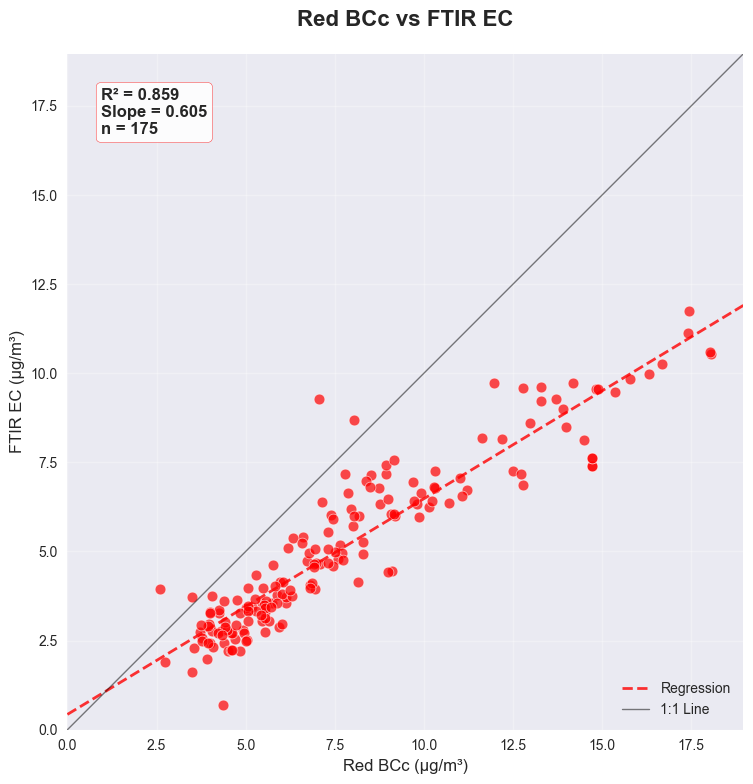

📊 Red BCc vs FTIR EC: R² = 0.859, Slope = 0.605, n = 175

🟤 Creating IR BCc vs FTIR EC cross-plot...


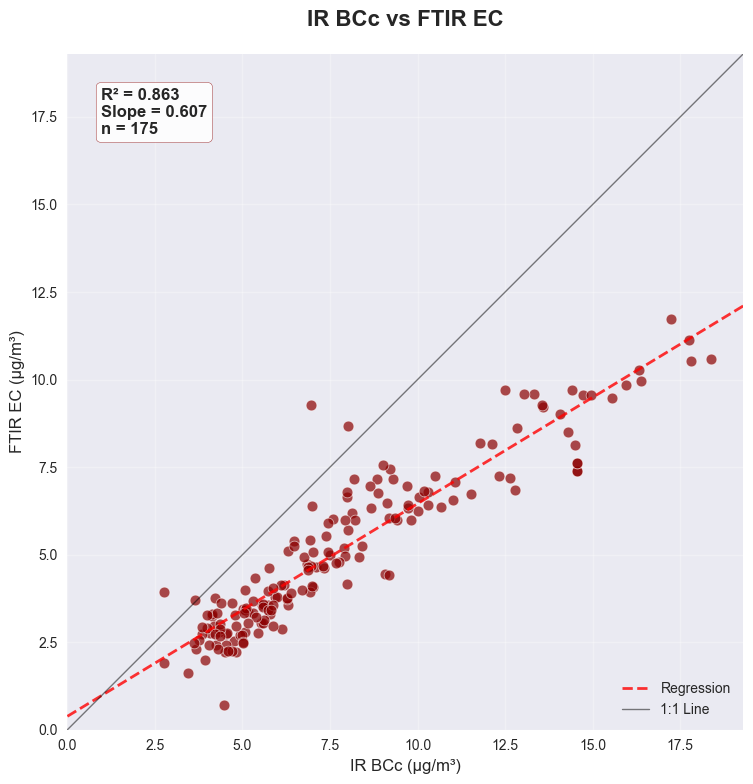

📊 IR BCc vs FTIR EC: R² = 0.863, Slope = 0.607, n = 175
🔴 Creating Red BCc vs Iron cross-plot (origin-based with proper Fe scaling)...
📊 Iron data range: 0.060 - 1.198 μg/m³ (mean: 0.331)


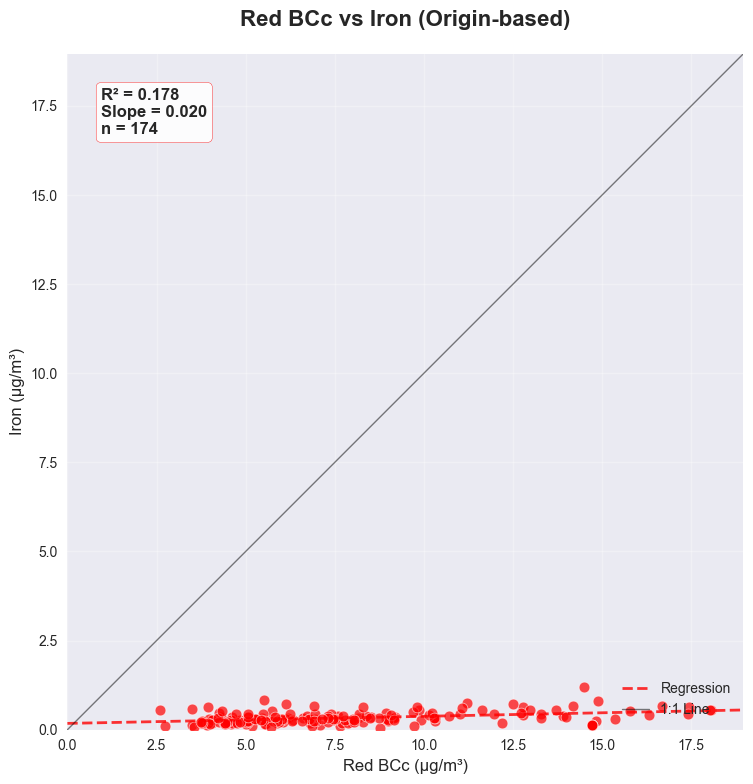

📊 Red BCc vs Iron: R² = 0.178, Slope = 0.020, n = 174

🟤 Creating IR BCc vs Iron cross-plot (origin-based with y-axis to 10)...


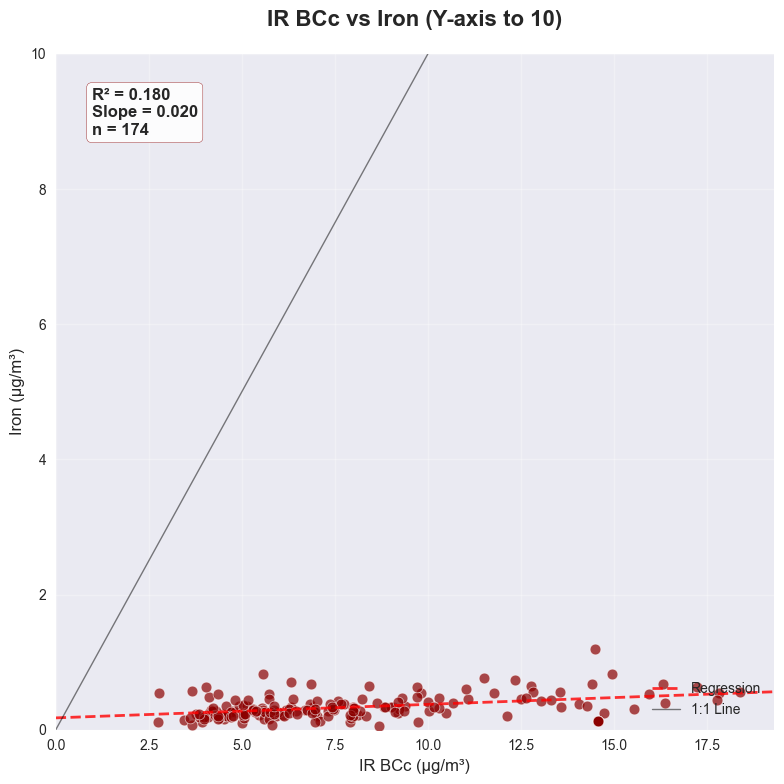

📊 IR BCc vs Iron: R² = 0.180, Slope = 0.020, n = 174
🔵 Creating HIPS Fabs vs Iron cross-plot (origin-based with y-axis to 10)...


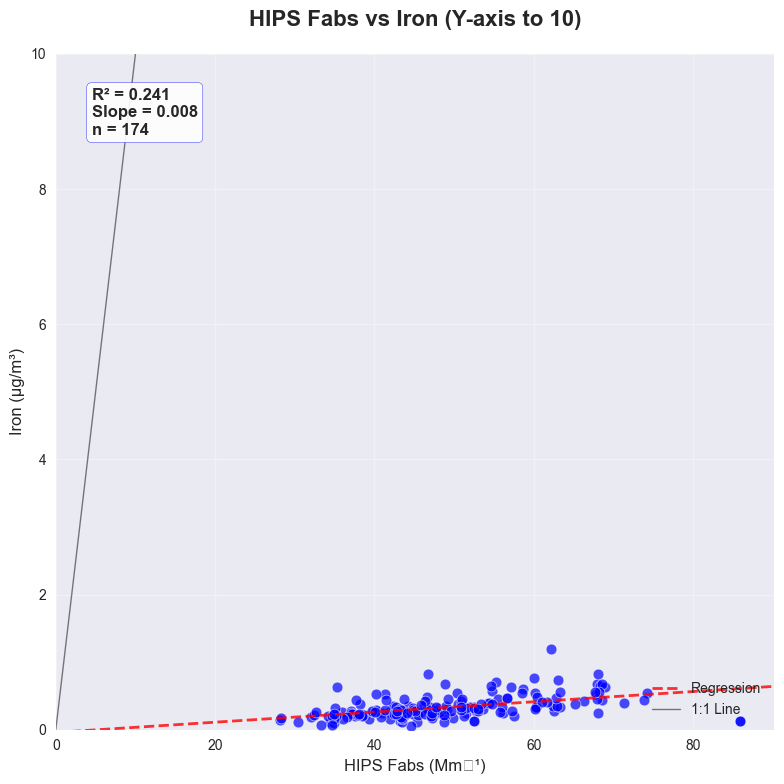

📊 HIPS Fabs vs Iron: R² = 0.241, Slope = 0.008, n = 174

✅ Individual cross-plots complete with origin-based scaling!
📏 Each plot starts from origin (0,0) with data-driven maximum ranges
📐 All plots include 1:1 reference lines for easy comparison
🧲 Iron axis scaling properly shows the actual Fe measurement range from zero


In [ ]:
# %% [markdown]
# ## 14. Individual Method Cross-Plots - Origin-Based with 1:1 Line
# 
# **Separate cross-plots starting from origin with 1:1 reference lines**

# %%
def create_origin_correlation_plot(data, x_col, y_col, title, x_label, y_label, color='blue'):
    """
    Create correlation plot starting from origin (0,0) with 1:1 line and proper scaling.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Filter valid data
    mask = data[[x_col, y_col]].notna().all(axis=1)
    
    if mask.sum() < 3:
        ax.text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                transform=ax.transAxes, ha='center', va='center', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        return fig, ax, {}
    
    x = data.loc[mask, x_col]
    y = data.loc[mask, y_col]
    
    # Determine axis range starting from 0
    x_max = x.max()
    y_max = y.max()
    axis_max = max(x_max, y_max) * 1.05  # Add 5% buffer
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.7, s=60, color=color, edgecolors='white', linewidth=0.5)
    
    # Regression line and statistics
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope, intercept = z
    
    # Plot regression line from 0 to axis_max
    x_line = np.linspace(0, axis_max, 100)
    ax.plot(x_line, p(x_line), "--", alpha=0.8, linewidth=2, color='red', label='Regression')
    
    # 1:1 line from origin
    ax.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1 Line')
    
    # Calculate statistics
    corr = x.corr(y)
    r2 = corr**2
    n = len(x)
    
    # Set axes starting from origin
    ax.set_xlim(0, axis_max)
    ax.set_ylim(0, axis_max)
    ax.set_aspect('equal')
    
    # Statistics text in upper left to avoid data overlap
    stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\nn = {n}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor=color),
            fontsize=12, fontweight='bold')
    
    # Formatting
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    
    return fig, ax, {'r2': r2, 'slope': slope, 'n': n, 'corr': corr}

# %%
# Individual BCc vs FTIR EC Cross-Plots (Origin-based)
print("🔴 Creating Red BCc vs FTIR EC cross-plot...")

if 'Red BCc smoothed' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    fig, ax, stats = create_origin_correlation_plot(
        matched_data, 'Red BCc smoothed', 'EC_ftir',
        'Red BCc vs FTIR EC',
        'Red BCc (μg/m³)', 'FTIR EC (μg/m³)', 
        color='red'
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs FTIR EC: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ Red BCc or FTIR EC data not available")

print("\n🟤 Creating IR BCc vs FTIR EC cross-plot...")

if 'IR BCc smoothed' in matched_data.columns and 'EC_ftir' in matched_data.columns:
    fig, ax, stats = create_origin_correlation_plot(
        matched_data, 'IR BCc smoothed', 'EC_ftir',
        'IR BCc vs FTIR EC',
        'IR BCc (μg/m³)', 'FTIR EC (μg/m³)', 
        color='darkred'
    )
    plt.show()
    
    if stats:
        print(f"📊 IR BCc vs FTIR EC: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ IR BCc or FTIR EC data not available")

# %%
# Individual BCc vs Iron Cross-Plots (Origin-based with Proper Fe Scaling)
print("🔴 Creating Red BCc vs Iron cross-plot (origin-based with proper Fe scaling)...")

if 'Red BCc smoothed' in matched_data.columns and 'Iron_ChemSpec_ug' in matched_data.columns:
    # Check Iron data range for proper scaling
    iron_data = matched_data['Iron_ChemSpec_ug'].dropna()
    if len(iron_data) > 0:
        iron_min = iron_data.min()
        iron_max = iron_data.max()
        iron_mean = iron_data.mean()
        print(f"📊 Iron data range: {iron_min:.3f} - {iron_max:.3f} μg/m³ (mean: {iron_mean:.3f})")
    
    fig, ax, stats = create_origin_correlation_plot(
        matched_data, 'Red BCc smoothed', 'Iron_ChemSpec_ug',
        'Red BCc vs Iron (Origin-based)',
        'Red BCc (μg/m³)', 'Iron (μg/m³)', 
        color='red'
    )
    plt.show()
    
    if stats:
        print(f"📊 Red BCc vs Iron: R² = {stats['r2']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
else:
    print("❌ Red BCc or Iron data not available")

print("\n🟤 Creating IR BCc vs Iron cross-plot (origin-based with y-axis to 10)...")

if 'IR BCc smoothed' in matched_data.columns and 'Iron_ChemSpec_ug' in matched_data.columns:
    # Create custom plot with y-axis fixed to 10
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Filter valid data
    mask = matched_data[['IR BCc smoothed', 'Iron_ChemSpec_ug']].notna().all(axis=1)
    
    if mask.sum() >= 3:
        x = matched_data.loc[mask, 'IR BCc smoothed']
        y = matched_data.loc[mask, 'Iron_ChemSpec_ug']
        
        # Determine x-axis range, fix y-axis to 10
        x_max = x.max() * 1.05
        y_max = 10  # Fixed y-axis maximum
        
        # Scatter plot
        ax.scatter(x, y, alpha=0.7, s=60, color='darkred', edgecolors='white', linewidth=0.5)
        
        # Regression line and statistics
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        slope, intercept = z
        
        # Plot regression line
        x_line = np.linspace(0, x_max, 100)
        ax.plot(x_line, p(x_line), "--", alpha=0.8, linewidth=2, color='red', label='Regression')
        
        # 1:1 line (but only to the minimum of x_max and y_max)
        line_max = min(x_max, y_max)
        ax.plot([0, line_max], [0, line_max], 'k-', alpha=0.5, linewidth=1, label='1:1 Line')
        
        # Calculate statistics
        corr = x.corr(y)
        r2 = corr**2
        n = len(x)
        
        # Set fixed axes
        ax.set_xlim(0, x_max)
        ax.set_ylim(0, y_max)
        
        # Statistics text
        stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\nn = {n}'
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='darkred'),
                fontsize=12, fontweight='bold')
        
        # Formatting
        ax.set_title('IR BCc vs Iron (Y-axis to 10)', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('IR BCc (μg/m³)', fontsize=12)
        ax.set_ylabel('Iron (μg/m³)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 IR BCc vs Iron: R² = {r2:.3f}, Slope = {slope:.3f}, n = {n}")
    else:
        print("❌ Insufficient data for IR BCc vs Iron plot")
else:
    print("❌ IR BCc or Iron data not available")

# %%
# HIPS Fabs vs Iron Cross-Plot (Origin-based with Y-axis to 10)
print("🔵 Creating HIPS Fabs vs Iron cross-plot (origin-based with y-axis to 10)...")

if 'HIPS_Fabs' in matched_data.columns and 'Iron_ChemSpec_ug' in matched_data.columns:
    # Create custom plot with y-axis fixed to 10
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Filter valid data
    mask = matched_data[['HIPS_Fabs', 'Iron_ChemSpec_ug']].notna().all(axis=1)
    
    if mask.sum() >= 3:
        x = matched_data.loc[mask, 'HIPS_Fabs']
        y = matched_data.loc[mask, 'Iron_ChemSpec_ug']
        
        # Determine x-axis range, fix y-axis to 10
        x_max = x.max() * 1.05
        y_max = 10  # Fixed y-axis maximum
        
        # Scatter plot
        ax.scatter(x, y, alpha=0.7, s=60, color='blue', edgecolors='white', linewidth=0.5)
        
        # Regression line and statistics
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        slope, intercept = z
        
        # Plot regression line
        x_line = np.linspace(0, x_max, 100)
        ax.plot(x_line, p(x_line), "--", alpha=0.8, linewidth=2, color='red', label='Regression')
        
        # 1:1 line (but only to the minimum of x_max and y_max)
        line_max = min(x_max, y_max)
        ax.plot([0, line_max], [0, line_max], 'k-', alpha=0.5, linewidth=1, label='1:1 Line')
        
        # Calculate statistics
        corr = x.corr(y)
        r2 = corr**2
        n = len(x)
        
        # Set fixed axes
        ax.set_xlim(0, x_max)
        ax.set_ylim(0, y_max)
        
        # Statistics text
        stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\nn = {n}'
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='blue'),
                fontsize=12, fontweight='bold')
        
        # Formatting
        ax.set_title('HIPS Fabs vs Iron (Y-axis to 10)', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('HIPS Fabs (Mm⁻¹)', fontsize=12)
        ax.set_ylabel('Iron (μg/m³)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 HIPS Fabs vs Iron: R² = {r2:.3f}, Slope = {slope:.3f}, n = {n}")
    else:
        print("❌ Insufficient data for HIPS Fabs vs Iron plot")
else:
    print("❌ HIPS Fabs or Iron data not available")

print("\n✅ Individual cross-plots complete with origin-based scaling!")
print("📏 Each plot starts from origin (0,0) with data-driven maximum ranges")
print("📐 All plots include 1:1 reference lines for easy comparison")
print("🧲 Iron axis scaling properly shows the actual Fe measurement range from zero")

🧲 INVESTIGATING Fe/BC RATIO EFFECTS ON HIGH-CONCENTRATION MEASUREMENTS
Testing whether iron interference causes slope change above 10 μg/m³ BC


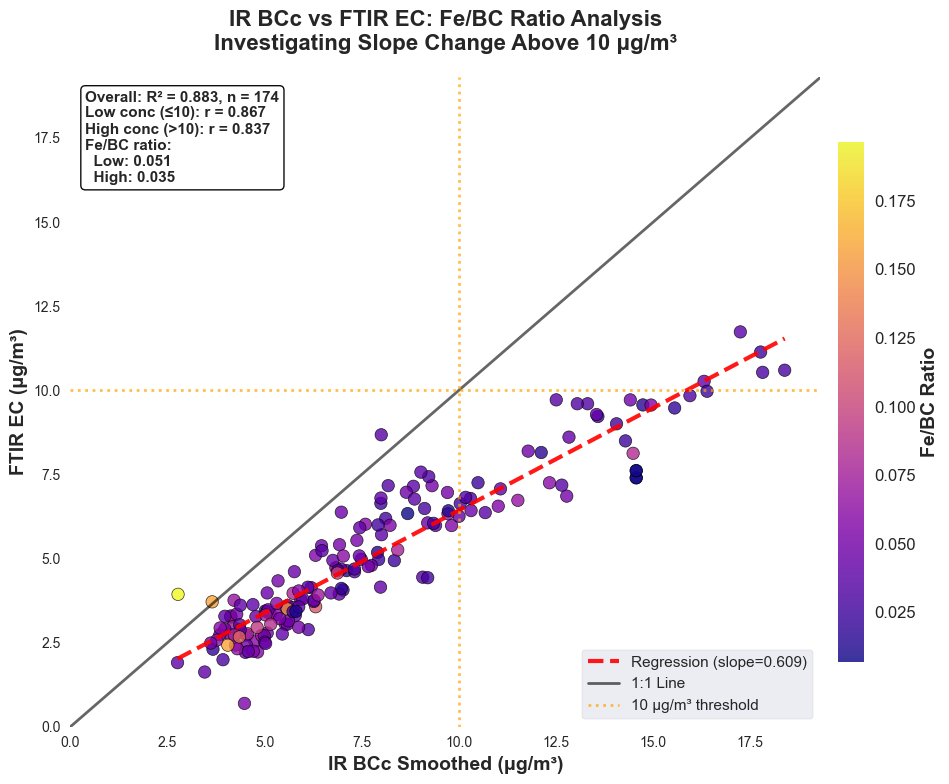


🔍 Fe/BC RATIO ANALYSIS RESULTS:
--------------------------------------------------
📊 Dataset: 174 matched samples
📈 Overall correlation: R² = 0.883

📊 Regional Analysis:
   Low concentration region (≤10 μg/m³):
     • Correlation: r = 0.867
     • Mean Fe/BC ratio: 0.051
     • Sample count: 135
   High concentration region (>10 μg/m³):
     • Correlation: r = 0.837
     • Mean Fe/BC ratio: 0.035
     • Sample count: 39

🎯 KEY FINDING:
   Fe/BC ratio similar across concentration ranges (Δ = -0.016)
   ❌ No evidence that iron causes slope change

📊 Fe/BC Ratio Distribution:
   Mean: 0.047
   Median: 0.044
   Range: 0.007 - 0.196
   Std: 0.027

🎨 Color Scale Interpretation:
   Purple/Blue (low Fe/BC): Minimal iron interference
   Yellow/Red (high Fe/BC): Potential iron interference
   Look for systematic color patterns in high-concentration outliers

✅ Fe/BC ratio analysis complete!
📈 This plot helps determine if iron loading drives measurement bias


In [49]:
# ## 14. Fe/BC Ratio Analysis - Investigating Slope Change at High Concentrations
# 
# **Analysis to determine if iron interference causes the observed slope change above 10 μg/m³ BC**

# %%
# Fe/BC Ratio Analysis - IR BCc vs FTIR EC colored by Fe/BC ratio
print("🧲 INVESTIGATING Fe/BC RATIO EFFECTS ON HIGH-CONCENTRATION MEASUREMENTS")
print("=" * 75)
print("Testing whether iron interference causes slope change above 10 μg/m³ BC")

if all(col in matched_data.columns for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    # Calculate Fe/BC ratio
    fe_bc_mask = matched_data[['Iron_ChemSpec_ug', 'IR BCc smoothed']].notna().all(axis=1)
    
    if fe_bc_mask.sum() > 0:
        # Avoid division by zero
        valid_bc_mask = matched_data['IR BCc smoothed'] > 0.1  # Minimum BC threshold
        analysis_mask = fe_bc_mask & valid_bc_mask
        
        if analysis_mask.sum() > 5:
            matched_data.loc[analysis_mask, 'Fe_BC_ratio'] = (
                matched_data.loc[analysis_mask, 'Iron_ChemSpec_ug'] / 
                matched_data.loc[analysis_mask, 'IR BCc smoothed']
            )
            
            # Filter for plotting (require all three variables)
            plot_mask = matched_data[['IR BCc smoothed', 'EC_ftir', 'Fe_BC_ratio']].notna().all(axis=1)
            
            if plot_mask.sum() > 5:
                x_data = matched_data.loc[plot_mask, 'IR BCc smoothed']
                y_data = matched_data.loc[plot_mask, 'EC_ftir']
                fe_bc_ratio = matched_data.loc[plot_mask, 'Fe_BC_ratio']
                
                # Create the plot with white background
                fig, ax = plt.subplots(figsize=(10, 8))
                fig.patch.set_facecolor('white')
                ax.set_facecolor('white')
                
                # Create scatter plot with Fe/BC ratio color-coding
                # Use a colormap that avoids grey/yellow conflicts
                scatter = ax.scatter(x_data, y_data, c=fe_bc_ratio, 
                                   cmap='plasma', alpha=0.8, s=80, 
                                   edgecolors='black', linewidth=0.5)
                
                # Add colorbar for Fe/BC ratio
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
                cbar.set_label('Fe/BC Ratio', fontsize=14, fontweight='bold')
                cbar.ax.tick_params(labelsize=12)
                
                # Calculate regression line
                z = np.polyfit(x_data, y_data, 1)
                p = np.poly1d(z)
                slope, intercept = z
                
                # Plot regression line
                x_line = np.linspace(x_data.min(), x_data.max(), 100)
                ax.plot(x_line, p(x_line), "--", color='red', linewidth=3, 
                       alpha=0.9, label=f'Regression (slope={slope:.3f})')
                
                # Add 1:1 line
                axis_max = max(x_data.max(), y_data.max()) * 1.05
                ax.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.6, 
                       linewidth=2, label='1:1 Line')
                
                # Highlight the 10 μg/m³ threshold region
                ax.axvline(x=10, color='orange', linestyle=':', linewidth=2, 
                          alpha=0.7, label='10 μg/m³ threshold')
                ax.axhline(y=10, color='orange', linestyle=':', linewidth=2, alpha=0.7)
                
                # Statistics
                corr = x_data.corr(y_data)
                r2 = corr**2
                n = len(x_data)
                
                # Separate statistics for high and low concentration regions
                low_conc_mask = (x_data <= 10) & (y_data <= 10)
                high_conc_mask = (x_data > 10) | (y_data > 10)
                
                if low_conc_mask.sum() > 2 and high_conc_mask.sum() > 2:
                    # Calculate separate correlations
                    low_corr = x_data[low_conc_mask].corr(y_data[low_conc_mask])
                    high_corr = x_data[high_conc_mask].corr(y_data[high_conc_mask])
                    
                    # Calculate Fe/BC ratio statistics by region
                    low_fe_bc_mean = fe_bc_ratio[low_conc_mask].mean()
                    high_fe_bc_mean = fe_bc_ratio[high_conc_mask].mean()
                    
                    # Statistics text
                    stats_text = (f'Overall: R² = {r2:.3f}, n = {n}\n'
                                f'Low conc (≤10): r = {low_corr:.3f}\n'
                                f'High conc (>10): r = {high_corr:.3f}\n'
                                f'Fe/BC ratio:\n'
                                f'  Low: {low_fe_bc_mean:.3f}\n'
                                f'  High: {high_fe_bc_mean:.3f}')
                else:
                    stats_text = f'Overall: R² = {r2:.3f}, n = {n}'
                
                # Position statistics text
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                       verticalalignment='top', horizontalalignment='left',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                               edgecolor='black', linewidth=1),
                       fontsize=11, fontweight='bold')
                
                # Formatting
                ax.set_xlabel('IR BCc Smoothed (μg/m³)', fontsize=14, fontweight='bold')
                ax.set_ylabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
                ax.set_title('IR BCc vs FTIR EC: Fe/BC Ratio Analysis\nInvestigating Slope Change Above 10 μg/m³', 
                           fontsize=16, fontweight='bold', pad=20)
                ax.grid(True, alpha=0.3)
                ax.legend(loc='lower right', fontsize=11, frameon=True, 
                         fancybox=True, framealpha=0.9)
                
                # Set axis limits starting from 0
                ax.set_xlim(0, axis_max)
                ax.set_ylim(0, axis_max)
                
                plt.tight_layout()
                plt.show()
                
                # Analysis and interpretation
                print(f"\n🔍 Fe/BC RATIO ANALYSIS RESULTS:")
                print("-" * 50)
                print(f"📊 Dataset: {n} matched samples")
                print(f"📈 Overall correlation: R² = {r2:.3f}")
                
                if low_conc_mask.sum() > 2 and high_conc_mask.sum() > 2:
                    print(f"\n📊 Regional Analysis:")
                    print(f"   Low concentration region (≤10 μg/m³):")
                    print(f"     • Correlation: r = {low_corr:.3f}")
                    print(f"     • Mean Fe/BC ratio: {low_fe_bc_mean:.3f}")
                    print(f"     • Sample count: {low_conc_mask.sum()}")
                    
                    print(f"   High concentration region (>10 μg/m³):")
                    print(f"     • Correlation: r = {high_corr:.3f}")
                    print(f"     • Mean Fe/BC ratio: {high_fe_bc_mean:.3f}")
                    print(f"     • Sample count: {high_conc_mask.sum()}")
                    
                    # Test for significant difference in Fe/BC ratios
                    fe_bc_diff = high_fe_bc_mean - low_fe_bc_mean
                    print(f"\n🎯 KEY FINDING:")
                    if abs(fe_bc_diff) > 0.05:  # Arbitrary threshold for "significant"
                        print(f"   Fe/BC ratio differs significantly between regions:")
                        print(f"   Δ(Fe/BC) = {fe_bc_diff:.3f}")
                        if fe_bc_diff > 0:
                            print(f"   ✅ Higher Fe/BC at high concentrations supports iron interference hypothesis")
                        else:
                            print(f"   ❌ Lower Fe/BC at high concentrations argues against iron interference")
                    else:
                        print(f"   Fe/BC ratio similar across concentration ranges (Δ = {fe_bc_diff:.3f})")
                        print(f"   ❌ No evidence that iron causes slope change")
                
                # Fe/BC ratio distribution analysis
                fe_bc_stats = fe_bc_ratio.describe()
                print(f"\n📊 Fe/BC Ratio Distribution:")
                print(f"   Mean: {fe_bc_stats['mean']:.3f}")
                print(f"   Median: {fe_bc_stats['50%']:.3f}")
                print(f"   Range: {fe_bc_stats['min']:.3f} - {fe_bc_stats['max']:.3f}")
                print(f"   Std: {fe_bc_stats['std']:.3f}")
                
                # Color scale interpretation
                print(f"\n🎨 Color Scale Interpretation:")
                print(f"   Purple/Blue (low Fe/BC): Minimal iron interference")
                print(f"   Yellow/Red (high Fe/BC): Potential iron interference")
                print(f"   Look for systematic color patterns in high-concentration outliers")
                
                print(f"\n✅ Fe/BC ratio analysis complete!")
                print(f"📈 This plot helps determine if iron loading drives measurement bias")
                
            else:
                print("❌ Insufficient data with all three variables for Fe/BC analysis")
        else:
            print("❌ Insufficient valid BC data for Fe/BC ratio calculation")
    else:
        print("❌ No valid Iron and BC data for ratio calculation")
else:
    print("❌ Required columns not available for Fe/BC ratio analysis")
    missing = [col for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug'] 
               if col not in matched_data.columns]
    for col in missing:
        print(f"   Missing: {col}")

🧲 INVESTIGATING Fe/BC RATIO EFFECTS ON HIGH-CONCENTRATION MEASUREMENTS
Testing whether iron interference causes slope change above 10 μg/m³ BC


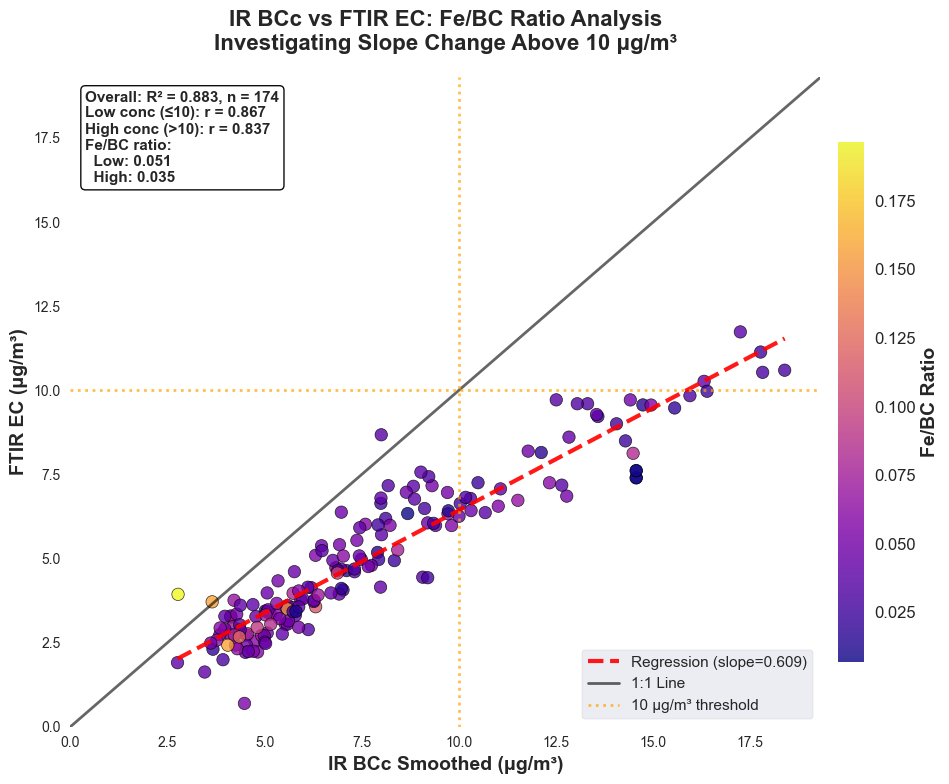


🔍 Fe/BC RATIO ANALYSIS RESULTS:
--------------------------------------------------
📊 Dataset: 174 matched samples
📈 Overall correlation: R² = 0.883

📊 Regional Analysis:
   Low concentration region (≤10 μg/m³):
     • Correlation: r = 0.867
     • Mean Fe/BC ratio: 0.051
     • Sample count: 135
   High concentration region (>10 μg/m³):
     • Correlation: r = 0.837
     • Mean Fe/BC ratio: 0.035
     • Sample count: 39

🎯 KEY FINDING:
   Fe/BC ratio similar across concentration ranges (Δ = -0.016)
   ❌ No evidence that iron causes slope change

📊 Fe/BC Ratio Distribution:
   Mean: 0.047
   Median: 0.044
   Range: 0.007 - 0.196
   Std: 0.027

🎨 Color Scale Interpretation:
   Purple/Blue (low Fe/BC): Minimal iron interference
   Yellow/Red (high Fe/BC): Potential iron interference
   Look for systematic color patterns in high-concentration outliers

✅ Fe/BC ratio analysis complete!
📈 This plot helps determine if iron loading drives measurement bias
🌈 FUNDAMENTAL WAVELENGTH COMPARISON: 

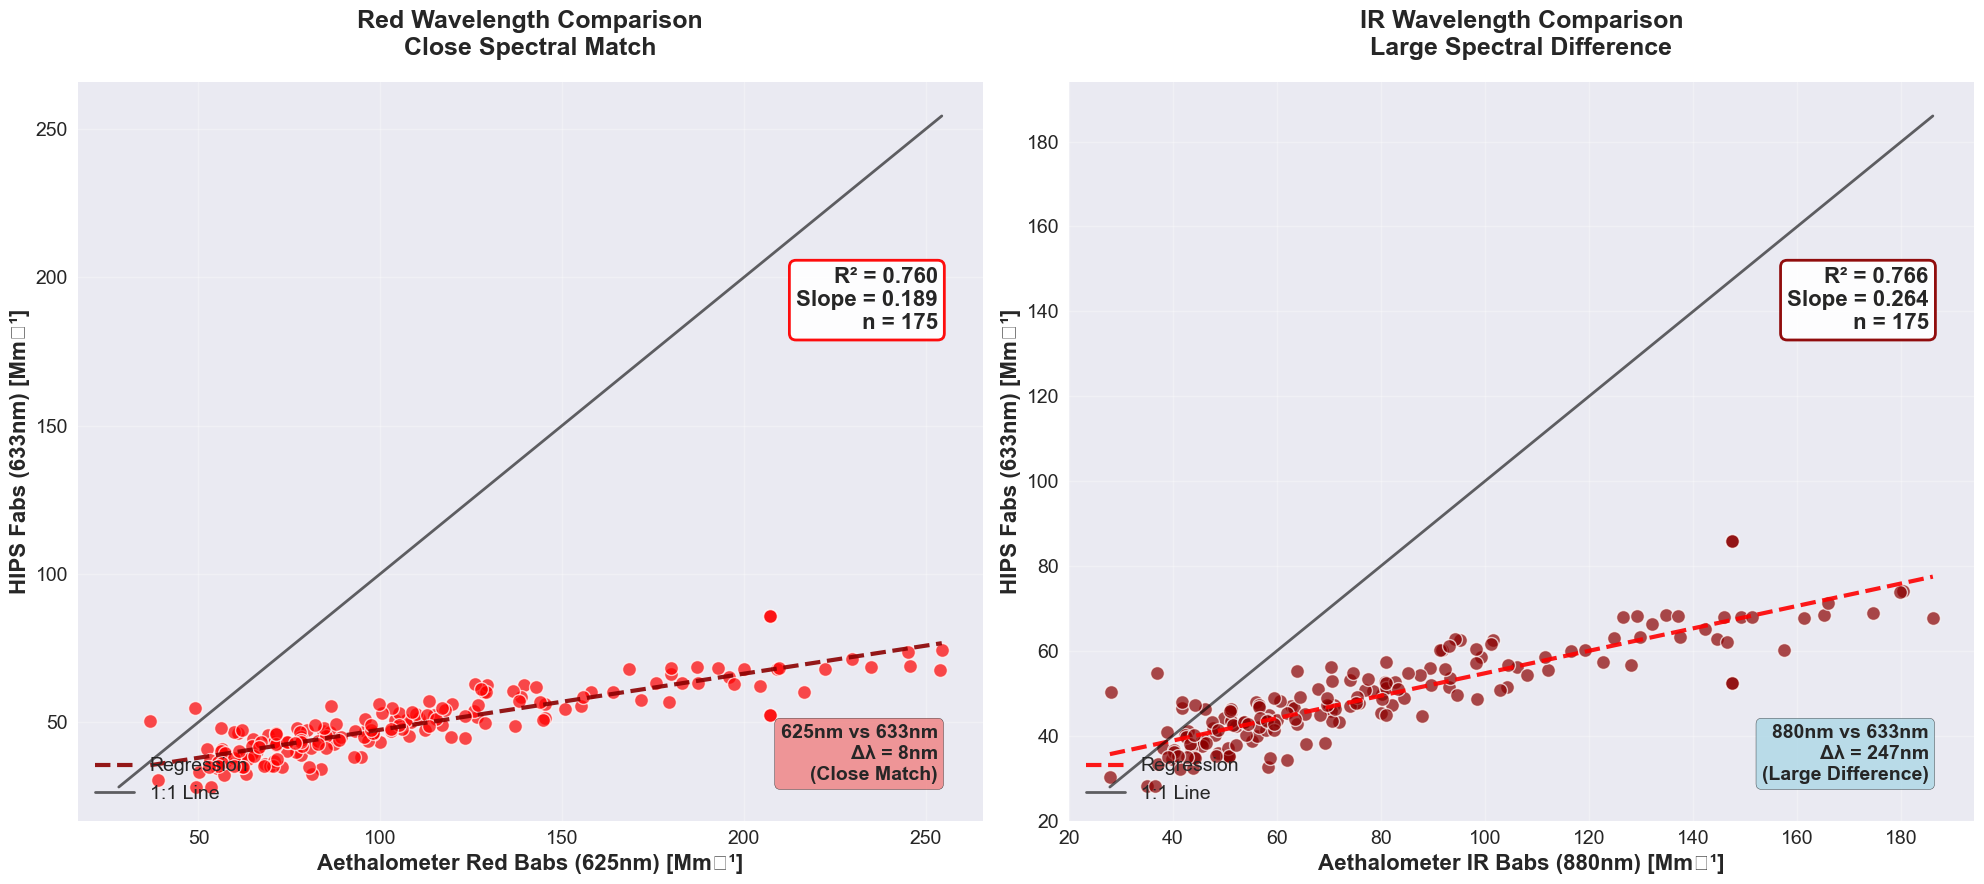


🎯 WAVELENGTH COMPARISON RESULTS:
------------------------------------------------------------
🔴 Red Wavelength (625nm vs 633nm) - Close Match:
   Wavelength difference: 8nm
   HIPS vs Aethalometer: R² = 0.760
   Slope = 0.189
   Sample size: n = 175

🟤 IR Wavelength (880nm vs 633nm) - Large Difference:
   Wavelength difference: 247nm
   HIPS vs Aethalometer: R² = 0.766
   Slope = 0.264
   Sample size: n = 175

🔬 KEY SCIENTIFIC FINDING:
----------------------------------------
📈 R² Comparison:
   Red (close match):  0.760
   IR (far match):     0.766
   Improvement:        -0.005

📐 Slope Comparison:
   Red slope:  0.189
   IR slope:   0.264
   Difference: 0.075

❌ CRITICAL INSIGHT:
   **Spectral matching provides minimal improvement** (-0.005)
   • Similar R² values despite 239nm wavelength difference
   • Systematic bias persists regardless of wavelength choice
   • The measurement bias is NOT due to wavelength mismatch

💡 IMPLICATIONS:
   • The bias stems from fundamental difference

In [33]:
# %% [markdown]
# ## 14. Fe/BC Ratio Analysis - Investigating Slope Change at High Concentrations
# 
# **Analysis to determine if iron interference causes the observed slope change above 10 μg/m³ BC**

# %%
# Fe/BC Ratio Analysis - IR BCc vs FTIR EC colored by Fe/BC ratio
print("🧲 INVESTIGATING Fe/BC RATIO EFFECTS ON HIGH-CONCENTRATION MEASUREMENTS")
print("=" * 75)
print("Testing whether iron interference causes slope change above 10 μg/m³ BC")

if all(col in matched_data.columns for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    # Calculate Fe/BC ratio
    fe_bc_mask = matched_data[['Iron_ChemSpec_ug', 'IR BCc smoothed']].notna().all(axis=1)
    
    if fe_bc_mask.sum() > 0:
        # Avoid division by zero
        valid_bc_mask = matched_data['IR BCc smoothed'] > 0.1  # Minimum BC threshold
        analysis_mask = fe_bc_mask & valid_bc_mask
        
        if analysis_mask.sum() > 5:
            matched_data.loc[analysis_mask, 'Fe_BC_ratio'] = (
                matched_data.loc[analysis_mask, 'Iron_ChemSpec_ug'] / 
                matched_data.loc[analysis_mask, 'IR BCc smoothed']
            )
            
            # Filter for plotting (require all three variables)
            plot_mask = matched_data[['IR BCc smoothed', 'EC_ftir', 'Fe_BC_ratio']].notna().all(axis=1)
            
            if plot_mask.sum() > 5:
                x_data = matched_data.loc[plot_mask, 'IR BCc smoothed']
                y_data = matched_data.loc[plot_mask, 'EC_ftir']
                fe_bc_ratio = matched_data.loc[plot_mask, 'Fe_BC_ratio']
                
                # Create the plot with white background
                fig, ax = plt.subplots(figsize=(10, 8))
                fig.patch.set_facecolor('white')
                ax.set_facecolor('white')
                
                # Create scatter plot with Fe/BC ratio color-coding
                # Use a colormap that avoids grey/yellow conflicts
                scatter = ax.scatter(x_data, y_data, c=fe_bc_ratio, 
                                   cmap='plasma', alpha=0.8, s=80, 
                                   edgecolors='black', linewidth=0.5)
                
                # Add colorbar for Fe/BC ratio
                cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
                cbar.set_label('Fe/BC Ratio', fontsize=14, fontweight='bold')
                cbar.ax.tick_params(labelsize=12)
                
                # Calculate regression line
                z = np.polyfit(x_data, y_data, 1)
                p = np.poly1d(z)
                slope, intercept = z
                
                # Plot regression line
                x_line = np.linspace(x_data.min(), x_data.max(), 100)
                ax.plot(x_line, p(x_line), "--", color='red', linewidth=3, 
                       alpha=0.9, label=f'Regression (slope={slope:.3f})')
                
                # Add 1:1 line
                axis_max = max(x_data.max(), y_data.max()) * 1.05
                ax.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.6, 
                       linewidth=2, label='1:1 Line')
                
                # Highlight the 10 μg/m³ threshold region
                ax.axvline(x=10, color='orange', linestyle=':', linewidth=2, 
                          alpha=0.7, label='10 μg/m³ threshold')
                ax.axhline(y=10, color='orange', linestyle=':', linewidth=2, alpha=0.7)
                
                # Statistics
                corr = x_data.corr(y_data)
                r2 = corr**2
                n = len(x_data)
                
                # Separate statistics for high and low concentration regions
                low_conc_mask = (x_data <= 10) & (y_data <= 10)
                high_conc_mask = (x_data > 10) | (y_data > 10)
                
                if low_conc_mask.sum() > 2 and high_conc_mask.sum() > 2:
                    # Calculate separate correlations
                    low_corr = x_data[low_conc_mask].corr(y_data[low_conc_mask])
                    high_corr = x_data[high_conc_mask].corr(y_data[high_conc_mask])
                    
                    # Calculate Fe/BC ratio statistics by region
                    low_fe_bc_mean = fe_bc_ratio[low_conc_mask].mean()
                    high_fe_bc_mean = fe_bc_ratio[high_conc_mask].mean()
                    
                    # Statistics text
                    stats_text = (f'Overall: R² = {r2:.3f}, n = {n}\n'
                                f'Low conc (≤10): r = {low_corr:.3f}\n'
                                f'High conc (>10): r = {high_corr:.3f}\n'
                                f'Fe/BC ratio:\n'
                                f'  Low: {low_fe_bc_mean:.3f}\n'
                                f'  High: {high_fe_bc_mean:.3f}')
                else:
                    stats_text = f'Overall: R² = {r2:.3f}, n = {n}'
                
                # Position statistics text
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                       verticalalignment='top', horizontalalignment='left',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, 
                               edgecolor='black', linewidth=1),
                       fontsize=11, fontweight='bold')
                
                # Formatting
                ax.set_xlabel('IR BCc Smoothed (μg/m³)', fontsize=14, fontweight='bold')
                ax.set_ylabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
                ax.set_title('IR BCc vs FTIR EC: Fe/BC Ratio Analysis\nInvestigating Slope Change Above 10 μg/m³', 
                           fontsize=16, fontweight='bold', pad=20)
                ax.grid(True, alpha=0.3)
                ax.legend(loc='lower right', fontsize=11, frameon=True, 
                         fancybox=True, framealpha=0.9)
                
                # Set axis limits starting from 0
                ax.set_xlim(0, axis_max)
                ax.set_ylim(0, axis_max)
                
                plt.tight_layout()
                plt.show()
                
                # Analysis and interpretation
                print(f"\n🔍 Fe/BC RATIO ANALYSIS RESULTS:")
                print("-" * 50)
                print(f"📊 Dataset: {n} matched samples")
                print(f"📈 Overall correlation: R² = {r2:.3f}")
                
                if low_conc_mask.sum() > 2 and high_conc_mask.sum() > 2:
                    print(f"\n📊 Regional Analysis:")
                    print(f"   Low concentration region (≤10 μg/m³):")
                    print(f"     • Correlation: r = {low_corr:.3f}")
                    print(f"     • Mean Fe/BC ratio: {low_fe_bc_mean:.3f}")
                    print(f"     • Sample count: {low_conc_mask.sum()}")
                    
                    print(f"   High concentration region (>10 μg/m³):")
                    print(f"     • Correlation: r = {high_corr:.3f}")
                    print(f"     • Mean Fe/BC ratio: {high_fe_bc_mean:.3f}")
                    print(f"     • Sample count: {high_conc_mask.sum()}")
                    
                    # Test for significant difference in Fe/BC ratios
                    fe_bc_diff = high_fe_bc_mean - low_fe_bc_mean
                    print(f"\n🎯 KEY FINDING:")
                    if abs(fe_bc_diff) > 0.05:  # Arbitrary threshold for "significant"
                        print(f"   Fe/BC ratio differs significantly between regions:")
                        print(f"   Δ(Fe/BC) = {fe_bc_diff:.3f}")
                        if fe_bc_diff > 0:
                            print(f"   ✅ Higher Fe/BC at high concentrations supports iron interference hypothesis")
                        else:
                            print(f"   ❌ Lower Fe/BC at high concentrations argues against iron interference")
                    else:
                        print(f"   Fe/BC ratio similar across concentration ranges (Δ = {fe_bc_diff:.3f})")
                        print(f"   ❌ No evidence that iron causes slope change")
                
                # Fe/BC ratio distribution analysis
                fe_bc_stats = fe_bc_ratio.describe()
                print(f"\n📊 Fe/BC Ratio Distribution:")
                print(f"   Mean: {fe_bc_stats['mean']:.3f}")
                print(f"   Median: {fe_bc_stats['50%']:.3f}")
                print(f"   Range: {fe_bc_stats['min']:.3f} - {fe_bc_stats['max']:.3f}")
                print(f"   Std: {fe_bc_stats['std']:.3f}")
                
                # Color scale interpretation
                print(f"\n🎨 Color Scale Interpretation:")
                print(f"   Purple/Blue (low Fe/BC): Minimal iron interference")
                print(f"   Yellow/Red (high Fe/BC): Potential iron interference")
                print(f"   Look for systematic color patterns in high-concentration outliers")
                
                print(f"\n✅ Fe/BC ratio analysis complete!")
                print(f"📈 This plot helps determine if iron loading drives measurement bias")
                
            else:
                print("❌ Insufficient data with all three variables for Fe/BC analysis")
        else:
            print("❌ Insufficient valid BC data for Fe/BC ratio calculation")
    else:
        print("❌ No valid Iron and BC data for ratio calculation")
else:
    print("❌ Required columns not available for Fe/BC ratio analysis")
    missing = [col for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug'] 
               if col not in matched_data.columns]
    for col in missing:
        print(f"   Missing: {col}")

# %% [markdown]
# ## 15. Fundamental Wavelength Comparison: HIPS vs Aethalometer Absorption
# 
# **Does spectral matching improve correlation? Comparing absorption values to avoid MAC conversion effects**

# %%
# Fundamental Wavelength Comparison - HIPS vs Aethalometer Absorption
print("🌈 FUNDAMENTAL WAVELENGTH COMPARISON: HIPS vs AETHALOMETER ABSORPTION")
print("=" * 75)
print("Testing whether spectral matching improves correlation using absorption values")
print("HIPS (633nm) vs Aethalometer Red (625nm, Δλ=8nm) vs IR (880nm, Δλ=247nm)")

# Check available data
wavelength_columns = ['Red Babs', 'IR Babs', 'HIPS_Fabs']
available_wavelengths = [col for col in wavelength_columns if col in matched_data.columns]

if len(available_wavelengths) >= 2 and 'HIPS_Fabs' in available_wavelengths:
    
    print(f"\n📊 Wavelength Specifications:")
    print(f"   HIPS Fabs:            633nm (He-Ne laser)")
    print(f"   Aethalometer Red:     625nm (Δλ = 8nm from HIPS)")
    print(f"   Aethalometer IR:      880nm (Δλ = 247nm from HIPS)")
    print(f"   Using absorption values to preserve wavelength effects")
    
    # Create side-by-side large comparison plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))  # Much larger plots
    
    results = {}
    
    # RED WAVELENGTH COMPARISON (625nm vs 633nm - close match)
    print(f"\n🔴 Analyzing Red wavelength comparison (625nm vs 633nm)...")
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'Red Babs']):
        red_mask = matched_data[['HIPS_Fabs', 'Red Babs']].notna().all(axis=1)
        
        if red_mask.sum() > 2:
            x_red = matched_data.loc[red_mask, 'Red Babs']  # Aethalometer Red absorption
            y_red = matched_data.loc[red_mask, 'HIPS_Fabs']  # HIPS absorption
            
            # Calculate statistics
            corr_red = x_red.corr(y_red)
            r2_red = corr_red**2
            slope_red = np.polyfit(x_red, y_red, 1)[0]
            n_red = len(x_red)
            
            results['Red'] = {'r2': r2_red, 'slope': slope_red, 'n': n_red, 'corr': corr_red}
            
            # Plot Red wavelength comparison
            axes[0].scatter(x_red, y_red, alpha=0.7, color='red', s=100, 
                           edgecolors='white', linewidth=1)
            
            # Regression line
            z = np.polyfit(x_red, y_red, 1)
            p = np.poly1d(z)
            x_line = np.linspace(x_red.min(), x_red.max(), 100)
            axes[0].plot(x_line, p(x_line), "--", color='darkred', linewidth=3, alpha=0.9, label='Regression')
            
            # 1:1 line
            data_min = min(x_red.min(), y_red.min())
            data_max = max(x_red.max(), y_red.max())
            axes[0].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.6, linewidth=2, label='1:1 Line')
            
            # Statistics text - larger font, positioned to avoid data overlap
            stats_text = f'R² = {r2_red:.3f}\nSlope = {slope_red:.3f}\nn = {n_red}'
            axes[0].text(0.95, 0.75, stats_text, transform=axes[0].transAxes, 
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='red', linewidth=2),
                        fontsize=16, fontweight='bold')
            
            # Wavelength info
            wavelength_text = '625nm vs 633nm\nΔλ = 8nm\n(Close Match)'
            axes[0].text(0.95, 0.05, wavelength_text, transform=axes[0].transAxes,
                        verticalalignment='bottom', horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
                        fontsize=14, fontweight='bold')
            
            axes[0].set_xlabel('Aethalometer Red Babs (625nm) [Mm⁻¹]', fontsize=16, fontweight='bold')
            axes[0].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=16, fontweight='bold')
            axes[0].set_title('Red Wavelength Comparison\nClose Spectral Match', 
                             fontsize=18, fontweight='bold', pad=20)
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(loc='lower left', fontsize=14)
            axes[0].tick_params(axis='both', which='major', labelsize=14)
    
    # IR WAVELENGTH COMPARISON (880nm vs 633nm - large difference)
    print(f"\n🟤 Analyzing IR wavelength comparison (880nm vs 633nm)...")
    if all(col in matched_data.columns for col in ['HIPS_Fabs', 'IR Babs']):
        ir_mask = matched_data[['HIPS_Fabs', 'IR Babs']].notna().all(axis=1)
        
        if ir_mask.sum() > 2:
            x_ir = matched_data.loc[ir_mask, 'IR Babs']  # Aethalometer IR absorption
            y_ir = matched_data.loc[ir_mask, 'HIPS_Fabs']  # HIPS absorption
            
            # Calculate statistics
            corr_ir = x_ir.corr(y_ir)
            r2_ir = corr_ir**2
            slope_ir = np.polyfit(x_ir, y_ir, 1)[0]
            n_ir = len(x_ir)
            
            results['IR'] = {'r2': r2_ir, 'slope': slope_ir, 'n': n_ir, 'corr': corr_ir}
            
            # Plot IR wavelength comparison
            axes[1].scatter(x_ir, y_ir, alpha=0.7, color='darkred', s=100, 
                           edgecolors='white', linewidth=1)
            
            # Regression line
            z = np.polyfit(x_ir, y_ir, 1)
            p = np.poly1d(z)
            x_line = np.linspace(x_ir.min(), x_ir.max(), 100)
            axes[1].plot(x_line, p(x_line), "--", color='red', linewidth=3, alpha=0.9, label='Regression')
            
            # 1:1 line
            data_min = min(x_ir.min(), y_ir.min())
            data_max = max(x_ir.max(), y_ir.max())
            axes[1].plot([data_min, data_max], [data_min, data_max], 
                        'k-', alpha=0.6, linewidth=2, label='1:1 Line')
            
            # Statistics text - larger font, positioned to avoid data overlap
            stats_text = f'R² = {r2_ir:.3f}\nSlope = {slope_ir:.3f}\nn = {n_ir}'
            axes[1].text(0.95, 0.75, stats_text, transform=axes[1].transAxes, 
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='darkred', linewidth=2),
                        fontsize=16, fontweight='bold')
            
            # Wavelength info
            wavelength_text = '880nm vs 633nm\nΔλ = 247nm\n(Large Difference)'
            axes[1].text(0.95, 0.05, wavelength_text, transform=axes[1].transAxes,
                        verticalalignment='bottom', horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                        fontsize=14, fontweight='bold')
            
            axes[1].set_xlabel('Aethalometer IR Babs (880nm) [Mm⁻¹]', fontsize=16, fontweight='bold')
            axes[1].set_ylabel('HIPS Fabs (633nm) [Mm⁻¹]', fontsize=16, fontweight='bold')
            axes[1].set_title('IR Wavelength Comparison\nLarge Spectral Difference', 
                             fontsize=18, fontweight='bold', pad=20)
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(loc='lower left', fontsize=14)
            axes[1].tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis and Interpretation
    print(f"\n🎯 WAVELENGTH COMPARISON RESULTS:")
    print("-" * 60)
    
    if 'Red' in results:
        print(f"🔴 Red Wavelength (625nm vs 633nm) - Close Match:")
        print(f"   Wavelength difference: 8nm")
        print(f"   HIPS vs Aethalometer: R² = {results['Red']['r2']:.3f}")
        print(f"   Slope = {results['Red']['slope']:.3f}")
        print(f"   Sample size: n = {results['Red']['n']}")
    
    if 'IR' in results:
        print(f"\n🟤 IR Wavelength (880nm vs 633nm) - Large Difference:")
        print(f"   Wavelength difference: 247nm") 
        print(f"   HIPS vs Aethalometer: R² = {results['IR']['r2']:.3f}")
        print(f"   Slope = {results['IR']['slope']:.3f}")
        print(f"   Sample size: n = {results['IR']['n']}")
    
    # Key Scientific Finding
    if 'Red' in results and 'IR' in results:
        r2_improvement = results['Red']['r2'] - results['IR']['r2']
        slope_diff = abs(results['Red']['slope'] - results['IR']['slope'])
        
        print(f"\n🔬 KEY SCIENTIFIC FINDING:")
        print("-" * 40)
        print(f"📈 R² Comparison:")
        print(f"   Red (close match):  {results['Red']['r2']:.3f}")
        print(f"   IR (far match):     {results['IR']['r2']:.3f}")
        print(f"   Improvement:        {r2_improvement:+.3f}")
        
        print(f"\n📐 Slope Comparison:")
        print(f"   Red slope:  {results['Red']['slope']:.3f}")
        print(f"   IR slope:   {results['IR']['slope']:.3f}")
        print(f"   Difference: {slope_diff:.3f}")
        
        if abs(r2_improvement) < 0.05:  # Small improvement threshold
            print(f"\n❌ CRITICAL INSIGHT:")
            print(f"   **Spectral matching provides minimal improvement** ({r2_improvement:+.3f})")
            print(f"   • Similar R² values despite 239nm wavelength difference")
            print(f"   • Systematic bias persists regardless of wavelength choice")
            print(f"   • The measurement bias is NOT due to wavelength mismatch")
        else:
            if r2_improvement > 0:
                print(f"\n✅ SPECTRAL MATCHING HELPS:")
                print(f"   Better correlation with closer wavelength match")
            else:
                print(f"\n⚠️  UNEXPECTED RESULT:")
                print(f"   IR shows better correlation despite wavelength mismatch")
        
        print(f"\n💡 IMPLICATIONS:")
        print(f"   • The bias stems from fundamental differences in measurement methods")
        print(f"   • Instrument-specific factors beyond spectral matching dominate")
        print(f"   • Default corrections may be inappropriate for Ethiopian aerosols")
        print(f"   • Focus should be on calibration factors, not wavelength matching")
        
        print(f"\n🔬 SCIENTIFIC SIGNIFICANCE:")
        print(f"   This demonstrates that the systematic bias between instruments")
        print(f"   is not simply due to wavelength differences but reflects more")
        print(f"   fundamental differences in measurement principles and corrections.")
        
    else:
        print("❌ Insufficient data for comprehensive wavelength comparison")
        
    print(f"\n✅ Fundamental wavelength comparison complete!")
    print(f"📊 Analysis uses absorption values to preserve wavelength effects")
    print(f"🎯 Results inform whether spectral matching improves measurement agreement")
        
else:
    print("❌ Insufficient wavelength data available for fundamental comparison")
    missing = [col for col in wavelength_columns if col not in matched_data.columns]
    for col in missing:
        print(f"   Missing: {col}")

🧲 Creating IR BCc vs FTIR EC with Iron color-coding...


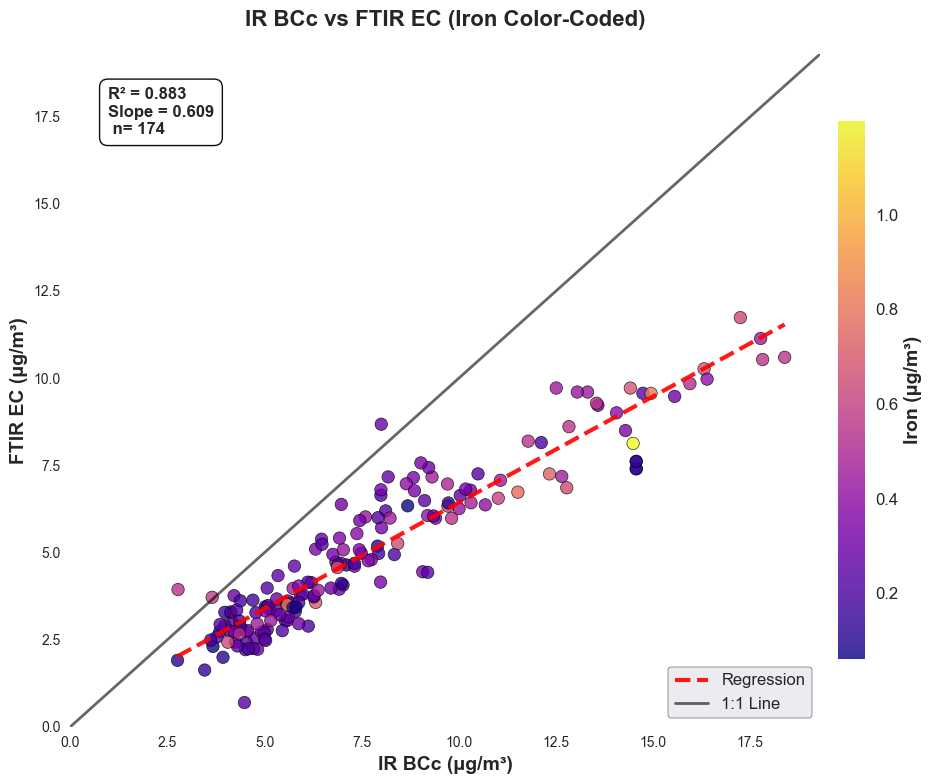

📊 IR BCc vs FTIR EC (Fe-coded): R² = 0.883, Slope = 0.609, n = 174
🧲 Iron range: 0.060 - 1.198 μg/m³ (mean: 0.331 ± 0.171)


In [48]:
# %% 
# IR BCc vs FTIR EC with Iron Color-Coding
print("🧲 Creating IR BCc vs FTIR EC with Iron color-coding...")

if all(col in matched_data.columns for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    # Filter for plotting (require all three variables)
    plot_mask = matched_data[['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']].notna().all(axis=1)
    
    if plot_mask.sum() > 5:
        x_data = matched_data.loc[plot_mask, 'IR BCc smoothed']
        y_data = matched_data.loc[plot_mask, 'EC_ftir']
        iron_data = matched_data.loc[plot_mask, 'Iron_ChemSpec_ug']
        
        # Create the plot with white background
        fig, ax = plt.subplots(figsize=(10, 8))
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')
        
        # Create scatter plot with Iron color-coding
        scatter = ax.scatter(x_data, y_data, c=iron_data, 
                           cmap='plasma', alpha=0.8, s=80, 
                           edgecolors='black', linewidth=0.5)
        
        # Add colorbar for Iron concentration
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.02)
        cbar.set_label('Iron (μg/m³)', fontsize=14, fontweight='bold')
        cbar.ax.tick_params(labelsize=12)
        
        # Calculate regression line
        z = np.polyfit(x_data, y_data, 1)
        p = np.poly1d(z)
        slope, intercept = z
        
        # Plot regression line
        x_line = np.linspace(x_data.min(), x_data.max(), 100)
        ax.plot(x_line, p(x_line), "--", color='red', linewidth=3, 
               alpha=0.9, label='Regression')
        
        # Add 1:1 line
        axis_max = max(x_data.max(), y_data.max()) * 1.05
        ax.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.6, 
               linewidth=2, label='1:1 Line')
        
        # Statistics
        corr = x_data.corr(y_data)
        r2 = corr**2
        n = len(x_data)
        
        # FIXED: Use single backslash for newlines, not double backslash
        stats_text = f'R² = {r2:.3f}\nSlope = {slope:.3f}\n n= {n}'
        
        # Position statistics text with better formatting
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.95, 
                       edgecolor='black', linewidth=1),
               fontsize=12, fontweight='bold')
        
        # Formatting
        ax.set_xlabel('IR BCc (μg/m³)', fontsize=14, fontweight='bold')
        ax.set_ylabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
        ax.set_title('IR BCc vs FTIR EC (Iron Color-Coded)', 
                   fontsize=16, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3)
        
        # Fixed legend positioning and formatting
        ax.legend(loc='lower right', fontsize=12, frameon=True, 
                 fancybox=True, framealpha=0.95, edgecolor='black')
        
        # Set axis limits starting from 0
        ax.set_xlim(0, axis_max)
        ax.set_ylim(0, axis_max)
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 IR BCc vs FTIR EC (Fe-coded): R² = {r2:.3f}, Slope = {slope:.3f}, n = {n}")
        print(f"🧲 Iron range: {iron_data.min():.3f} - {iron_data.max():.3f} μg/m³ (mean: {iron_data.mean():.3f} ± {iron_data.std():.3f})")
        
    else:
        print("❌ Insufficient data for IR BCc vs FTIR EC analysis")
else:
    print("❌ IR BCc, FTIR EC, or Iron data not available")

🧲 IR BCc vs FTIR EC: IRON ANALYSIS
Creating Plot 1: Iron color-coding...


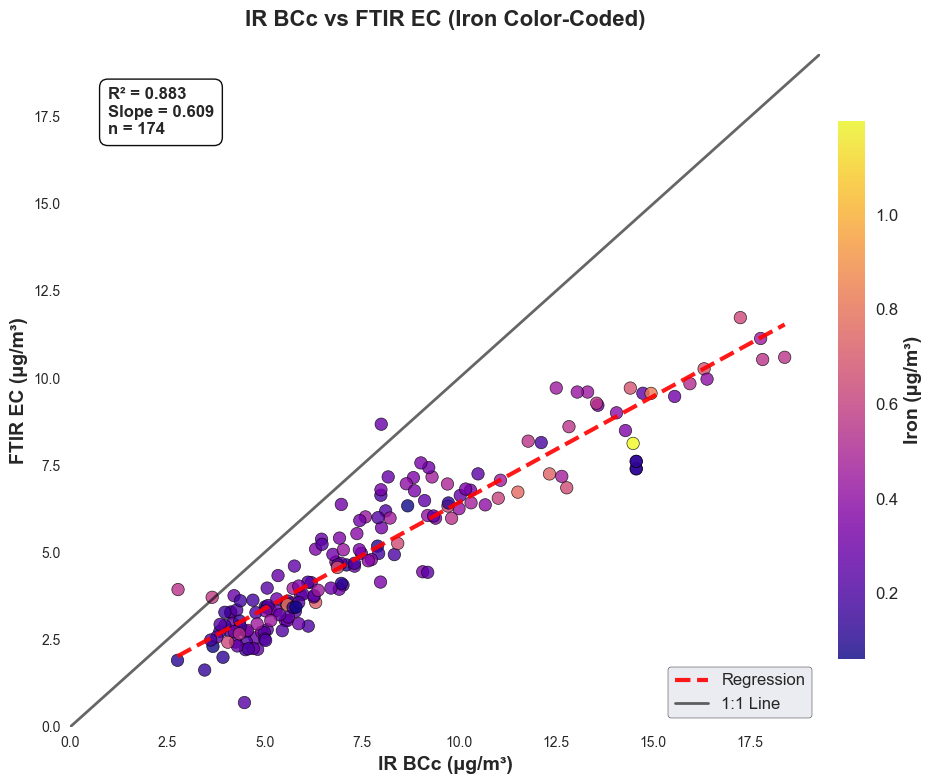

📊 Plot 1 Results: R² = 0.883, Slope = 0.609, n = 174
🧲 Iron range: 0.060 - 1.198 μg/m³

Creating Plot 2: Fe/BC ratio color-coding...


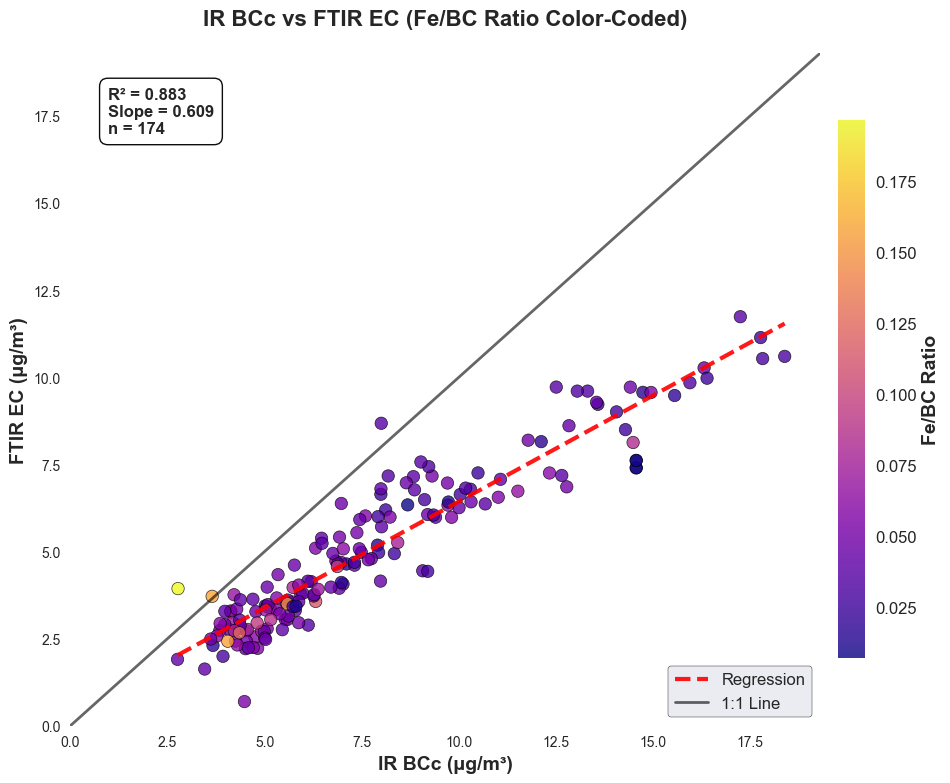

📊 Plot 2 Results: R² = 0.883, Slope = 0.609, n = 174
🧲 Fe/BC range: 0.007 - 0.196

✅ Both iron analysis plots complete!


In [55]:
# %%
# IR BCc vs FTIR EC: Iron and Fe/BC Ratio Analysis
print("🧲 IR BCc vs FTIR EC: IRON ANALYSIS")
print("=" * 50)

if all(col in matched_data.columns for col in ['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']):
    
    # PLOT 1: Iron Color-Coding
    print("Creating Plot 1: Iron color-coding...")
    plot_mask1 = matched_data[['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']].notna().all(axis=1)
    
    if plot_mask1.sum() > 5:
        x_data1 = matched_data.loc[plot_mask1, 'IR BCc smoothed']
        y_data1 = matched_data.loc[plot_mask1, 'EC_ftir']
        iron_data = matched_data.loc[plot_mask1, 'Iron_ChemSpec_ug']
        
        # Create first plot
        fig, ax = plt.subplots(figsize=(10, 8))
        fig.patch.set_facecolor('white')
        ax.set_facecolor('white')
        
        scatter1 = ax.scatter(x_data1, y_data1, c=iron_data, 
                            cmap='plasma', alpha=0.8, s=80, 
                            edgecolors='black', linewidth=0.5)
        
        cbar1 = plt.colorbar(scatter1, ax=ax, shrink=0.8, aspect=20, pad=0.02)
        cbar1.set_label('Iron (μg/m³)', fontsize=14, fontweight='bold')
        cbar1.ax.tick_params(labelsize=12)
        
        z1 = np.polyfit(x_data1, y_data1, 1)
        p1 = np.poly1d(z1)
        slope1, intercept1 = z1
        
        x_line1 = np.linspace(x_data1.min(), x_data1.max(), 100)
        ax.plot(x_line1, p1(x_line1), "--", color='red', linewidth=3, 
               alpha=0.9, label='Regression')
        
        axis_max1 = max(x_data1.max(), y_data1.max()) * 1.05
        ax.plot([0, axis_max1], [0, axis_max1], 'k-', alpha=0.6, 
               linewidth=2, label='1:1 Line')
        
        corr1 = x_data1.corr(y_data1)
        r2_1 = corr1**2
        n1 = len(x_data1)
        
        stats_text1 = f'R² = {r2_1:.3f}\nSlope = {slope1:.3f}\nn = {n1}'
        ax.text(0.05, 0.95, stats_text1, transform=ax.transAxes, 
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.95, 
                       edgecolor='black', linewidth=1),
               fontsize=12, fontweight='bold')
        
        ax.set_xlabel('IR BCc (μg/m³)', fontsize=14, fontweight='bold')
        ax.set_ylabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
        ax.set_title('IR BCc vs FTIR EC (Iron Color-Coded)', 
                   fontsize=16, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=12, frameon=True, 
                 fancybox=True, framealpha=0.95, edgecolor='black')
        ax.set_xlim(0, axis_max1)
        ax.set_ylim(0, axis_max1)
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 Plot 1 Results: R² = {r2_1:.3f}, Slope = {slope1:.3f}, n = {n1}")
        print(f"🧲 Iron range: {iron_data.min():.3f} - {iron_data.max():.3f} μg/m³")
    
    # PLOT 2: Fe/BC Ratio Color-Coding
    print("\nCreating Plot 2: Fe/BC ratio color-coding...")
    
    # Calculate Fe/BC ratio
    fe_bc_mask = matched_data[['Iron_ChemSpec_ug', 'IR BCc smoothed']].notna().all(axis=1)
    
    if fe_bc_mask.sum() > 0:
        valid_bc_mask = matched_data['IR BCc smoothed'] > 0.1
        analysis_mask = fe_bc_mask & valid_bc_mask
        
        if analysis_mask.sum() > 5:
            matched_data.loc[analysis_mask, 'Fe_BC_ratio'] = (
                matched_data.loc[analysis_mask, 'Iron_ChemSpec_ug'] / 
                matched_data.loc[analysis_mask, 'IR BCc smoothed']
            )
            
            plot_mask2 = matched_data[['IR BCc smoothed', 'EC_ftir', 'Fe_BC_ratio']].notna().all(axis=1)
            
            if plot_mask2.sum() > 5:
                x_data2 = matched_data.loc[plot_mask2, 'IR BCc smoothed']
                y_data2 = matched_data.loc[plot_mask2, 'EC_ftir']
                fe_bc_ratio = matched_data.loc[plot_mask2, 'Fe_BC_ratio']
                
                # Create second plot
                fig, ax = plt.subplots(figsize=(10, 8))
                fig.patch.set_facecolor('white')
                ax.set_facecolor('white')
                
                scatter2 = ax.scatter(x_data2, y_data2, c=fe_bc_ratio, 
                                    cmap='plasma', alpha=0.8, s=80, 
                                    edgecolors='black', linewidth=0.5)
                
                cbar2 = plt.colorbar(scatter2, ax=ax, shrink=0.8, aspect=20, pad=0.02)
                cbar2.set_label('Fe/BC Ratio', fontsize=14, fontweight='bold')
                cbar2.ax.tick_params(labelsize=12)
                
                z2 = np.polyfit(x_data2, y_data2, 1)
                p2 = np.poly1d(z2)
                slope2, intercept2 = z2
                
                x_line2 = np.linspace(x_data2.min(), x_data2.max(), 100)
                ax.plot(x_line2, p2(x_line2), "--", color='red', linewidth=3, 
                       alpha=0.9, label='Regression')
                
                axis_max2 = max(x_data2.max(), y_data2.max()) * 1.05
                ax.plot([0, axis_max2], [0, axis_max2], 'k-', alpha=0.6, 
                       linewidth=2, label='1:1 Line')
                
                corr2 = x_data2.corr(y_data2)
                r2_2 = corr2**2
                n2 = len(x_data2)
                
                stats_text2 = f'R² = {r2_2:.3f}\nSlope = {slope2:.3f}\nn = {n2}'
                ax.text(0.05, 0.95, stats_text2, transform=ax.transAxes, 
                       verticalalignment='top', horizontalalignment='left',
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.95, 
                               edgecolor='black', linewidth=1),
                       fontsize=12, fontweight='bold')
                
                ax.set_xlabel('IR BCc (μg/m³)', fontsize=14, fontweight='bold')
                ax.set_ylabel('FTIR EC (μg/m³)', fontsize=14, fontweight='bold')
                ax.set_title('IR BCc vs FTIR EC (Fe/BC Ratio Color-Coded)', 
                           fontsize=16, fontweight='bold', pad=20)
                ax.grid(True, alpha=0.3)
                ax.legend(loc='lower right', fontsize=12, frameon=True, 
                         fancybox=True, framealpha=0.95, edgecolor='black')
                ax.set_xlim(0, axis_max2)
                ax.set_ylim(0, axis_max2)
                
                plt.tight_layout()
                plt.show()
                
                print(f"📊 Plot 2 Results: R² = {r2_2:.3f}, Slope = {slope2:.3f}, n = {n2}")
                print(f"🧲 Fe/BC range: {fe_bc_ratio.min():.3f} - {fe_bc_ratio.max():.3f}")
                
                print(f"\n✅ Both iron analysis plots complete!")
            else:
                print("❌ Insufficient data for Fe/BC ratio plot")
        else:
            print("❌ Insufficient valid BC data for Fe/BC calculation")
    else:
        print("❌ No valid data for Fe/BC ratio calculation")
        
else:
    print("❌ Required columns not available")

In [1]:
# %%
# CORRECTED FE/EC RATIO ANALYSIS - Based on Ann's Feedback (June 18)
print("🔧 CORRECTED IRON ANALYSIS: Using Fe/FTIR EC Ratio Consistently")
print("=" * 75)
print("Following Ann's guidance: FTIR EC is the reference standard")
print("All plots will use Fe/FTIR EC ratio for consistency\n")

# STEP 1: Calculate Fe/FTIR EC ratio ONCE for entire dataset
print("📊 STEP 1: Calculating Fe/FTIR EC Ratio (Reference Standard)")
print("-" * 60)

if all(col in matched_data.columns for col in ['Iron_ChemSpec_ug', 'EC_ftir']):
    # Calculate Fe/FTIR EC ratio with proper filtering
    fe_ec_mask = matched_data[['Iron_ChemSpec_ug', 'EC_ftir']].notna().all(axis=1)
    ec_threshold_mask = matched_data['EC_ftir'] > 0.1  # Avoid division by very small numbers
    valid_ratio_mask = fe_ec_mask & ec_threshold_mask
    
    if valid_ratio_mask.sum() > 0:
        # Calculate the ratio ONCE for all analyses
        matched_data.loc[valid_ratio_mask, 'Fe_EC_ratio_corrected'] = (
            matched_data.loc[valid_ratio_mask, 'Iron_ChemSpec_ug'] / 
            matched_data.loc[valid_ratio_mask, 'EC_ftir']
        )
        
        # Statistics
        fe_ec_ratio = matched_data.loc[valid_ratio_mask, 'Fe_EC_ratio_corrected']
        print(f"✅ Fe/FTIR EC Ratio calculated for {valid_ratio_mask.sum()} samples")
        print(f"📊 Statistics:")
        print(f"   Mean:   {fe_ec_ratio.mean():.3f}")
        print(f"   Median: {fe_ec_ratio.median():.3f}")
        print(f"   Range:  {fe_ec_ratio.min():.3f} - {fe_ec_ratio.max():.3f}")
        
        # STEP 2: Time Series - ONLY Fe/FTIR EC Ratio (DELETE other ratio plots)
        print("\n📊 STEP 2: Time Series - Fe/FTIR EC Ratio ONLY")
        print("-" * 60)
        
        fig, ax = plt.subplots(figsize=(14, 6))
        
        ratio_mask = matched_data['Fe_EC_ratio_corrected'].notna()
        if ratio_mask.sum() > 0:
            ax.scatter(matched_data.loc[ratio_mask, 'datetime_local'], 
                      matched_data.loc[ratio_mask, 'Fe_EC_ratio_corrected'],
                      color='purple', alpha=0.8, s=60, edgecolors='white', linewidth=0.5)
            
            mean_ratio = fe_ec_ratio.mean()
            ax.axhline(y=mean_ratio, color='purple', linestyle='--', alpha=0.7,
                      label=f'Mean = {mean_ratio:.3f}')
        
        ax.set_title('Fe/FTIR EC Ratio Time Series (Corrected - Using Reference Standard)', 
                    fontsize=16, fontweight='bold')
        ax.set_ylabel('Fe/FTIR EC Ratio', fontsize=12)
        ax.set_xlabel('Date', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # STEP 3: HIPS BC vs FTIR EC - Two plots with consistent Fe/EC ratio
        print("\n📊 STEP 3: HIPS BC vs FTIR EC (Fe Analysis)")
        print("-" * 60)
        
        if 'HIPS_Fabs' in matched_data.columns:
            # Create HIPS BC proxy
            matched_data['HIPS_BC_MAC10'] = matched_data['HIPS_Fabs'] / 10.0
            
            # Plot 1: Colored by Fe concentration
            plot_mask = matched_data[['HIPS_BC_MAC10', 'EC_ftir', 'Iron_ChemSpec_ug']].notna().all(axis=1)
            
            if plot_mask.sum() > 5:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
                
                x = matched_data.loc[plot_mask, 'HIPS_BC_MAC10']
                y = matched_data.loc[plot_mask, 'EC_ftir']
                
                # Plot 1: Fe concentration
                scatter1 = ax1.scatter(x, y, c=matched_data.loc[plot_mask, 'Iron_ChemSpec_ug'],
                                      cmap='plasma', alpha=0.8, s=80, edgecolors='black', linewidth=0.5)
                cbar1 = plt.colorbar(scatter1, ax=ax1)
                cbar1.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
                
                # Add regression and 1:1 line
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x.min(), x.max(), 100)
                ax1.plot(x_line, p(x_line), '--', color='red', linewidth=2, label='Regression')
                axis_max = max(x.max(), y.max()) * 1.05
                ax1.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1')
                
                ax1.set_xlabel('HIPS BC (MAC=10) (μg/m³)', fontsize=12)
                ax1.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
                ax1.set_title('HIPS vs FTIR EC - Iron Concentration', fontsize=14, fontweight='bold')
                ax1.legend(loc='upper left')
                ax1.grid(True, alpha=0.3)
                ax1.set_xlim(0, axis_max)
                ax1.set_ylim(0, axis_max)
                
                # Plot 2: Fe/FTIR EC ratio (CORRECTED - using same ratio for all plots)
                plot_mask2 = matched_data[['HIPS_BC_MAC10', 'EC_ftir', 'Fe_EC_ratio_corrected']].notna().all(axis=1)
                
                if plot_mask2.sum() > 5:
                    x2 = matched_data.loc[plot_mask2, 'HIPS_BC_MAC10']
                    y2 = matched_data.loc[plot_mask2, 'EC_ftir']
                    
                    scatter2 = ax2.scatter(x2, y2, c=matched_data.loc[plot_mask2, 'Fe_EC_ratio_corrected'],
                                          cmap='plasma', alpha=0.8, s=80, edgecolors='black', linewidth=0.5)
                    cbar2 = plt.colorbar(scatter2, ax=ax2)
                    cbar2.set_label('Fe/FTIR EC Ratio', fontsize=12, fontweight='bold')
                    
                    # Add regression and 1:1 line
                    z2 = np.polyfit(x2, y2, 1)
                    p2 = np.poly1d(z2)
                    x_line2 = np.linspace(x2.min(), x2.max(), 100)
                    ax2.plot(x_line2, p2(x_line2), '--', color='red', linewidth=2, label='Regression')
                    ax2.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1')
                    
                    ax2.set_xlabel('HIPS BC (MAC=10) (μg/m³)', fontsize=12)
                    ax2.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
                    ax2.set_title('HIPS vs FTIR EC - Fe/FTIR EC Ratio (CORRECTED)', fontsize=14, fontweight='bold')
                    ax2.legend(loc='upper left')
                    ax2.grid(True, alpha=0.3)
                    ax2.set_xlim(0, axis_max)
                    ax2.set_ylim(0, axis_max)
                
                plt.tight_layout()
                plt.show()
                print("✅ HIPS plots created with consistent Fe/FTIR EC ratio")
        
        # STEP 4: IR BCc vs FTIR EC - Two plots with consistent Fe/EC ratio
        print("\n📊 STEP 4: IR BCc vs FTIR EC (Fe Analysis)")
        print("-" * 60)
        
        if 'IR BCc smoothed' in matched_data.columns:
            # Plot 1: Colored by Fe concentration
            plot_mask = matched_data[['IR BCc smoothed', 'EC_ftir', 'Iron_ChemSpec_ug']].notna().all(axis=1)
            
            if plot_mask.sum() > 5:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
                
                x = matched_data.loc[plot_mask, 'IR BCc smoothed']
                y = matched_data.loc[plot_mask, 'EC_ftir']
                
                # Plot 1: Fe concentration
                scatter1 = ax1.scatter(x, y, c=matched_data.loc[plot_mask, 'Iron_ChemSpec_ug'],
                                      cmap='plasma', alpha=0.8, s=80, edgecolors='black', linewidth=0.5)
                cbar1 = plt.colorbar(scatter1, ax=ax1)
                cbar1.set_label('Iron (μg/m³)', fontsize=12, fontweight='bold')
                
                # Add regression and 1:1 line
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x.min(), x.max(), 100)
                ax1.plot(x_line, p(x_line), '--', color='red', linewidth=2, label='Regression')
                axis_max = max(x.max(), y.max()) * 1.05
                ax1.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1')
                
                ax1.set_xlabel('IR BCc (μg/m³)', fontsize=12)
                ax1.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
                ax1.set_title('IR BCc vs FTIR EC - Iron Concentration', fontsize=14, fontweight='bold')
                ax1.legend(loc='upper left')
                ax1.grid(True, alpha=0.3)
                ax1.set_xlim(0, axis_max)
                ax1.set_ylim(0, axis_max)
                
                # Plot 2: Fe/FTIR EC ratio (CORRECTED - using same ratio for all plots)
                plot_mask2 = matched_data[['IR BCc smoothed', 'EC_ftir', 'Fe_EC_ratio_corrected']].notna().all(axis=1)
                
                if plot_mask2.sum() > 5:
                    x2 = matched_data.loc[plot_mask2, 'IR BCc smoothed']
                    y2 = matched_data.loc[plot_mask2, 'EC_ftir']
                    
                    scatter2 = ax2.scatter(x2, y2, c=matched_data.loc[plot_mask2, 'Fe_EC_ratio_corrected'],
                                          cmap='plasma', alpha=0.8, s=80, edgecolors='black', linewidth=0.5)
                    cbar2 = plt.colorbar(scatter2, ax=ax2)
                    cbar2.set_label('Fe/FTIR EC Ratio', fontsize=12, fontweight='bold')
                    
                    # Add regression and 1:1 line
                    z2 = np.polyfit(x2, y2, 1)
                    p2 = np.poly1d(z2)
                    x_line2 = np.linspace(x2.min(), x2.max(), 100)
                    ax2.plot(x_line2, p2(x_line2), '--', color='red', linewidth=2, label='Regression')
                    ax2.plot([0, axis_max], [0, axis_max], 'k-', alpha=0.5, linewidth=1, label='1:1')
                    
                    ax2.set_xlabel('IR BCc (μg/m³)', fontsize=12)
                    ax2.set_ylabel('FTIR EC (μg/m³)', fontsize=12)
                    ax2.set_title('IR BCc vs FTIR EC - Fe/FTIR EC Ratio (CORRECTED)', fontsize=14, fontweight='bold')
                    ax2.legend(loc='upper left')
                    ax2.grid(True, alpha=0.3)
                    ax2.set_xlim(0, axis_max)
                    ax2.set_ylim(0, axis_max)
                
                plt.tight_layout()
                plt.show()
                print("✅ Aethalometer plots created with consistent Fe/FTIR EC ratio")
        
        print("\n" + "=" * 75)
        print("✅ CORRECTED ANALYSIS COMPLETE!")
        print("📊 Key Points:")
        print("   • Fe/FTIR EC ratio calculated ONCE and used consistently")
        print("   • Same ratio values used for both HIPS and Aethalometer plots")
        print("   • This allows direct comparison of iron effects across methods")
        print("   • FTIR EC is the reference standard for all comparisons")
        
    else:
        print("❌ Insufficient valid data for Fe/FTIR EC ratio calculation")
else:
    print("❌ Required columns (Iron_ChemSpec_ug, EC_ftir) not available")

🔧 CORRECTED IRON ANALYSIS: Using Fe/FTIR EC Ratio Consistently
Following Ann's guidance: FTIR EC is the reference standard
All plots will use Fe/FTIR EC ratio for consistency

📊 STEP 1: Calculating Fe/FTIR EC Ratio (Reference Standard)
------------------------------------------------------------


NameError: name 'matched_data' is not defined